#Init and get a ticket

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import subprocess
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import uproot
from scipy import stats
import re
import glob
import sys
import lmfit
from lmfit.models import LinearModel
import hist
import mplhep as hep
import awkward as ak
from numpy.core.function_base import linspace
import uncertainties.unumpy as unumpy

hep.style.use('ATLAS')  # or ATLAS/LHCb2
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams.update({'figure.max_open_warning': 0})
BAD_RUNS=['1066', '1084', '1134']

In [13]:
def flat_list(inlist):
  return [item for sublist in inlist for item in sublist]

In [2]:
file_list = []
with open('run_list.txt') as run_list:    
    for root_file in run_list:
        root_file = 'root://fndca1.fnal.gov'+root_file[:5]+'/fnal.gov/usr/'+root_file[6:-1]+":runSummary"
        if any(ele in root_file for ele in BAD_RUNS):
            continue
        print(root_file)
        file_list.append(root_file)

root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/scratch/outstage/ehrlich/wideband14_1PEtest/crvreco/rec.mu2e.CRV_wideband_cosmics.crvaging-003.001053_000.root:runSummary
root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/scratch/outstage/ehrlich/wideband14_1PEtest/crvreco/rec.mu2e.CRV_wideband_cosmics.crvaging-003.001054_000.root:runSummary
root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/scratch/outstage/ehrlich/wideband14_1PEtest/crvreco/rec.mu2e.CRV_wideband_cosmics.crvaging-003.001059_000.root:runSummary
root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/scratch/outstage/ehrlich/wideband14_1PEtest/crvreco/rec.mu2e.CRV_wideband_cosmics.crvaging-003.001091_000.root:runSummary
root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/scratch/outstage/ehrlich/wideband14_1PEtest/crvreco/rec.mu2e.CRV_wideband_cosmics.crvaging-003.001116_000.root:runSummary
root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/scratch/outstage/ehrlich/wideband14_1PEtest/crvreco/rec.mu2e.CRV_wideband_cosmics.crvaging-003.001124_000.root:run

In [4]:
ar = uproot.concatenate(file_list, xrootdsource={"timeout": 100})
df = ak.to_pandas(ar) # eentry - event, subentry - FEB, subsubentry - AFE

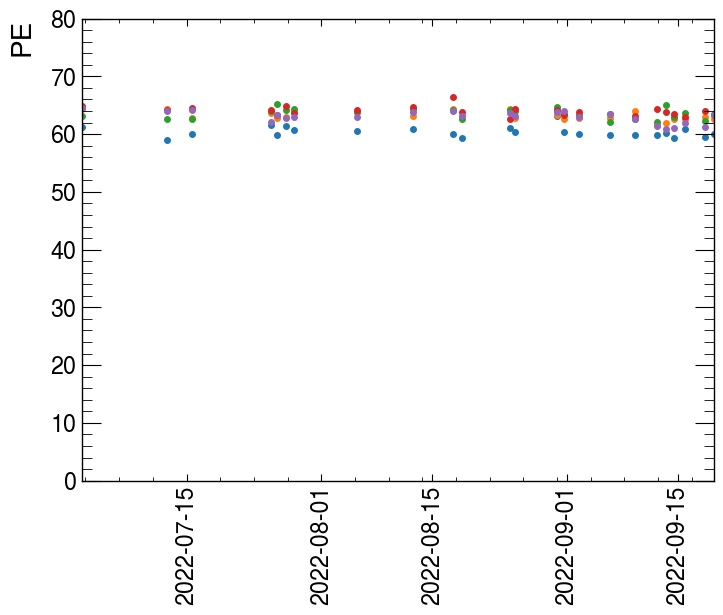

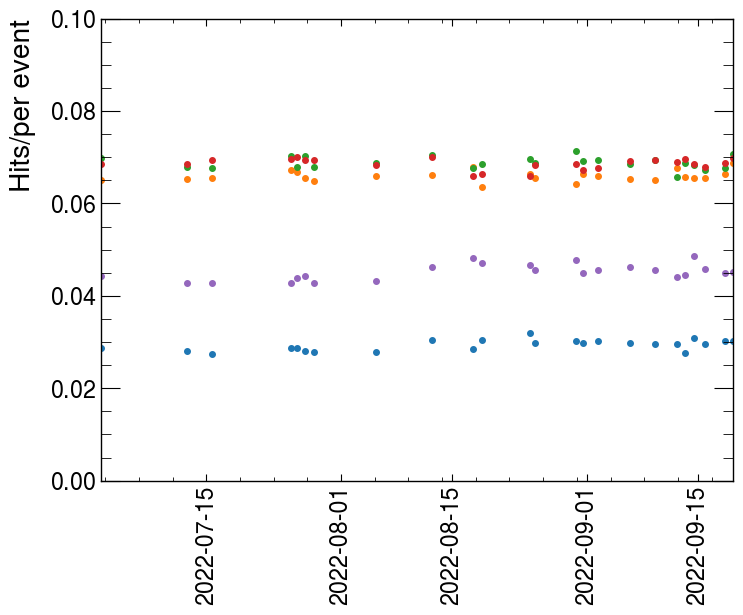

In [12]:
for chan in [0,8,16,24,32]:
    y=ar['PEs'][:,1,chan]
    plt.plot(ar['timestamp'].to_numpy().astype('datetime64[s]'), y, '.')
    plt.xticks(rotation = 90);
    plt.ylim(0, 80);
    plt.ylabel('PE')

plt.figure()
for chan in [0,8,16,24,32]:
    y=ar['signalsTemperatureCorrected'][:,1,chan].to_numpy()/ar['eventsRecorded'][:]
    plt.plot(ar['timestamp'].to_numpy().astype('datetime64[s]'), y, '.')
    plt.xticks(rotation = 90);
    plt.ylim(0,0.1)
    plt.ylabel('Hits/per event')


In [7]:
list(df)

['timestamp',
 'febID',
 'spillsRecorded',
 'eventsRecorded',
 'febSpills',
 'febTemperaturesAvg',
 'supplyMonitorsAvg',
 'biasVoltagesAvg',
 'pipeline',
 'samples',
 'PEs',
 'PEsTemperatureCorrected',
 'FWHMs',
 'FWHMsTemperatureCorrected',
 'signals',
 'signalsTemperatureCorrected',
 'meanTemperatures',
 'pedestals',
 'calibConstants',
 'calibConstantsTemperatureCorrected']

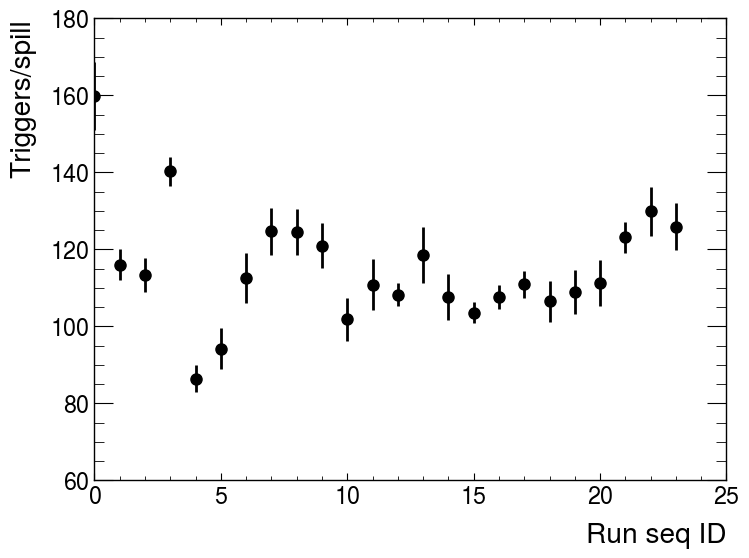

In [50]:
x=len(ar['eventsRecorded'][:].to_numpy())

y1=ar['eventsRecorded'][:].to_numpy()
y1_std=np.sqrt(y1)
y1=unumpy.uarray(y1, y1_std) 

y2=ar['spillsRecorded'][:].to_numpy()
y2_std=np.sqrt(y2)
y2=unumpy.uarray(y2, y2_std) 

x=linspace(0,x-1,x)
y=y1/y2

plt.errorbar(x, unumpy.nominal_values(y), yerr=unumpy.std_devs(y), fmt="o", color="k")
plt.ylabel('Triggers/spill')
plt.xlabel('Run seq ID');

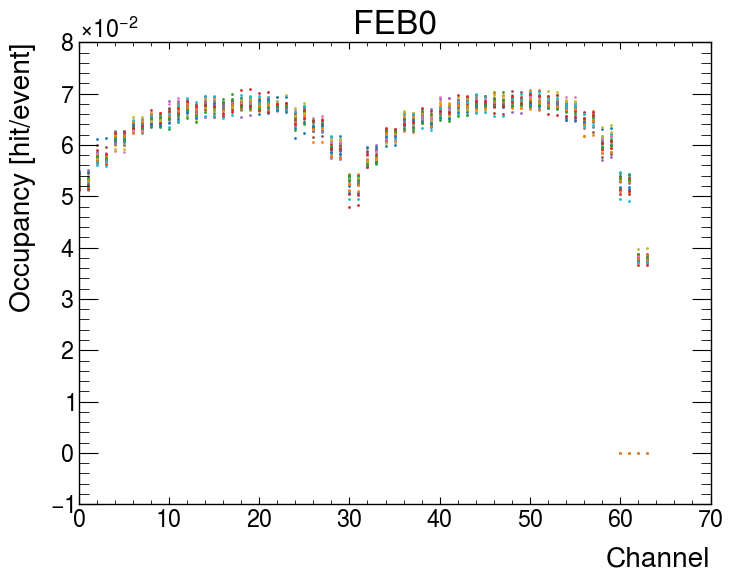

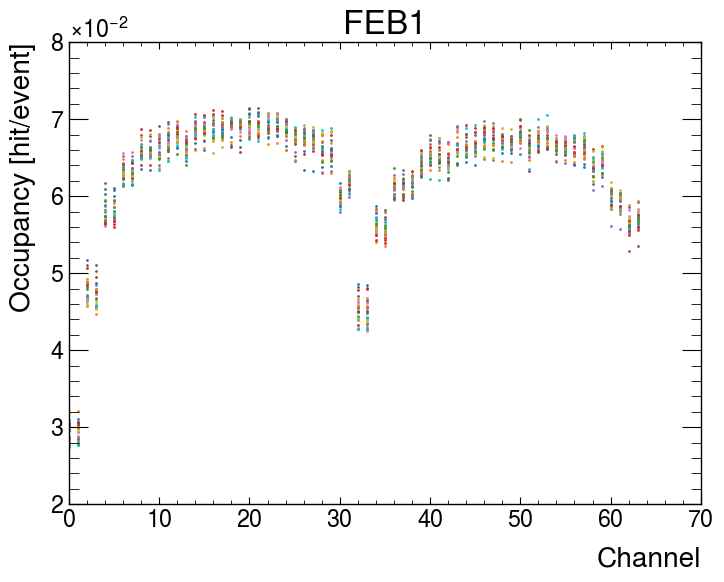

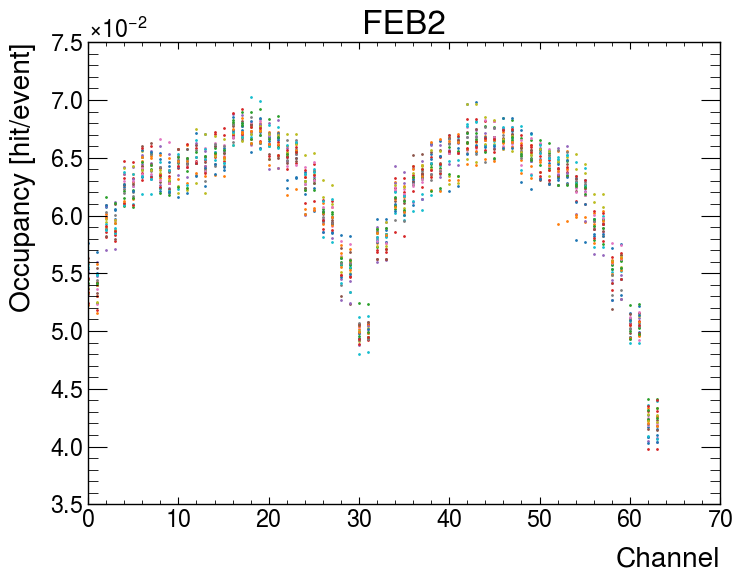

In [44]:
from numpy.core.function_base import linspace
for feb in range(0, 3):
  plt.figure()
  for run in range(0,ak.count(ar['eventsRecorded'])):
    x=linspace(0,63,64)
#    y=ar['signalsTemperatureCorrected'][run,feb,:].to_numpy()/ar['spillsRecorded'][run]
    y=ar['signalsTemperatureCorrected'][run,feb,:].to_numpy()/ar['eventsRecorded'][run]
    plt.plot(x,y, '.', markersize=2, label='Run: %d'%run);
    plt.ylabel('Occupancy [hit/event]')
    plt.xlabel('Channel')
#    plt.ylim(0,0.1)
    plt.title('FEB%d'%feb)
#    plt.legend(prop={'size': 6})

In [589]:
#x=ak.pad_none(ar['febTemperaturesAvg'],6)[:,5]
#x[~ak.is_none(x)].to_list()

<Figure size 800x600 with 0 Axes>

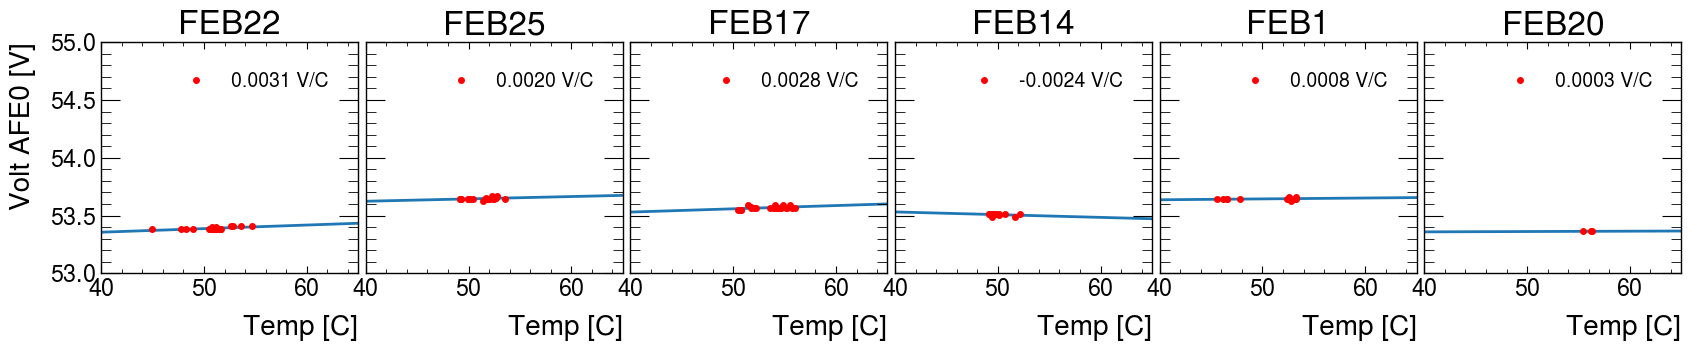

<Figure size 800x600 with 0 Axes>

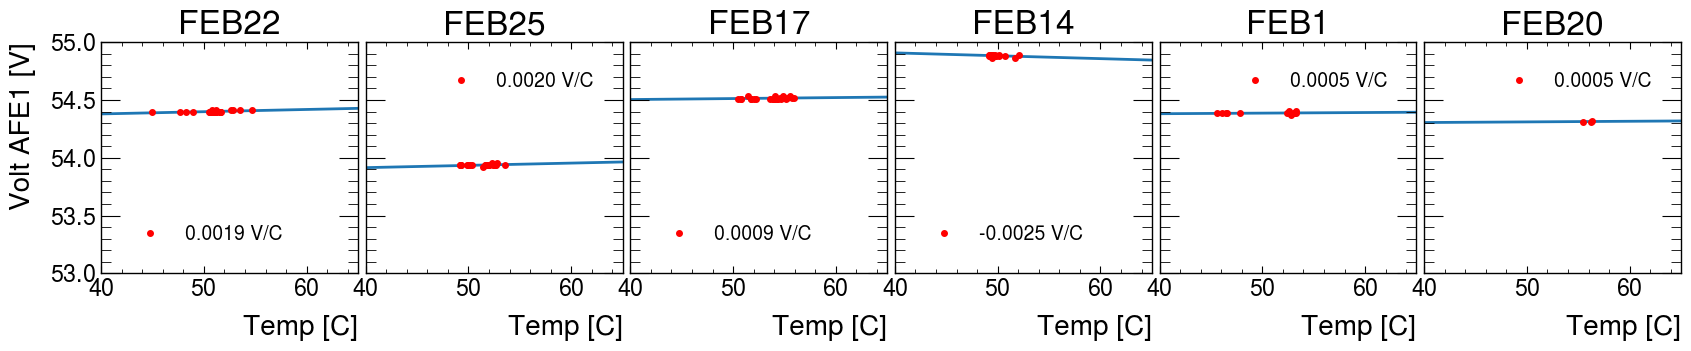

<Figure size 800x600 with 0 Axes>

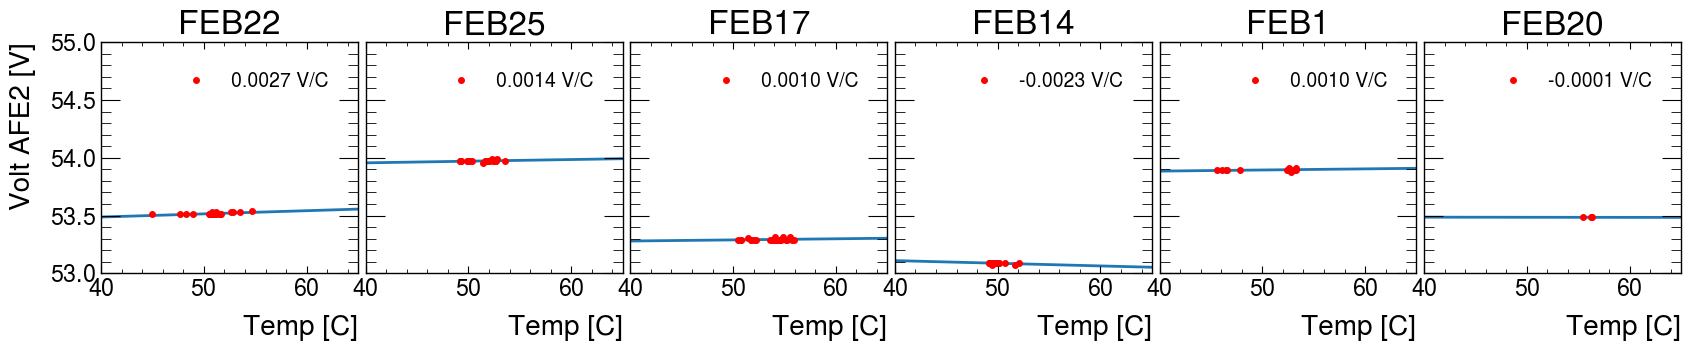

<Figure size 800x600 with 0 Axes>

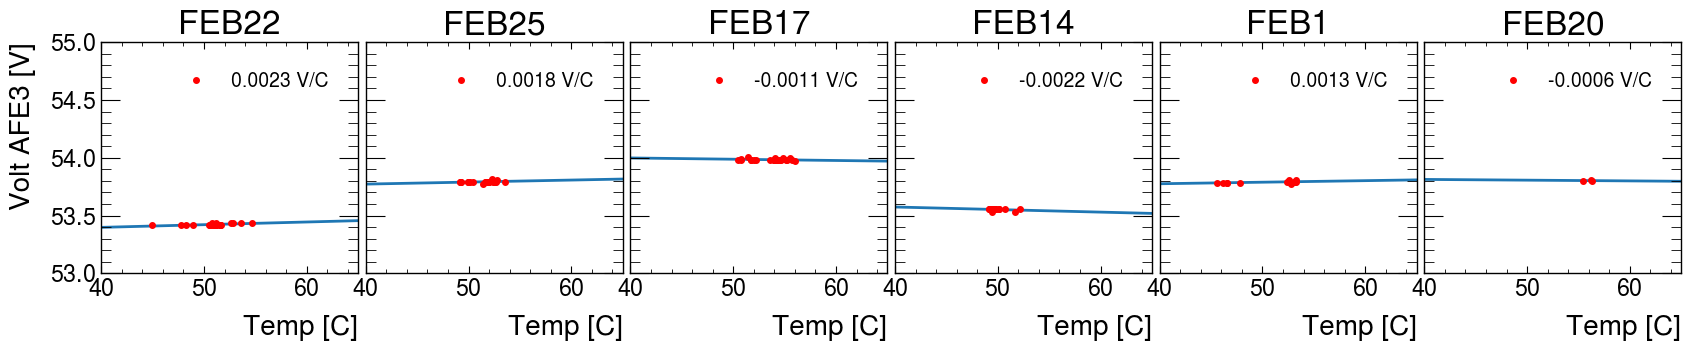

<Figure size 800x600 with 0 Axes>

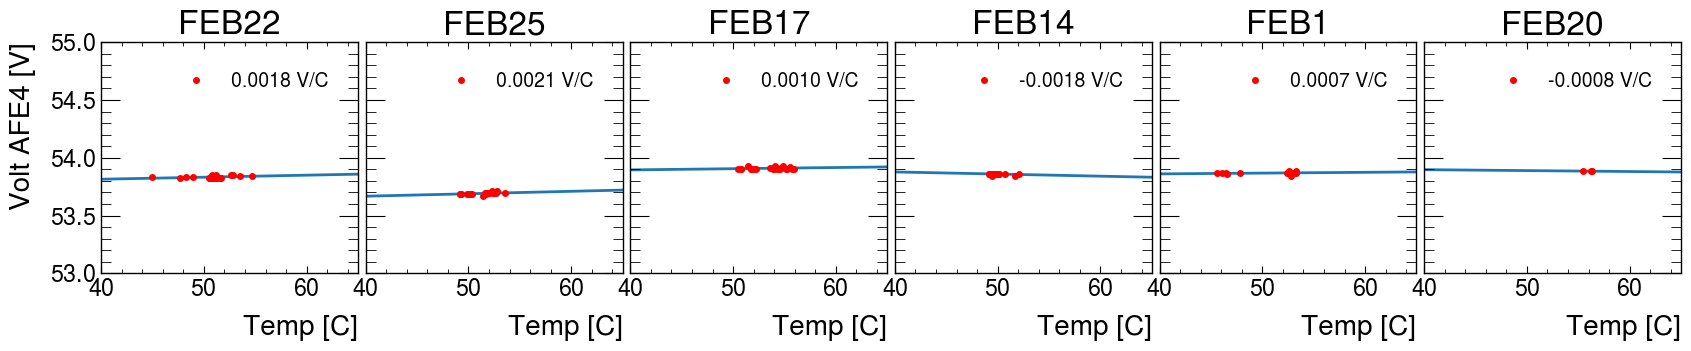

<Figure size 800x600 with 0 Axes>

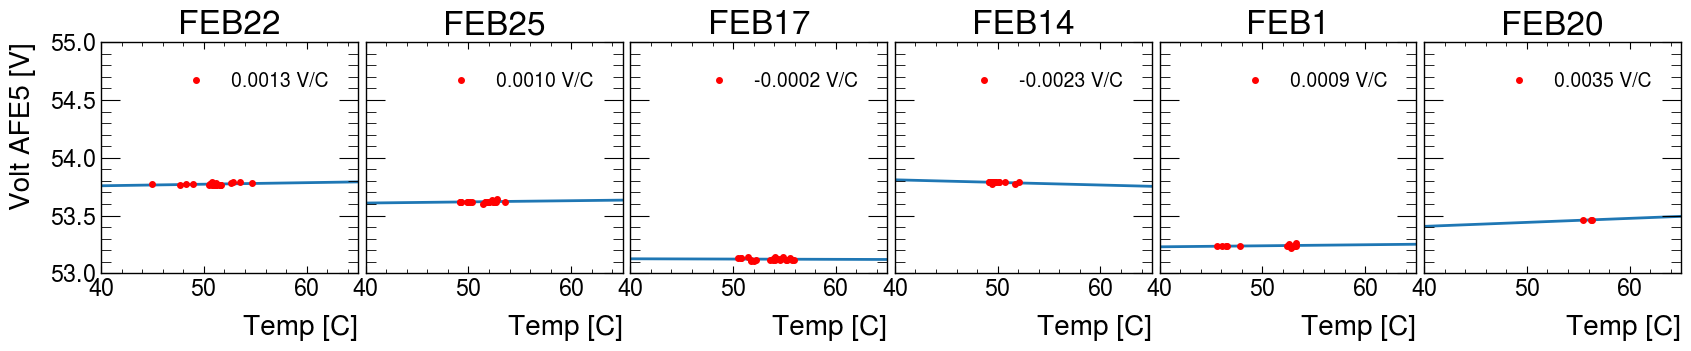

<Figure size 800x600 with 0 Axes>

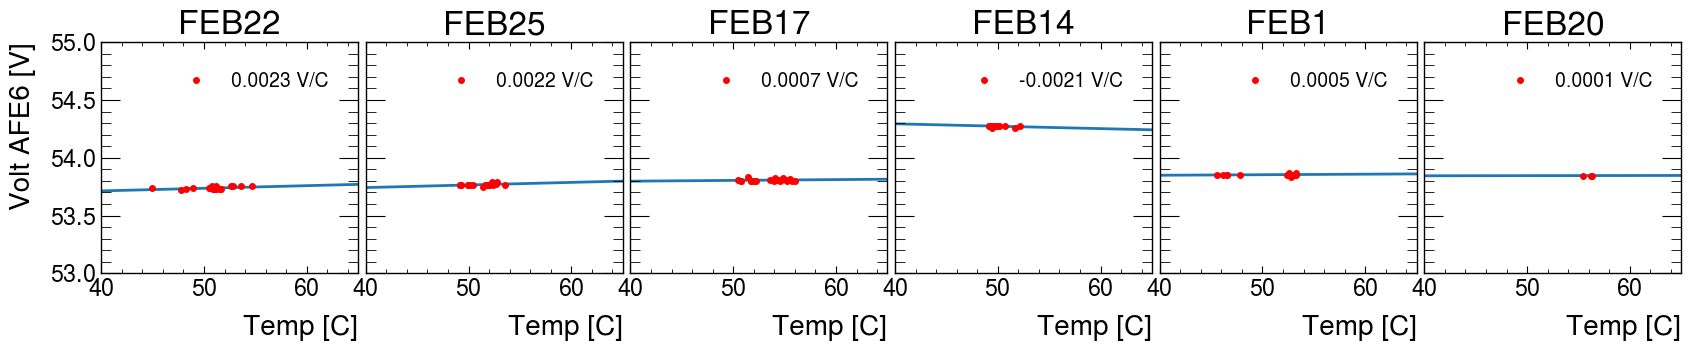

<Figure size 800x600 with 0 Axes>

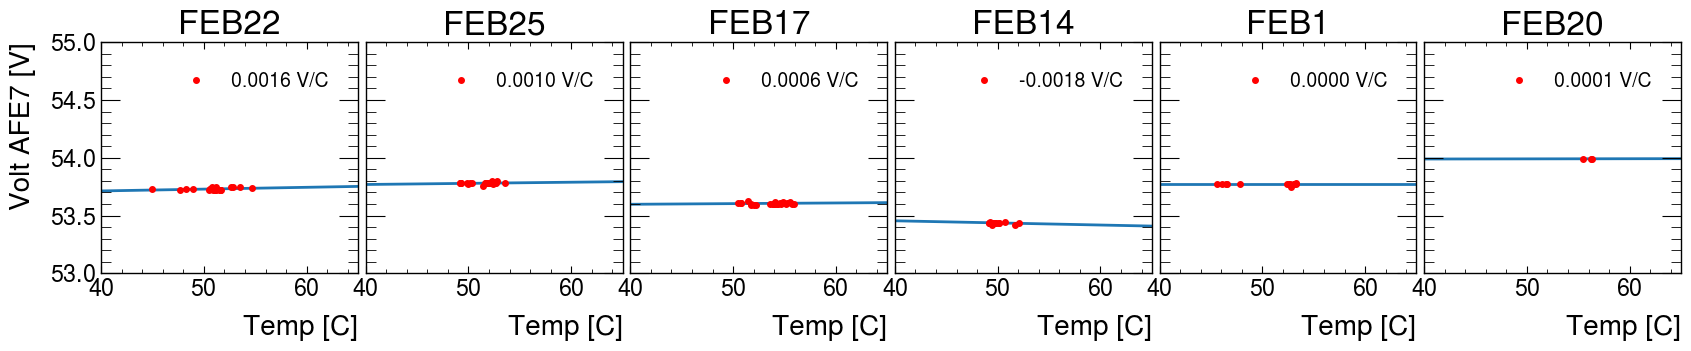

In [30]:
for i in range(0,8): # Loop thgough AFEs

  plt.figure()
  fig, ax1 = plt.subplots(nrows=1, ncols=6, figsize=(20, 3), sharey='row')
  plt.subplots_adjust(wspace=0.03)
  ax1[0].set_ylabel('Volt AFE%d [V]'%(i))


  for idx, feb in enumerate([22, 25, 17, 14, 1, 20]):

    cut = (ar['febID'] == feb)
    x=ar["febTemperaturesAvg", cut]
    y=ar["biasVoltagesAvg", cut]

    x=x[ak.num(x) > 0, 0].to_numpy()    
    y=y[ak.num(y) > 0, 0].to_numpy()[:,i]
    
    linmodel = np.poly1d(np.polyfit(x, y, 1))
    xline = np.linspace(40, 65, 100)
    ax1[idx].plot(xline, linmodel(xline))
    ax1[idx].plot(x,y,'r.', label='%.4f V/C'%linmodel.coeffs[0])

    ax1[idx].set_xlabel('Temp [C]')
    
    ax1[idx].set_xlim(40,65)
    ax1[idx].set_ylim(53,55)
    ax1[idx].legend()
    ax1[idx].set_title('FEB%d'%feb)

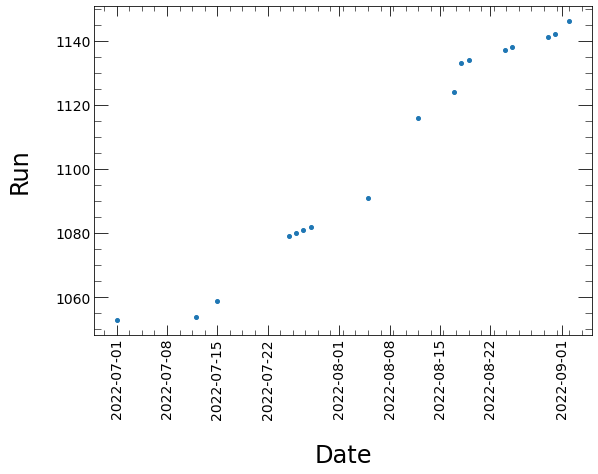

In [ ]:
plt.plot(df['date'], df['run'], '.')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Run');

In [37]:
np.arange(x.min(), x.max(), 10000).shape

(689,)

Make plots

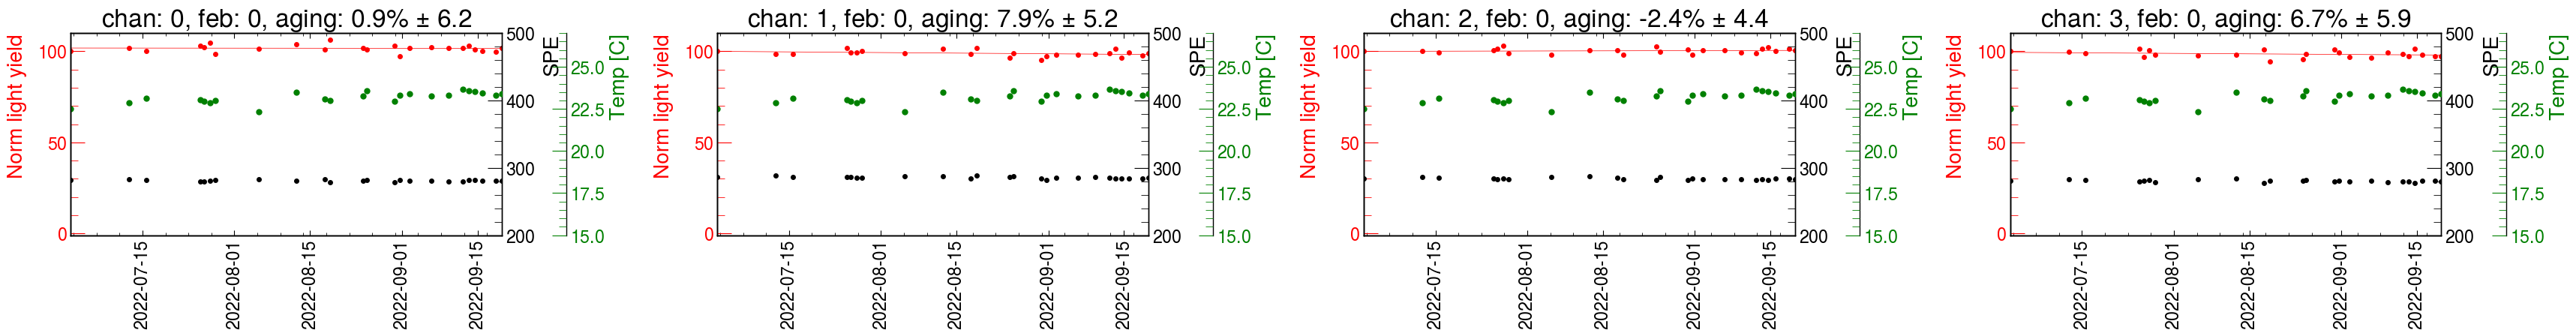

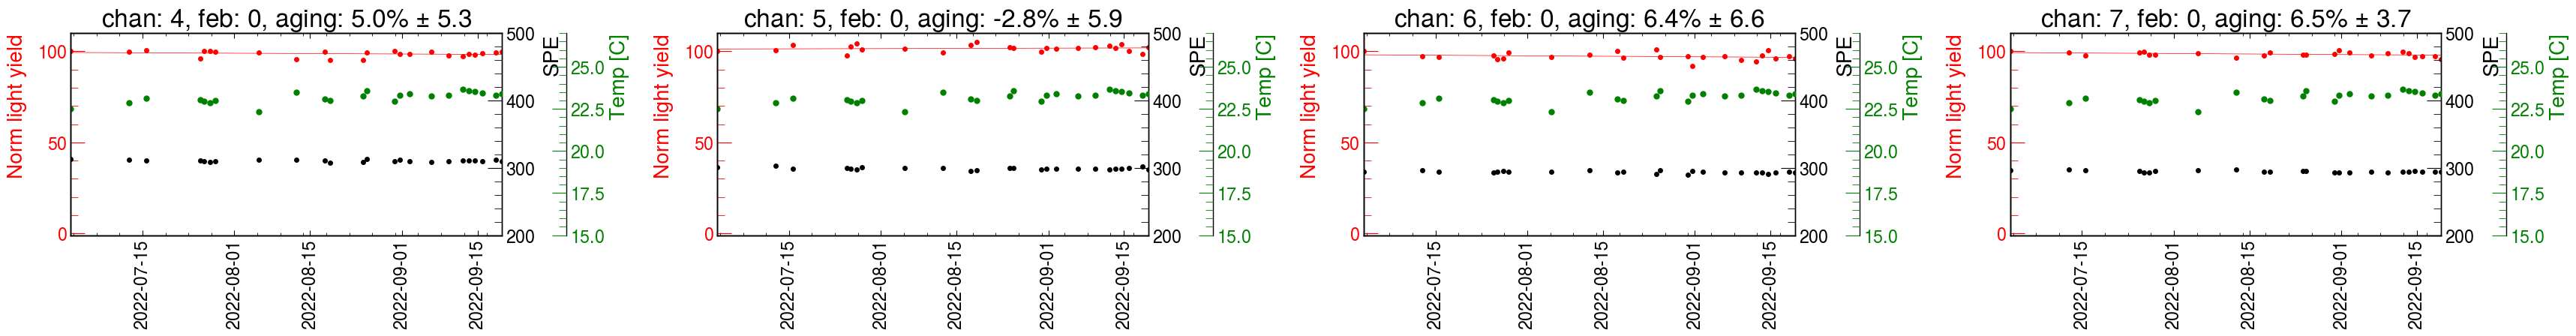

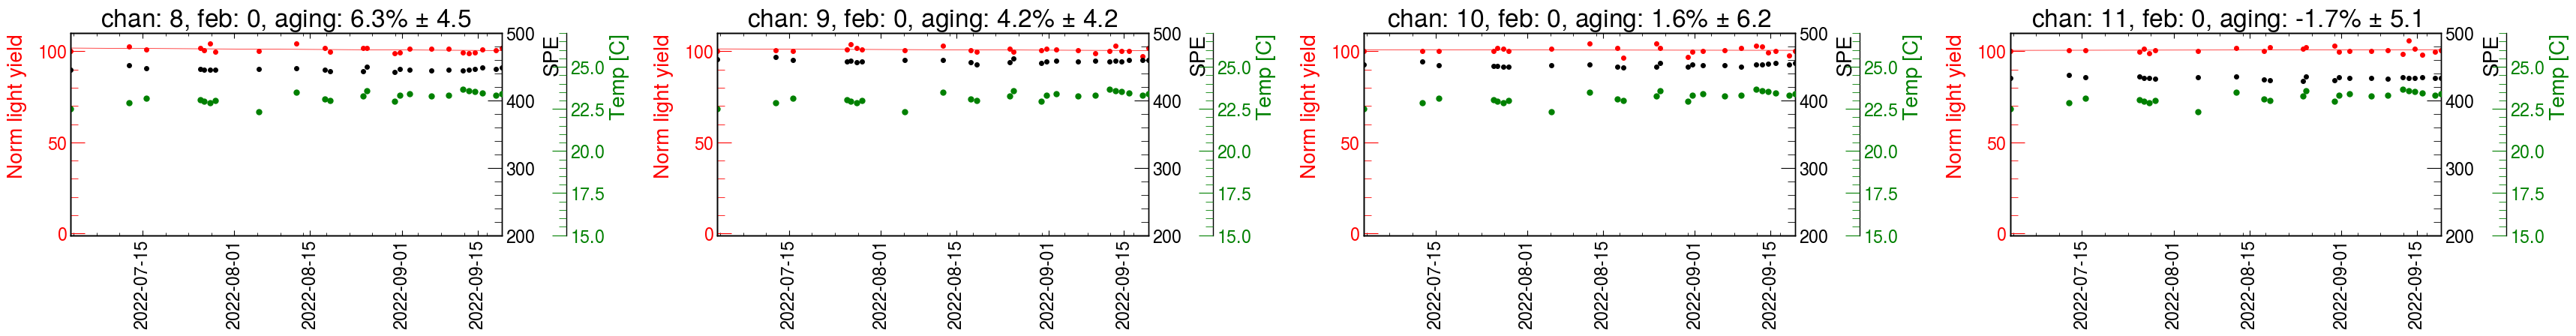

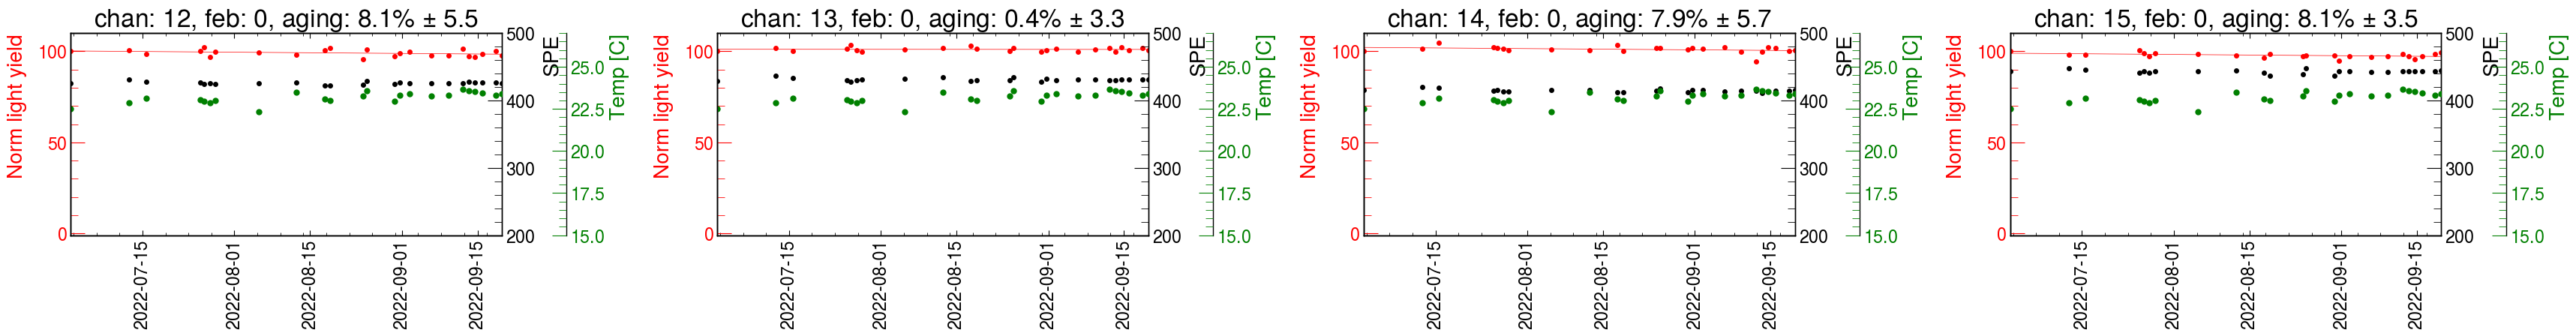

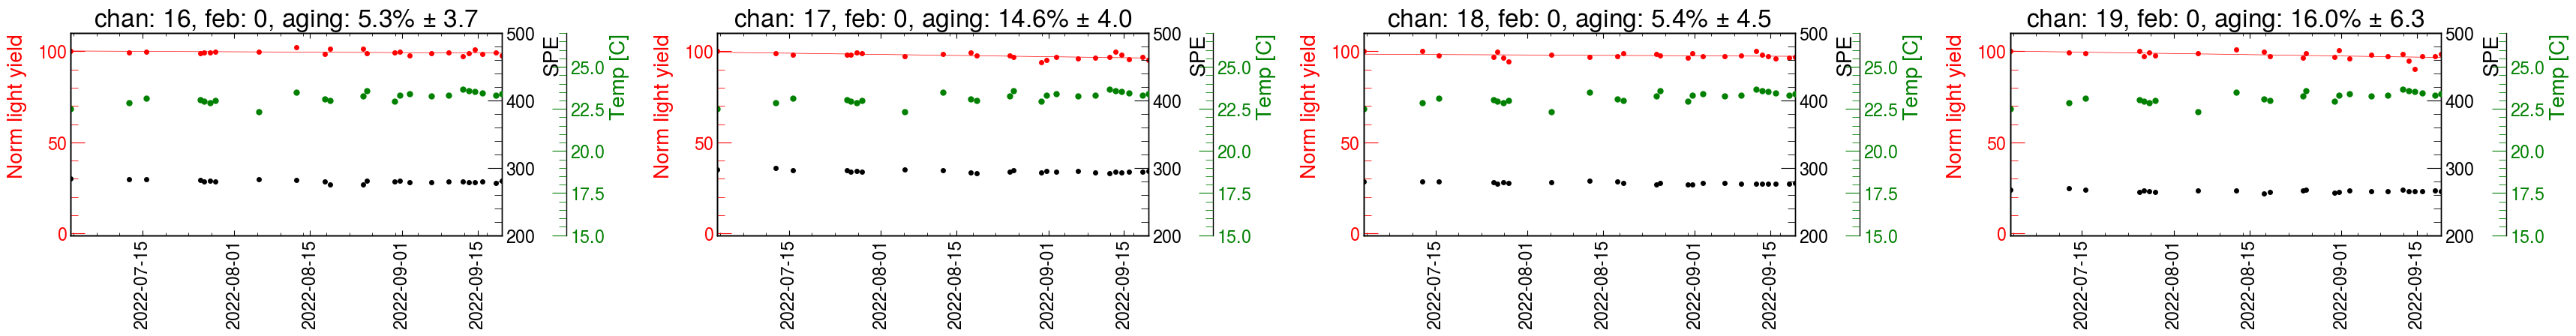

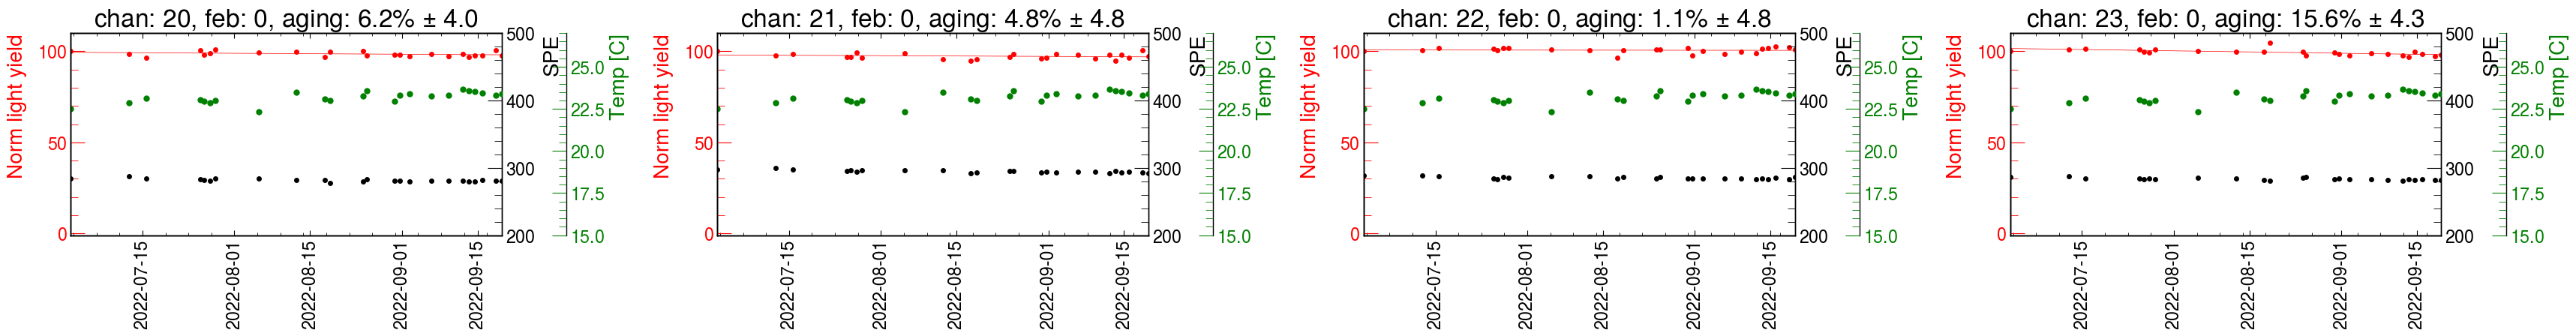

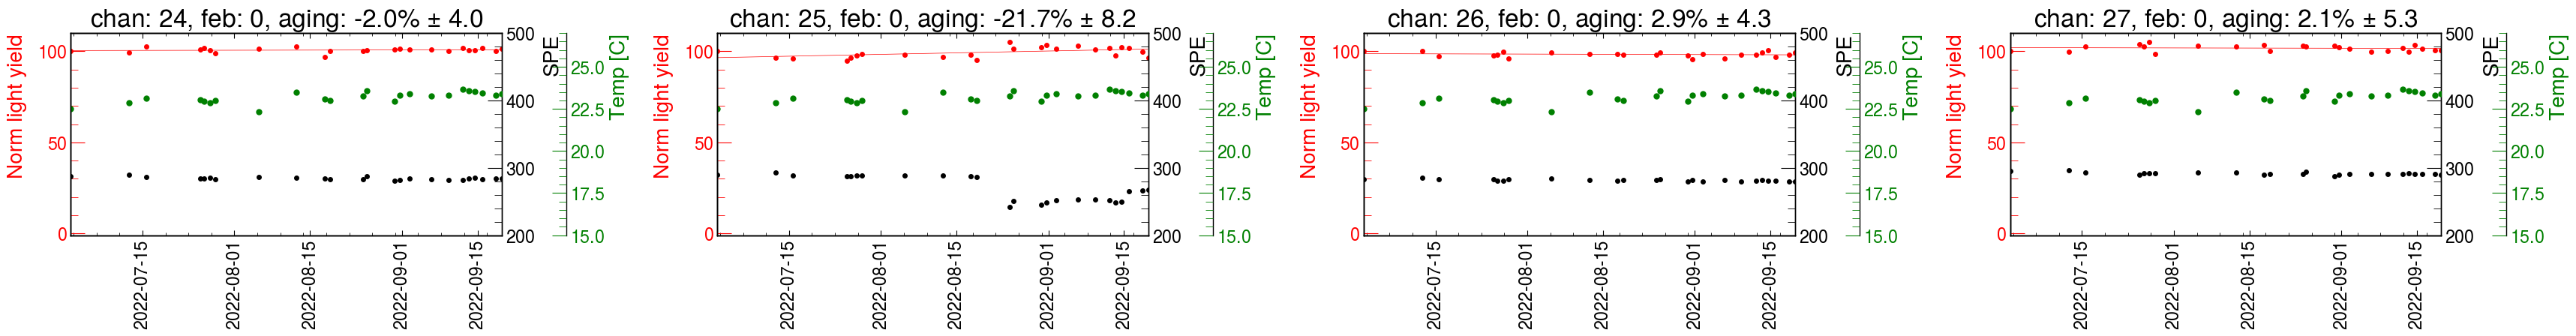

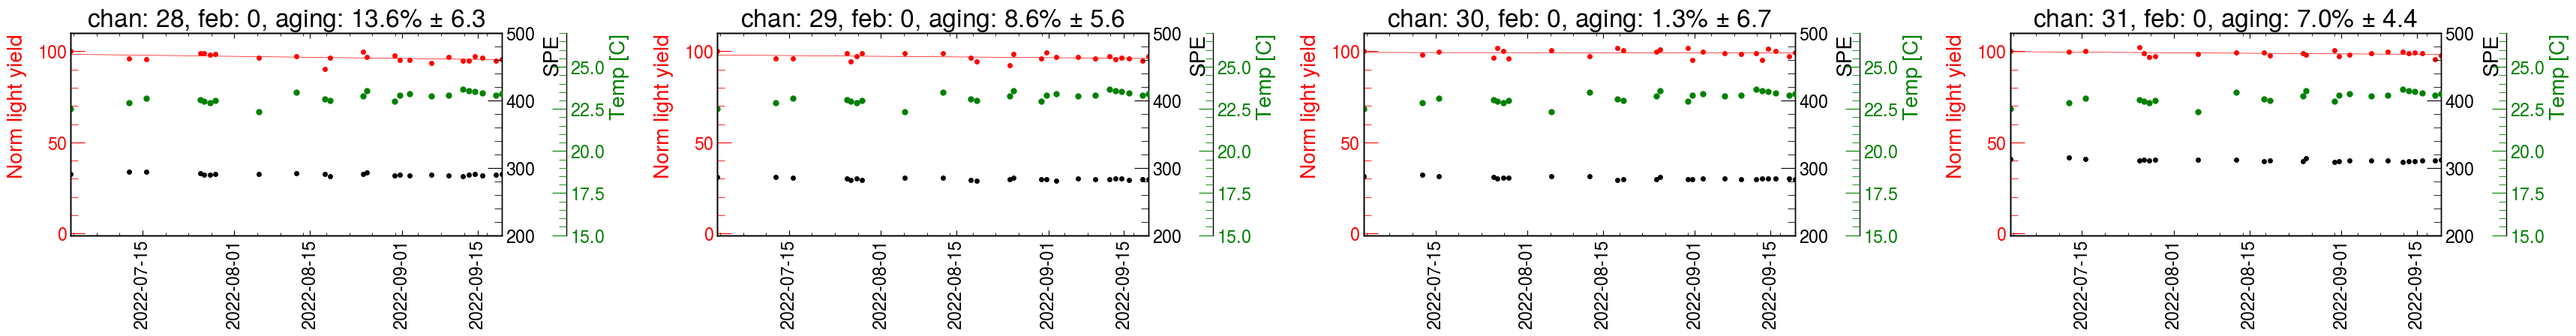

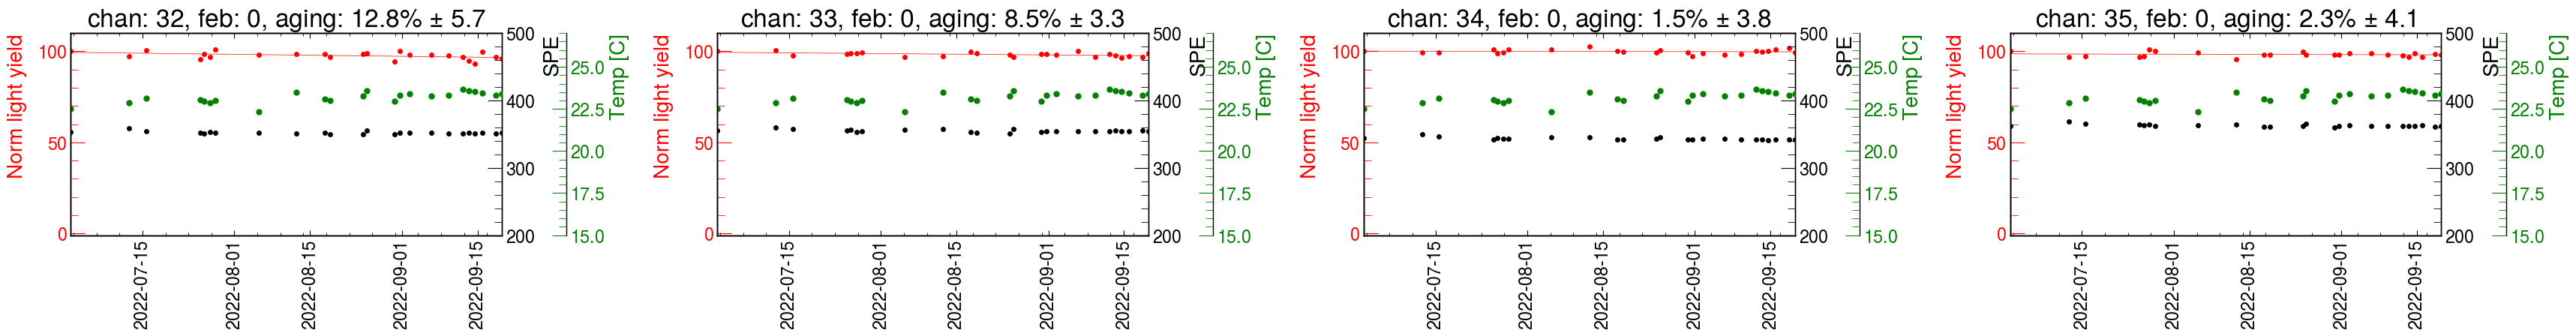

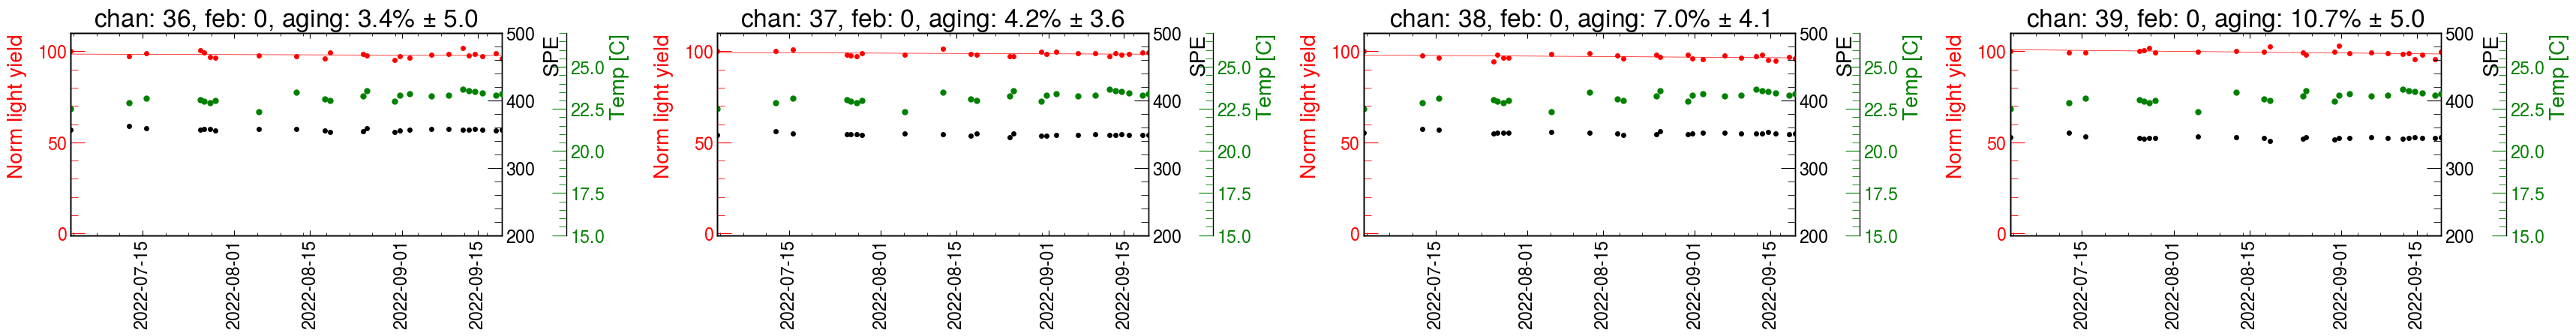

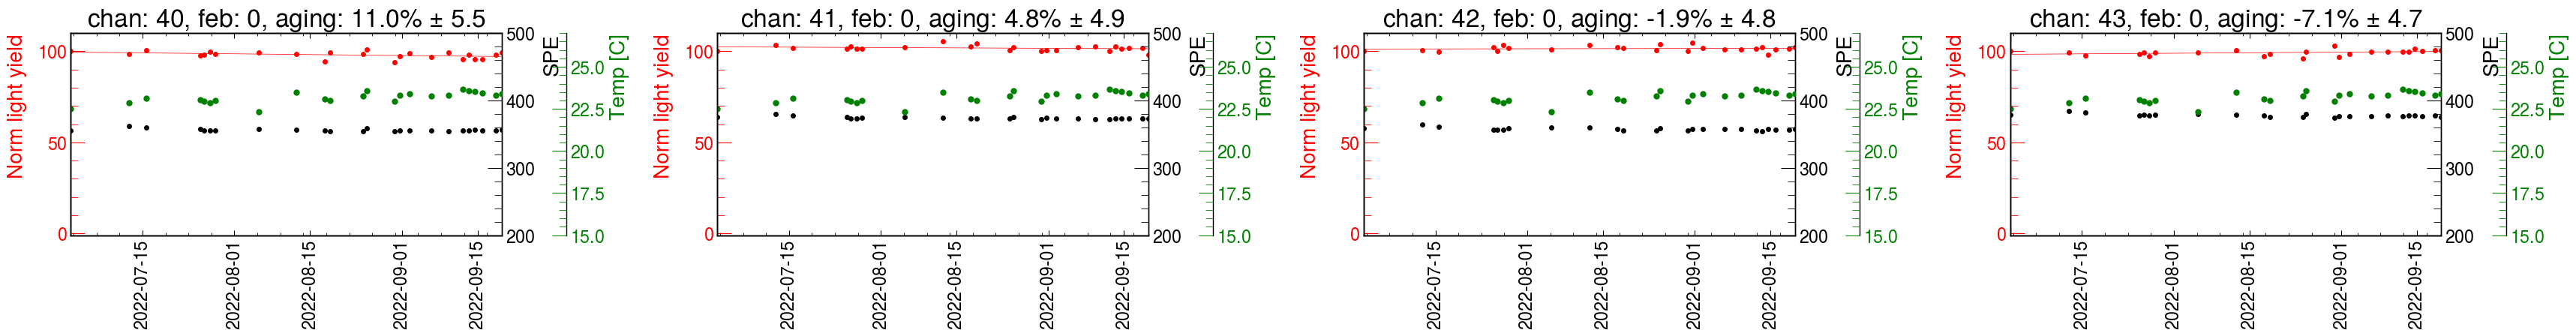

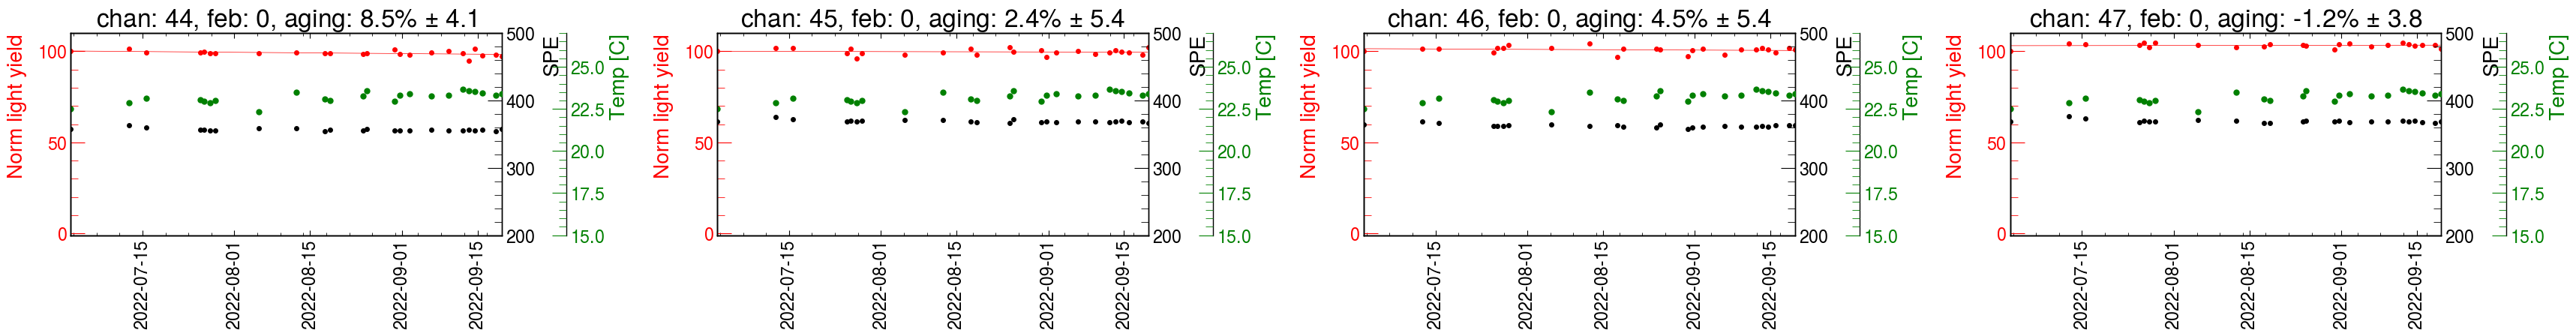

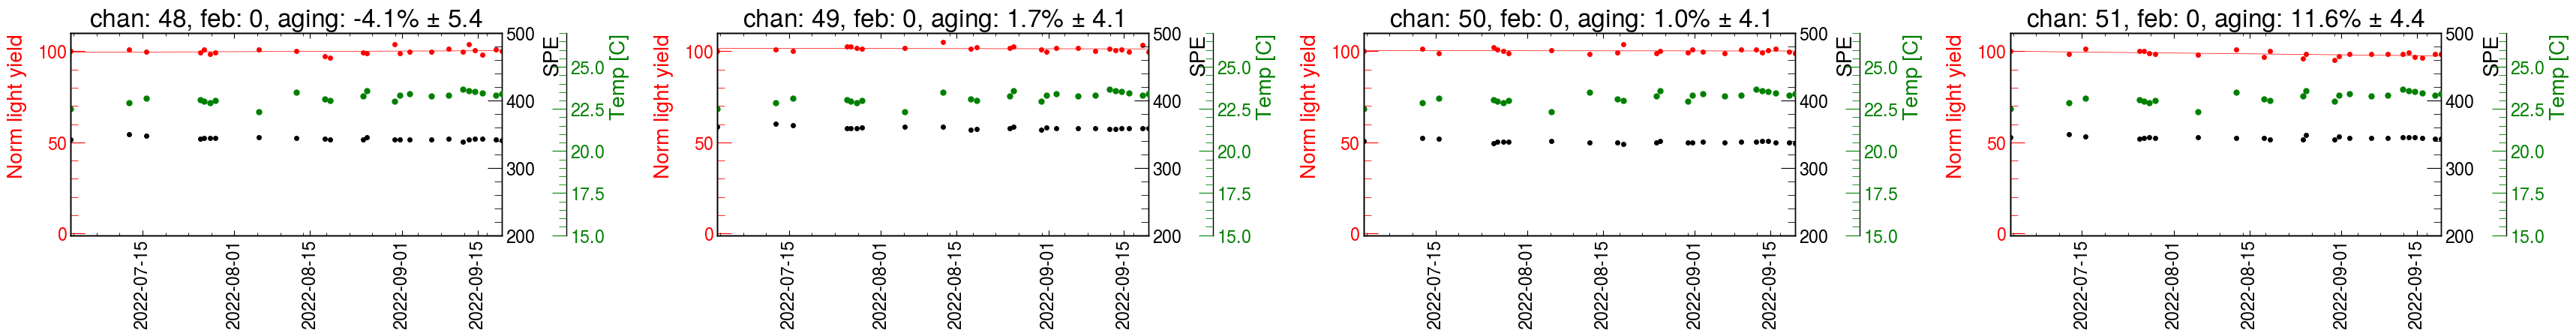

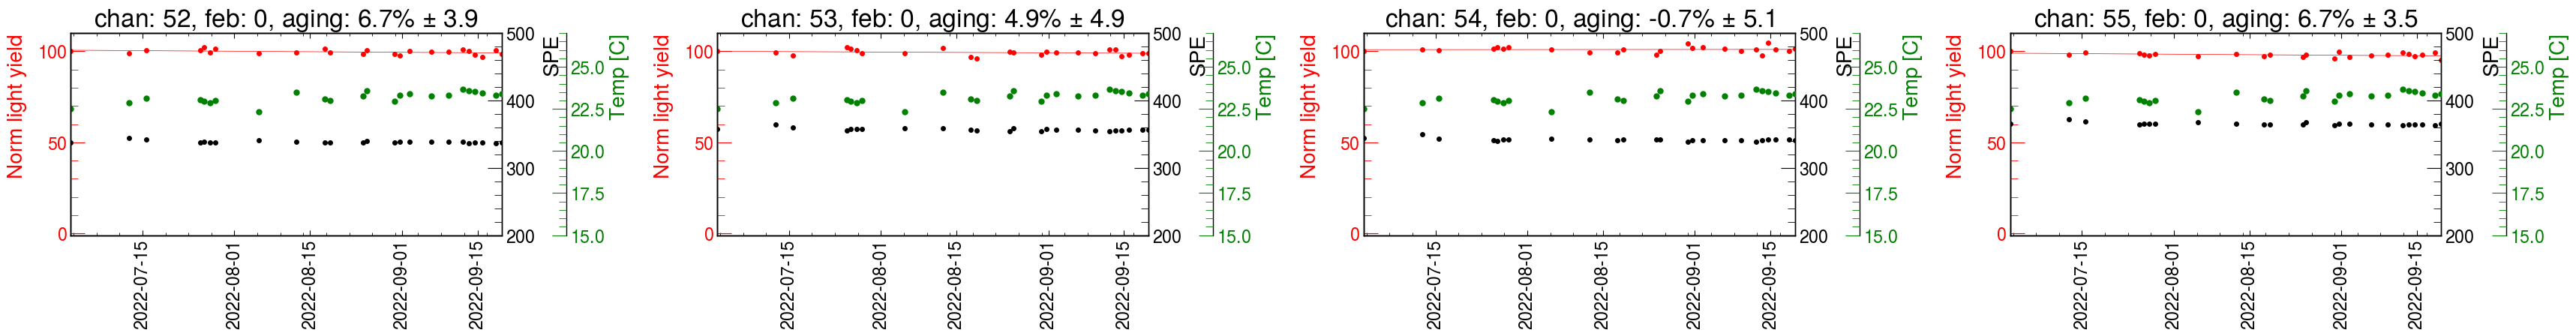

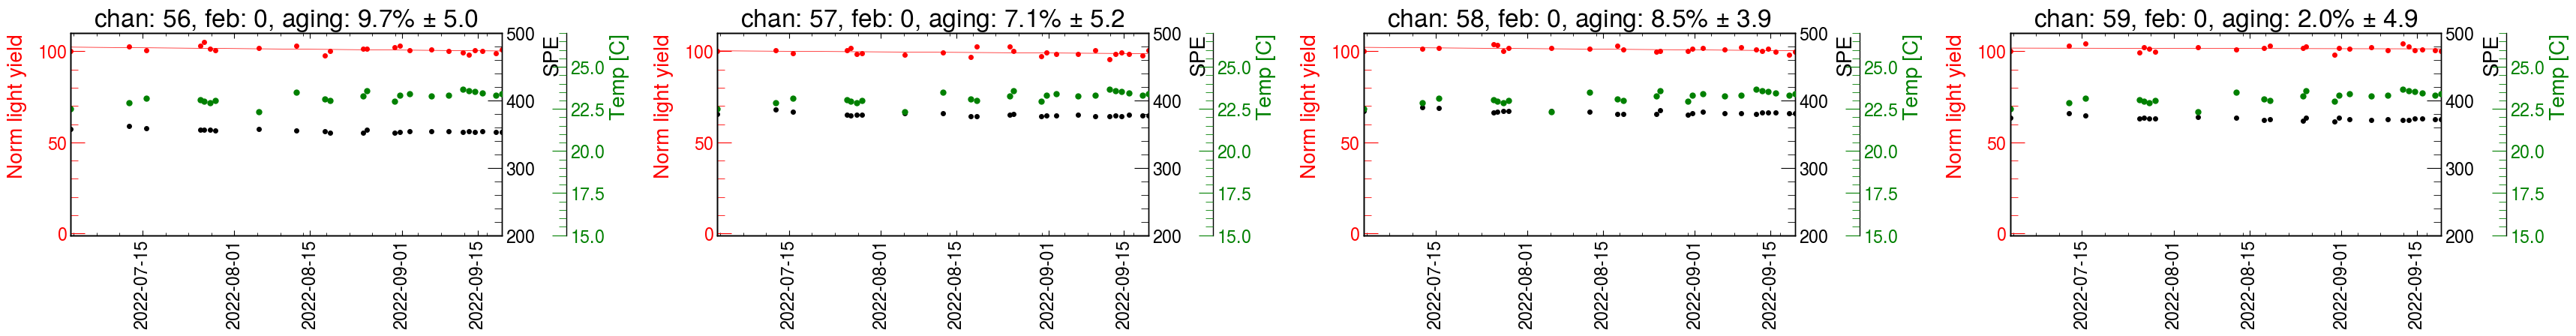

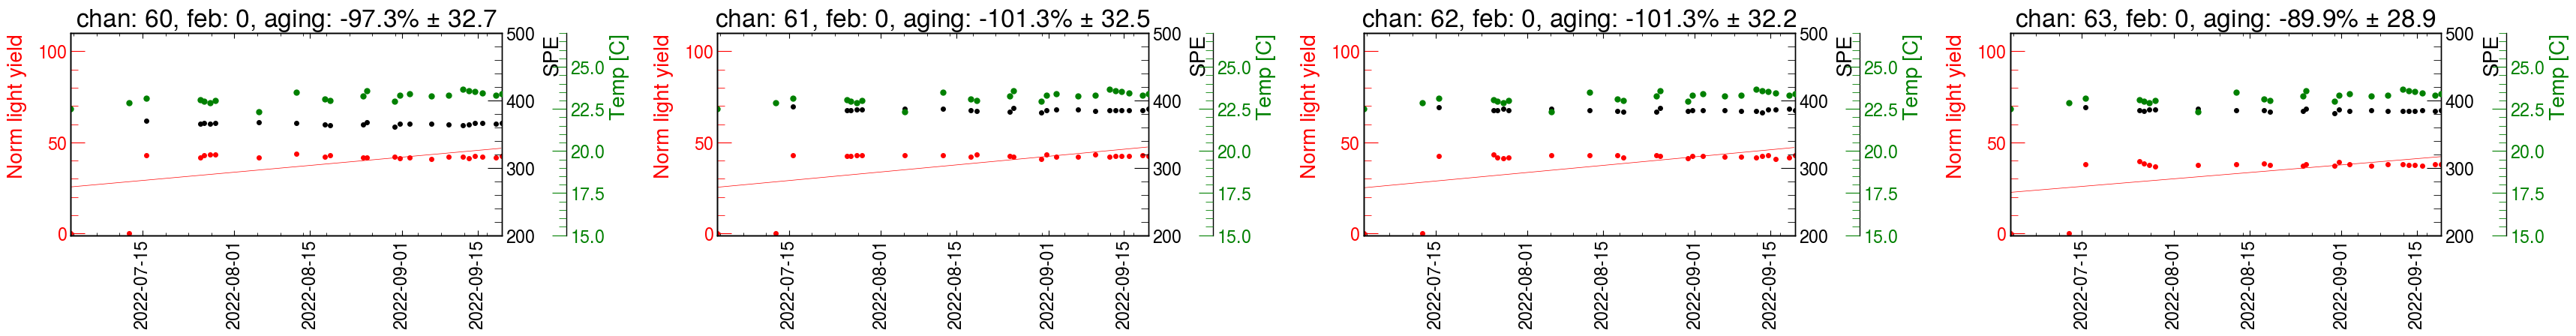

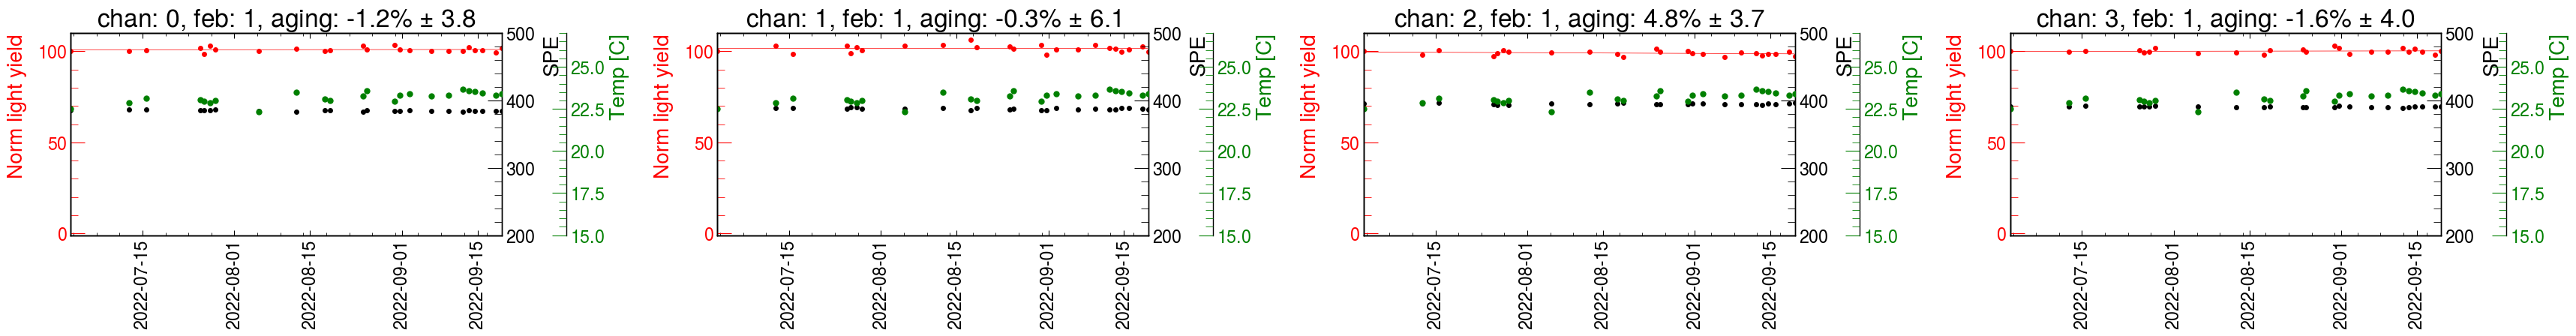

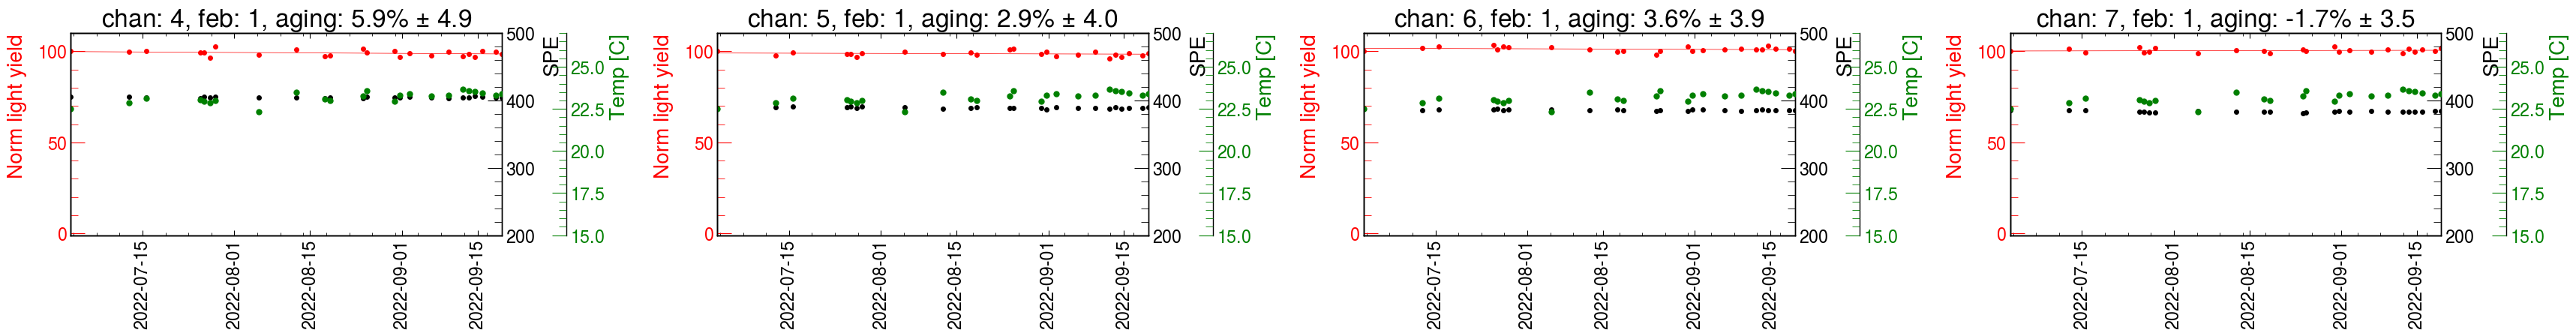

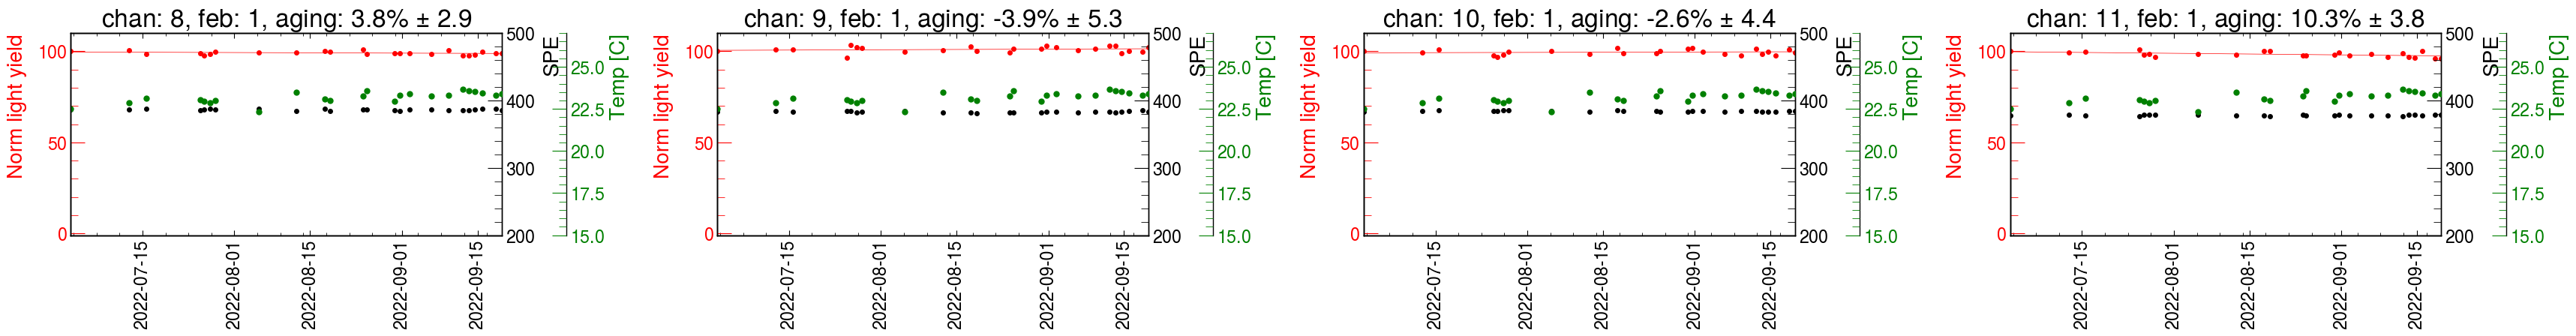

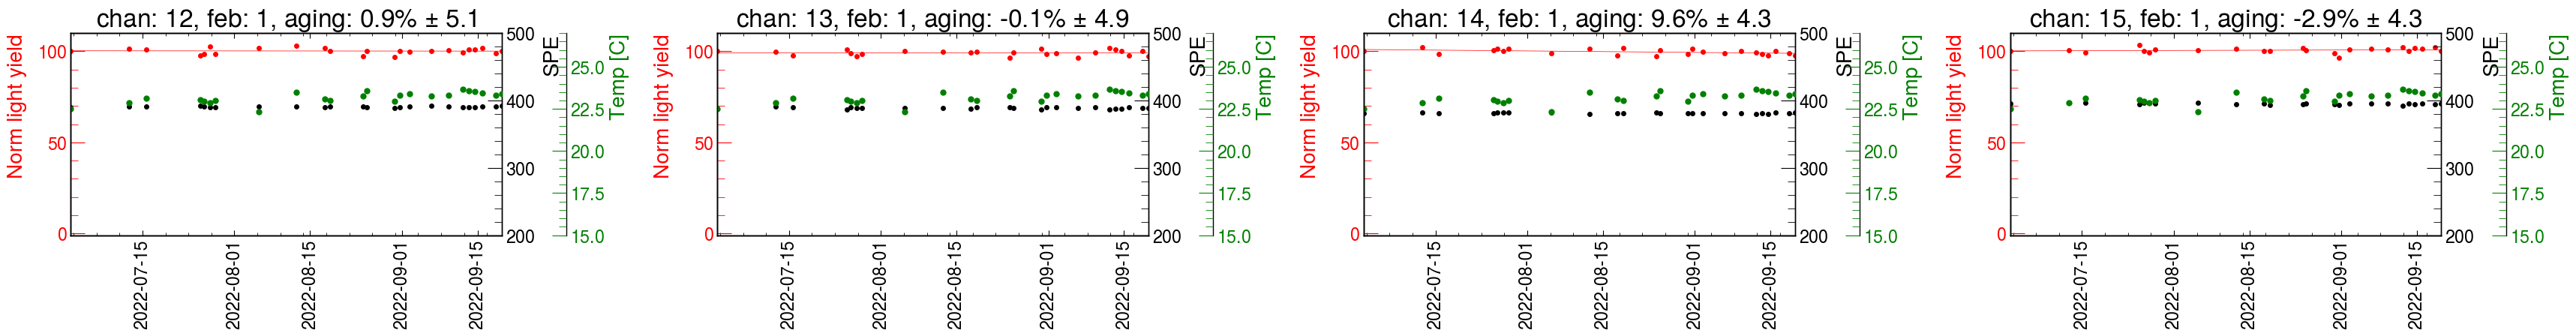

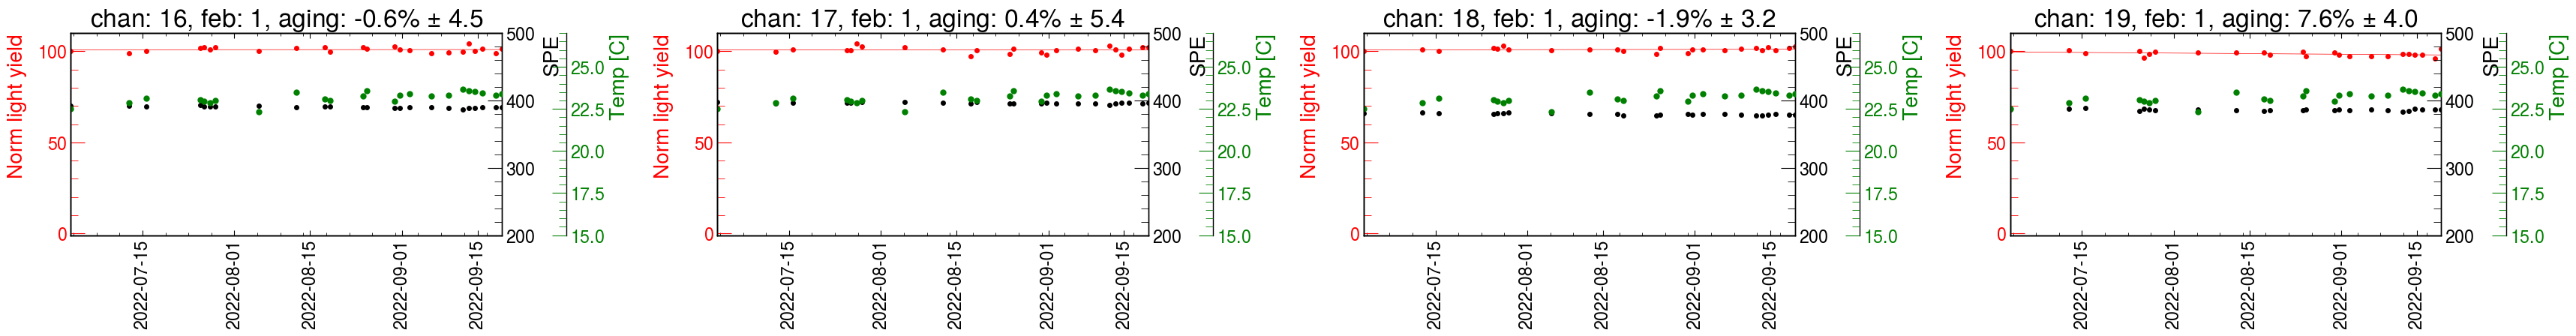

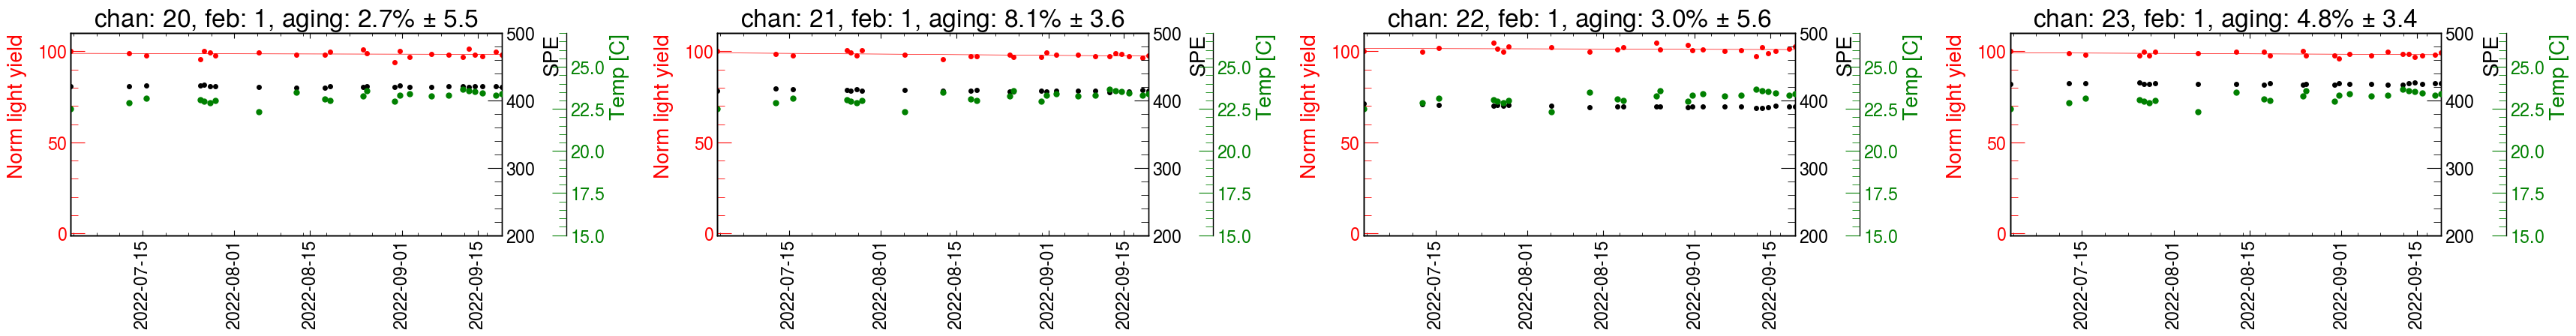

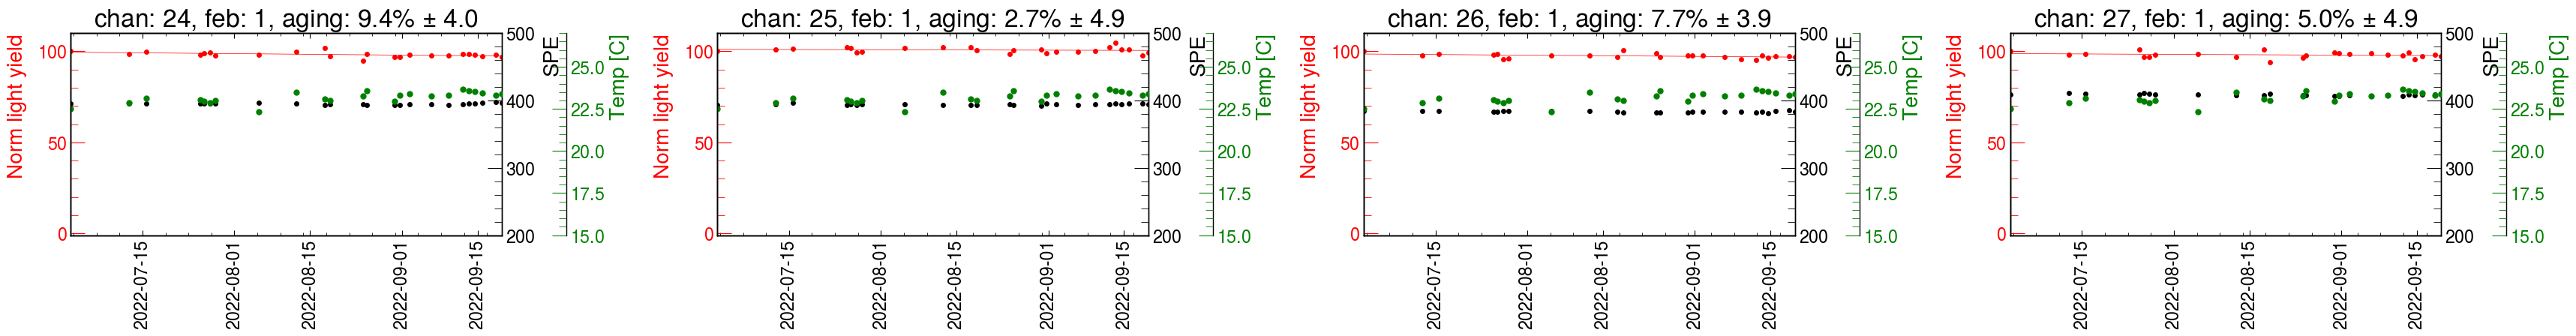

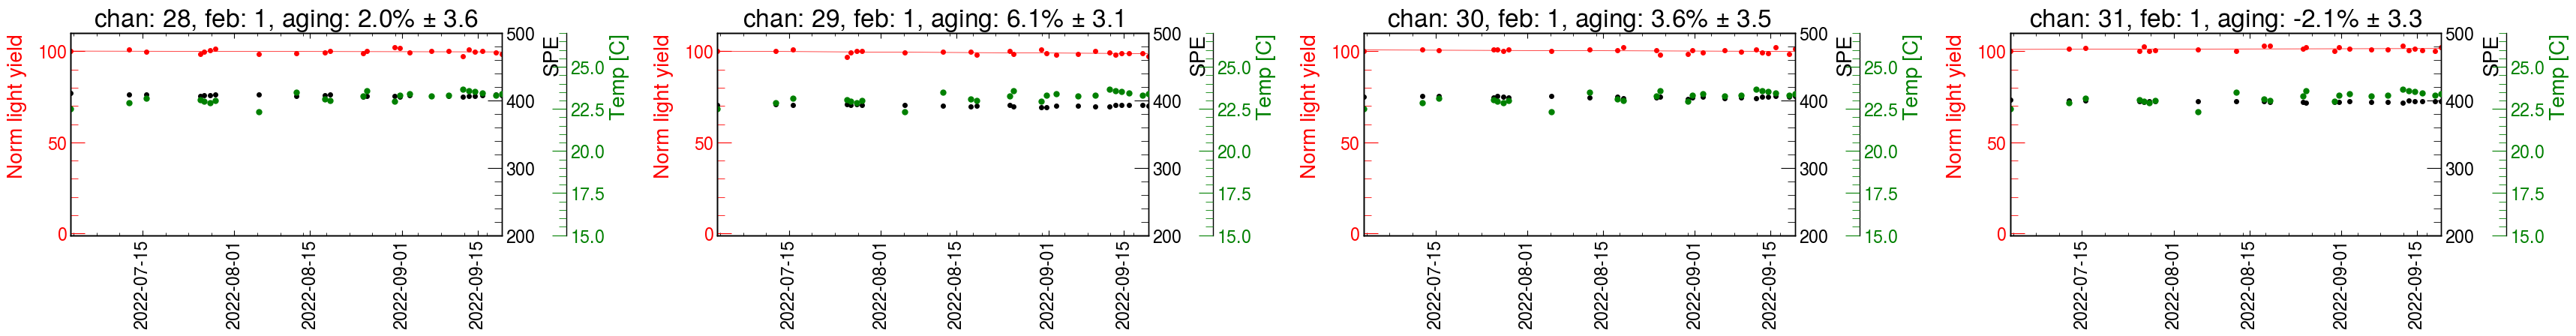

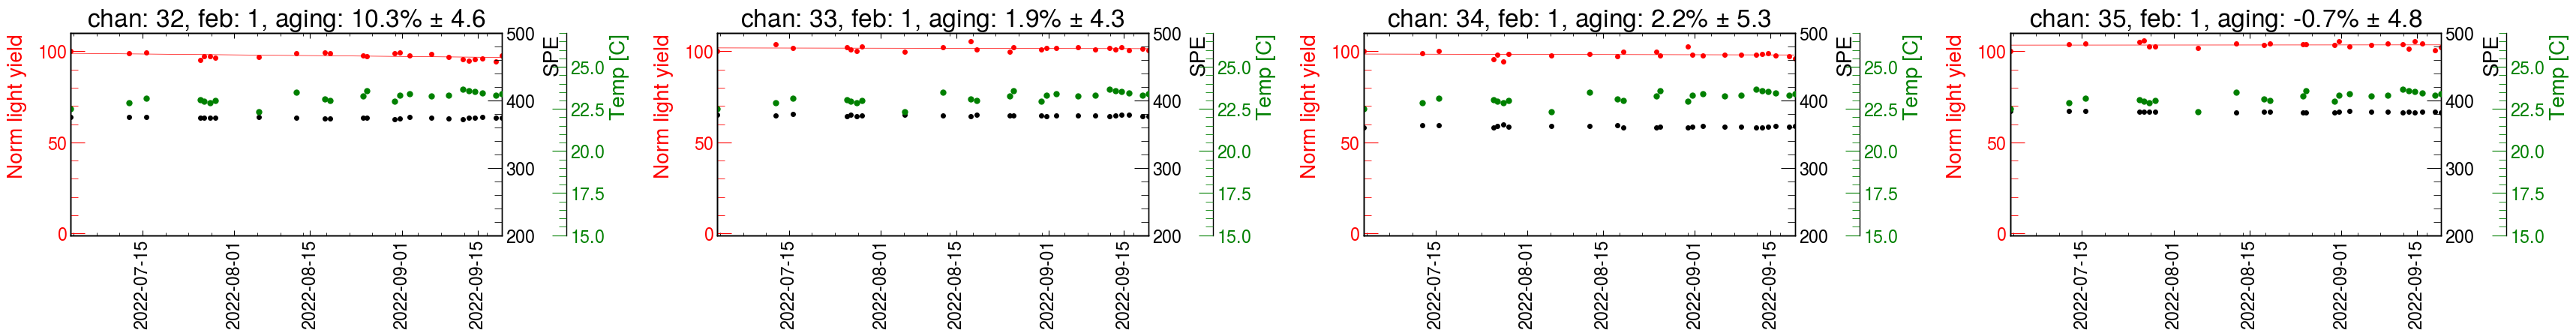

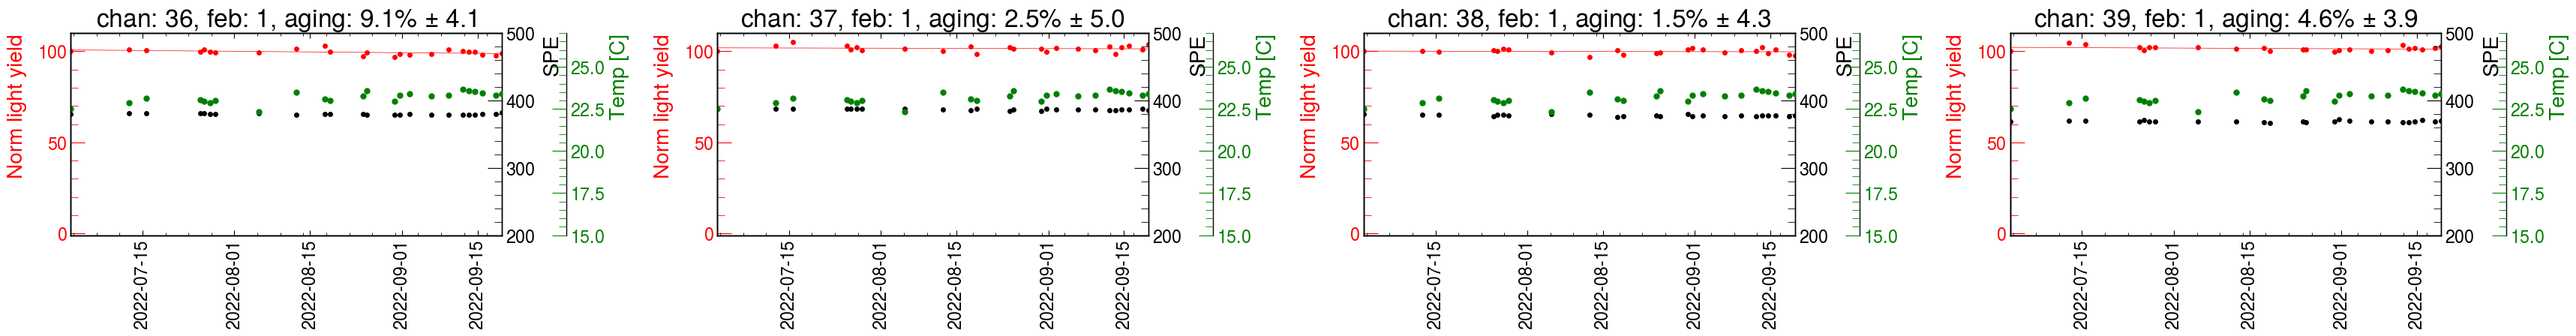

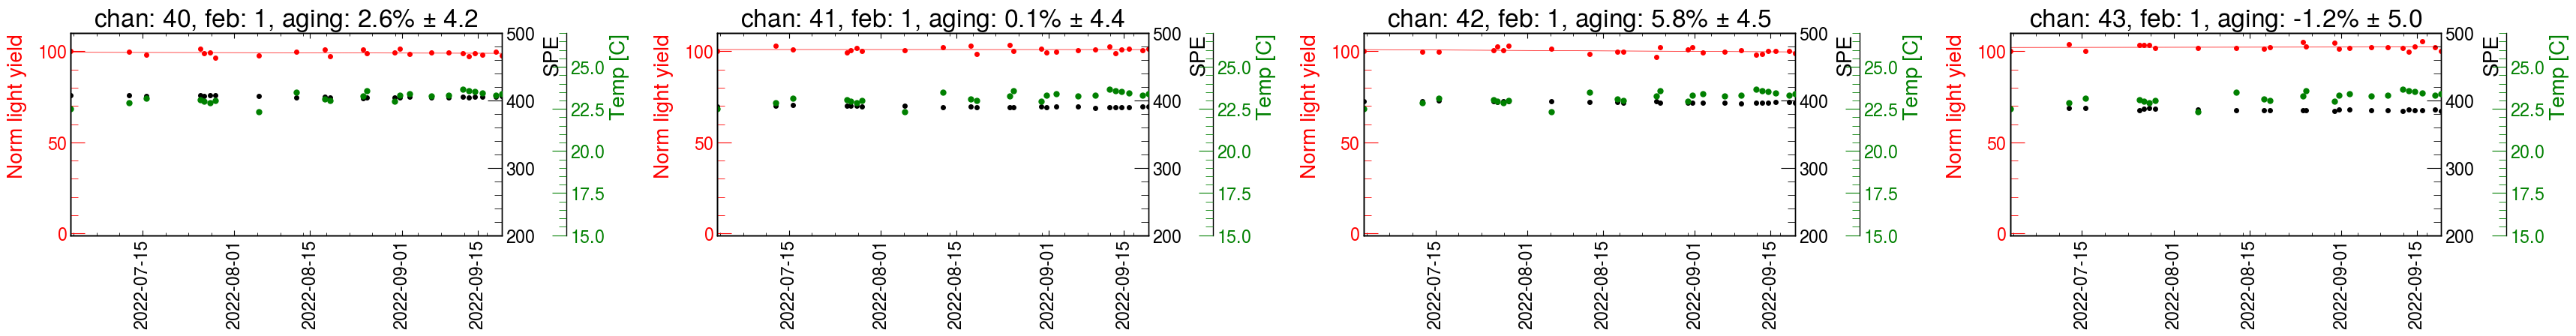

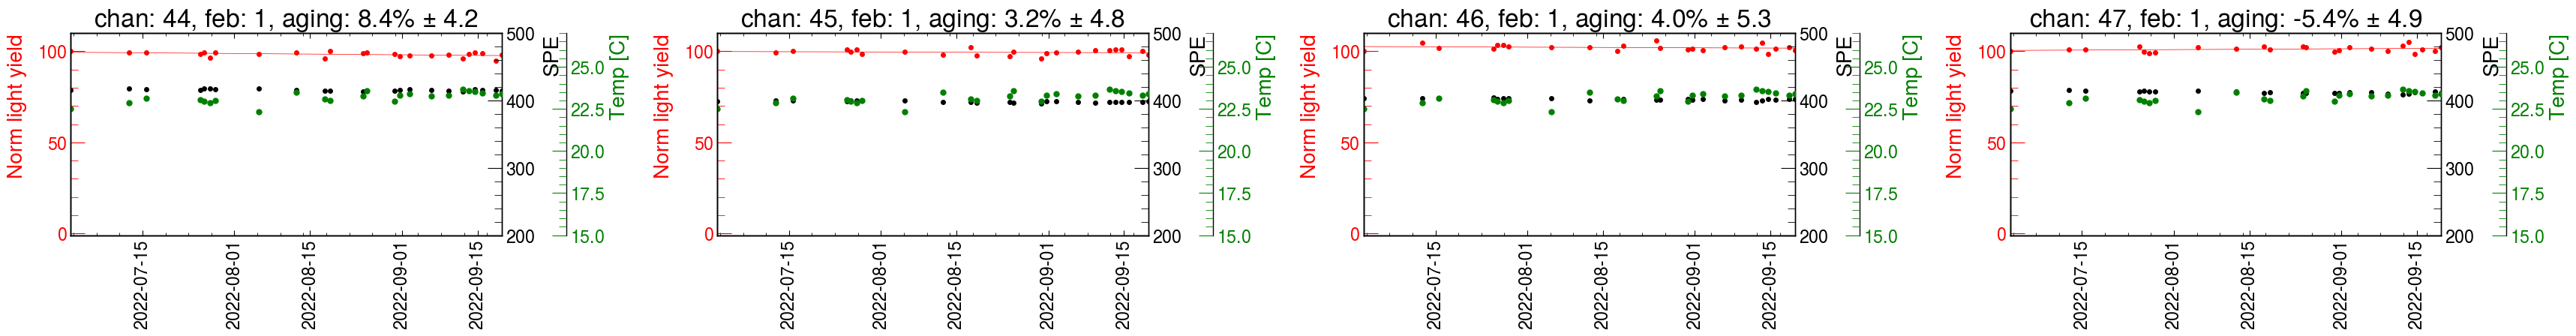

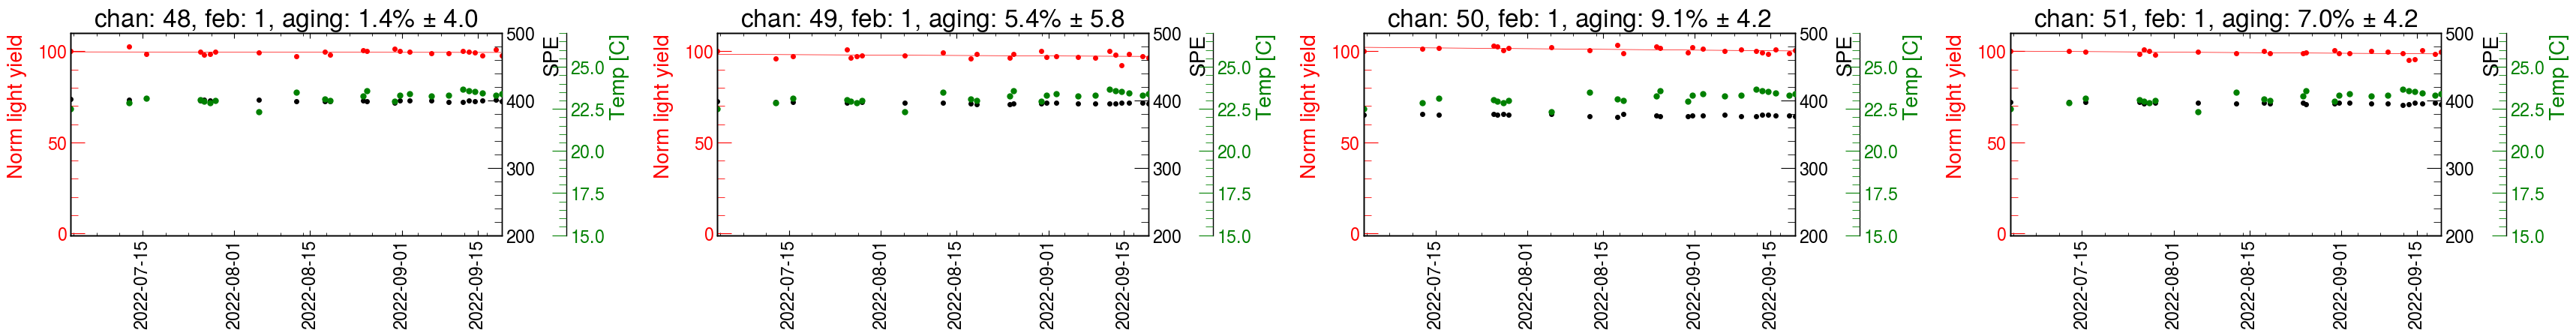

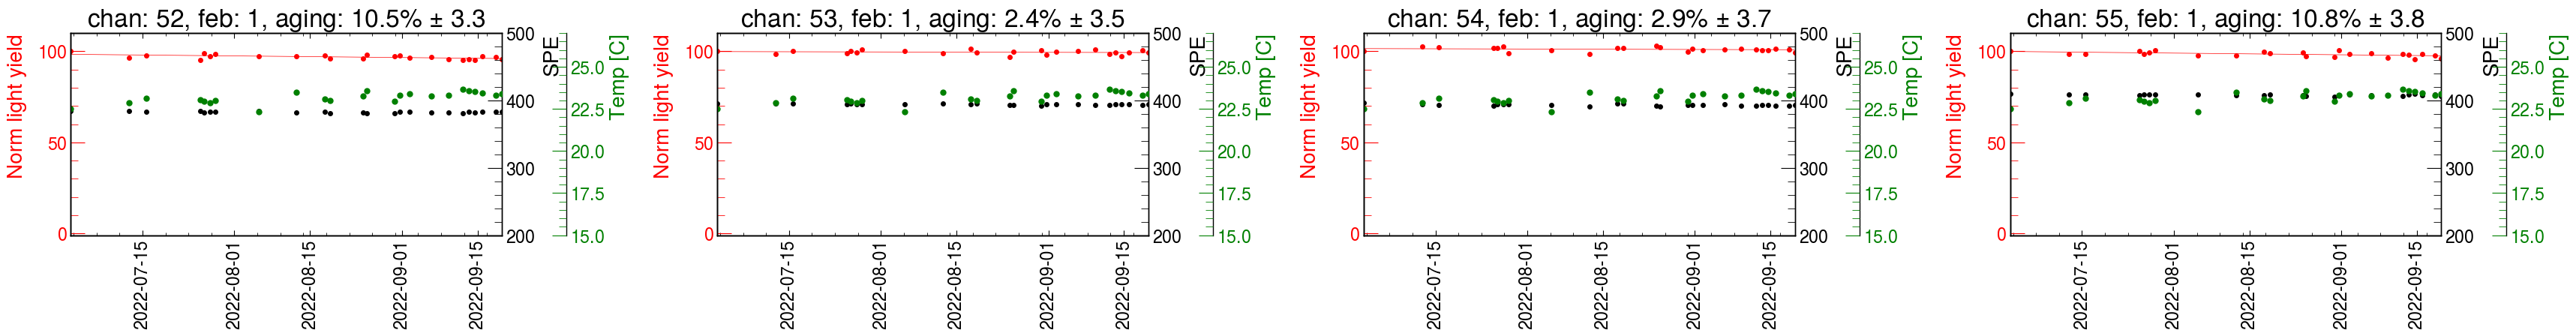

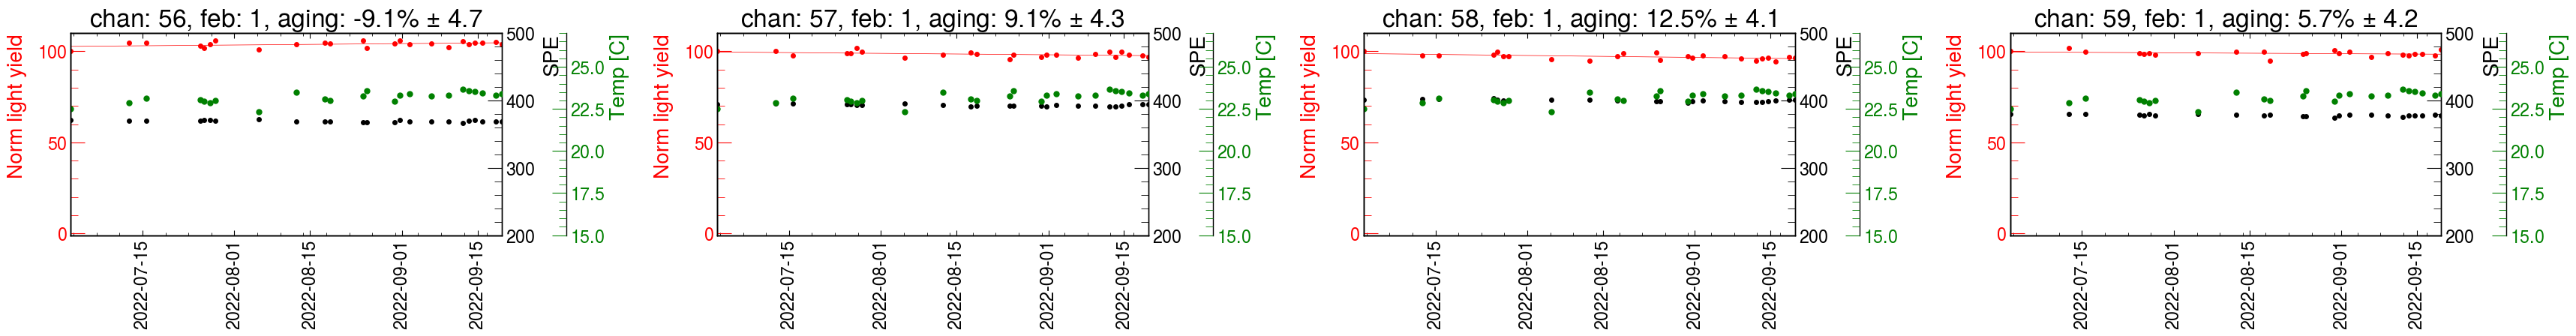

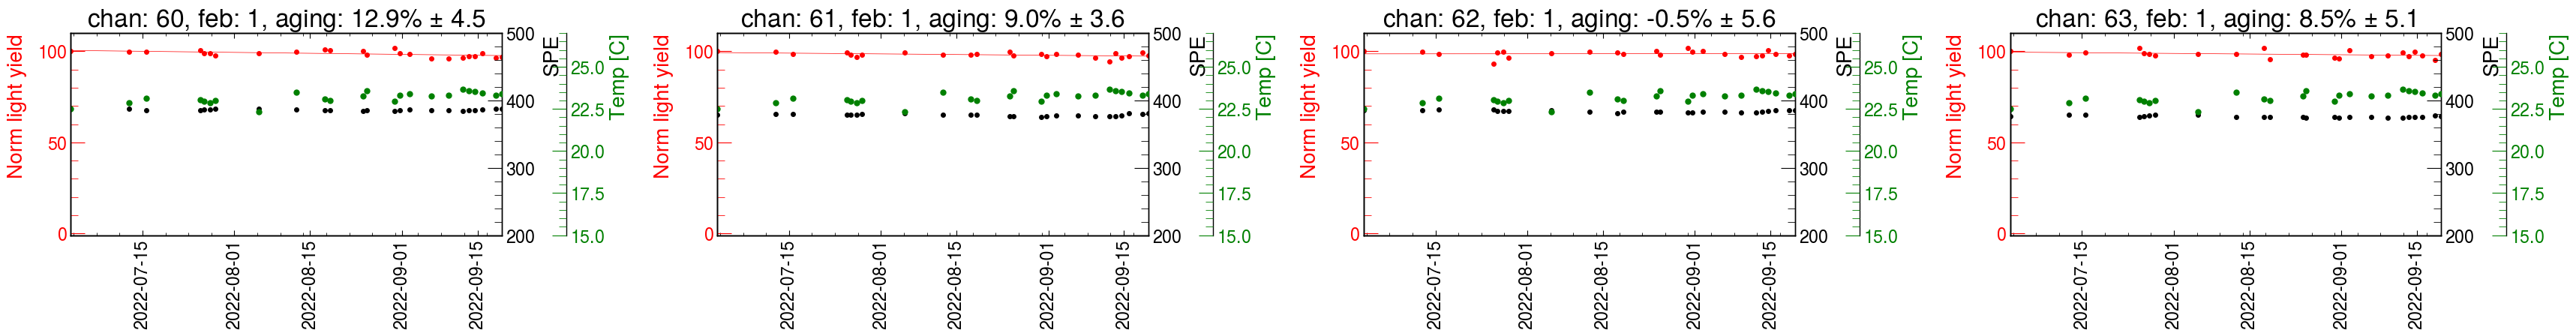

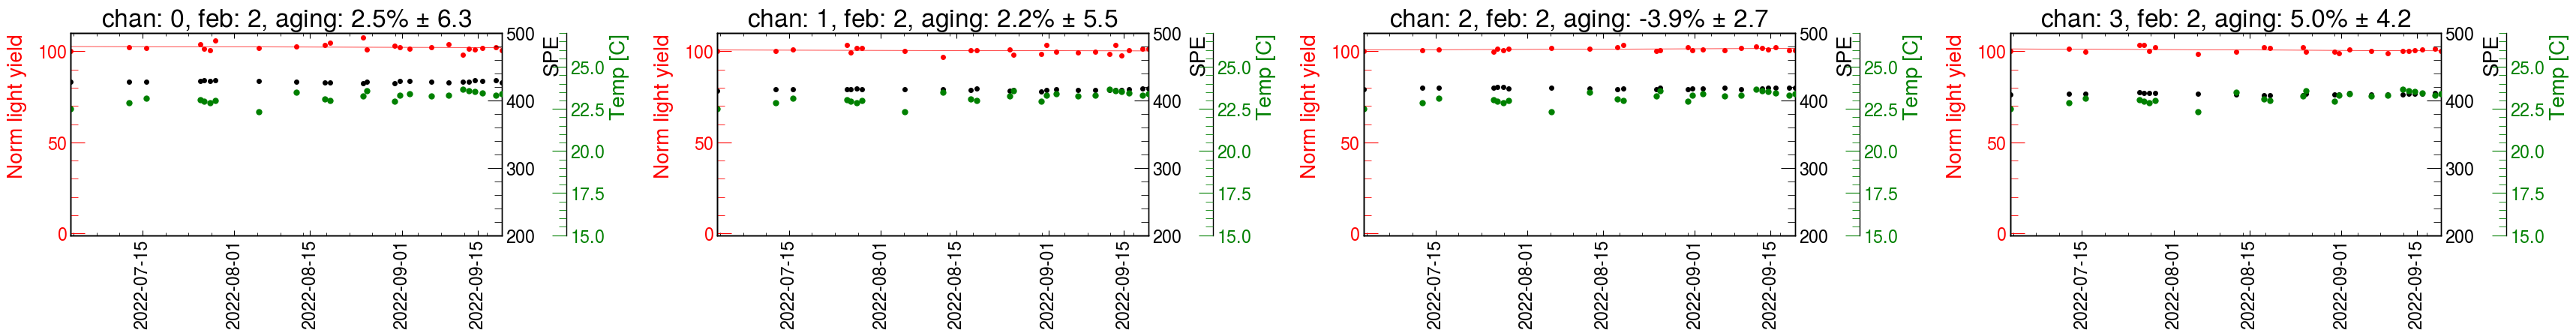

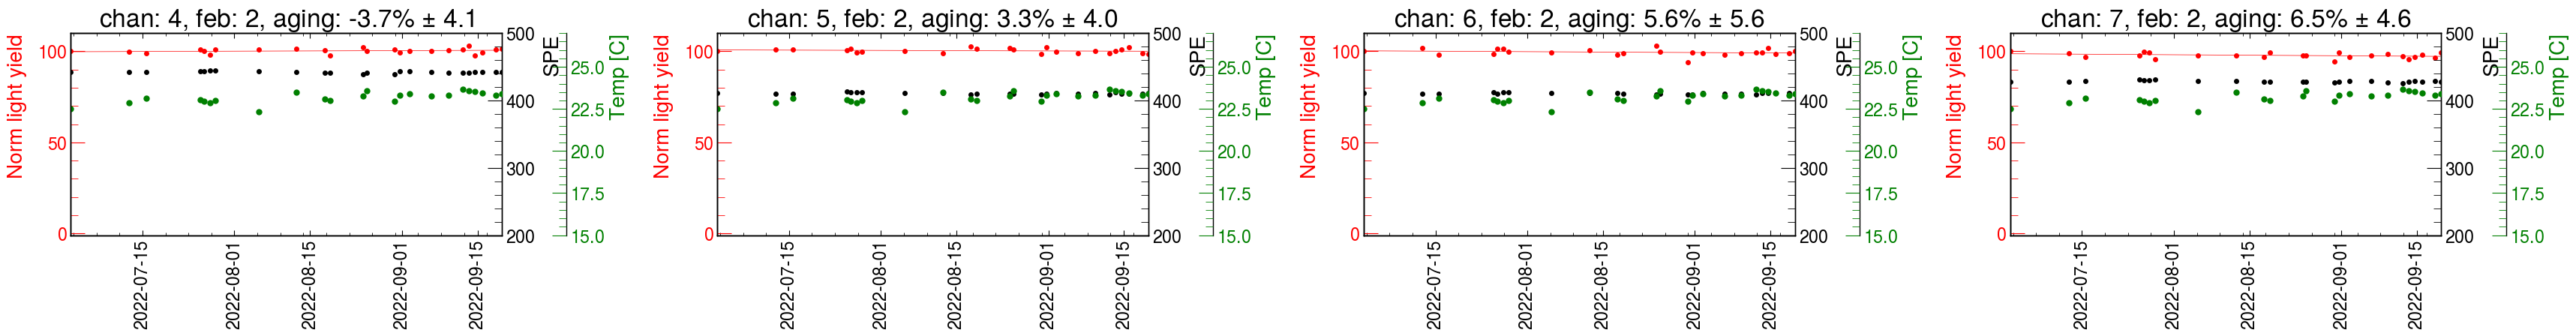

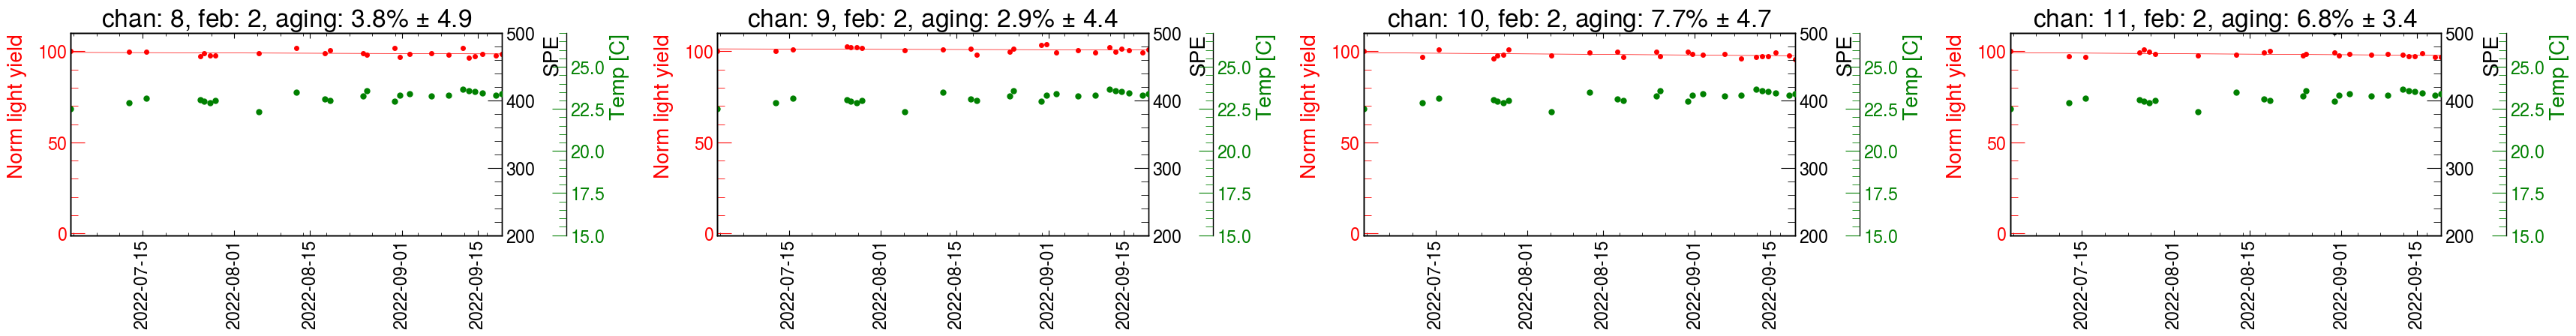

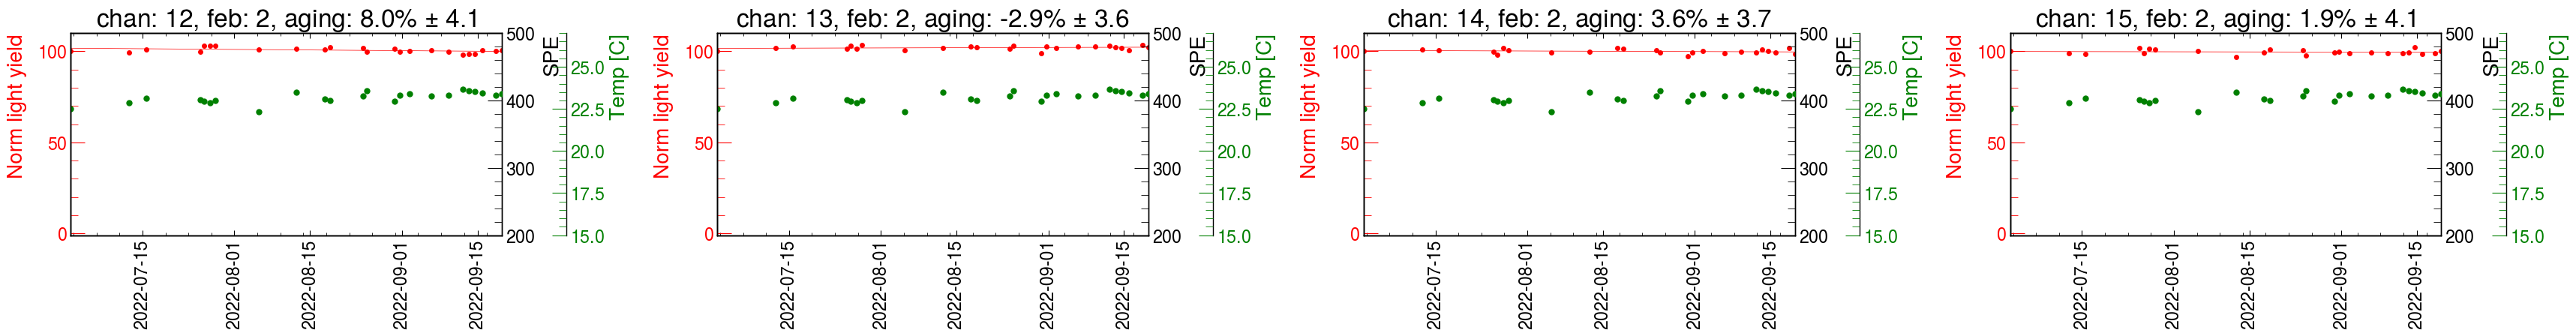

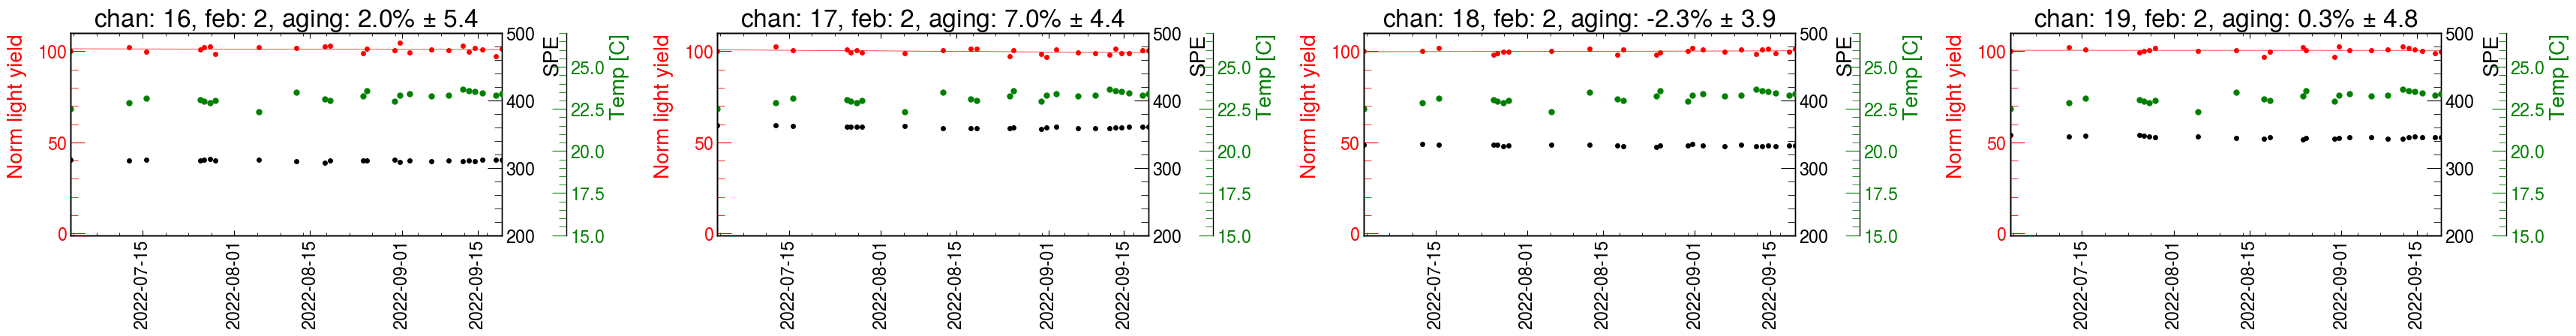

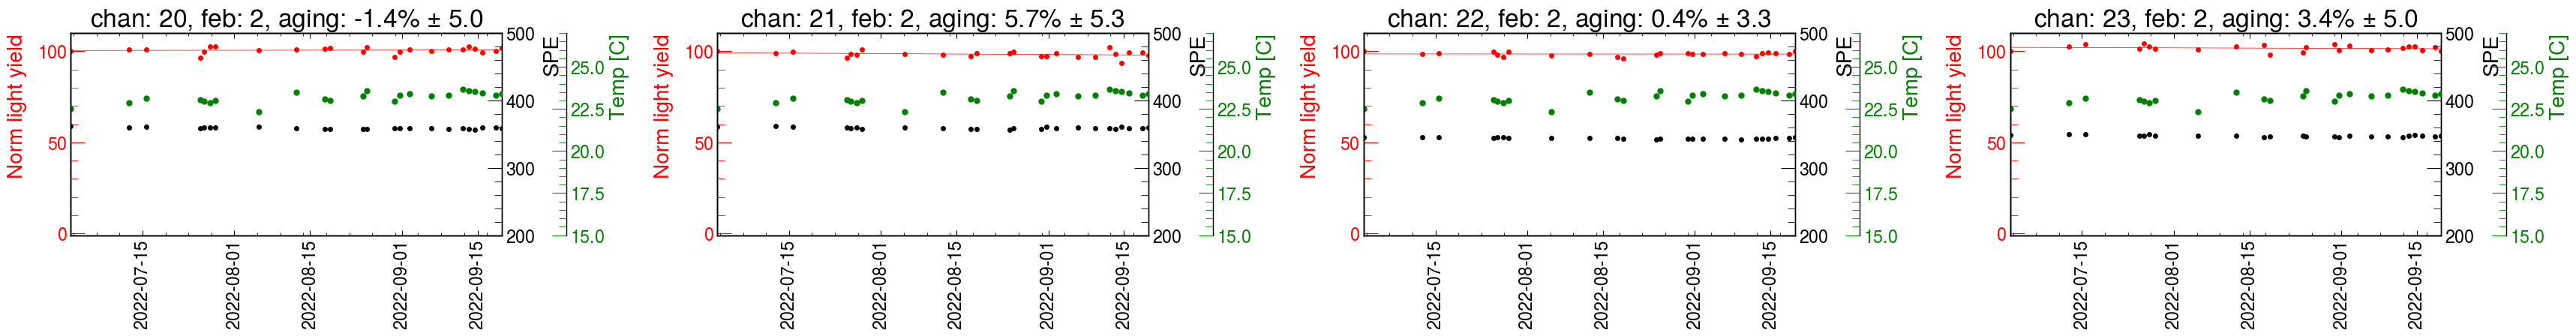

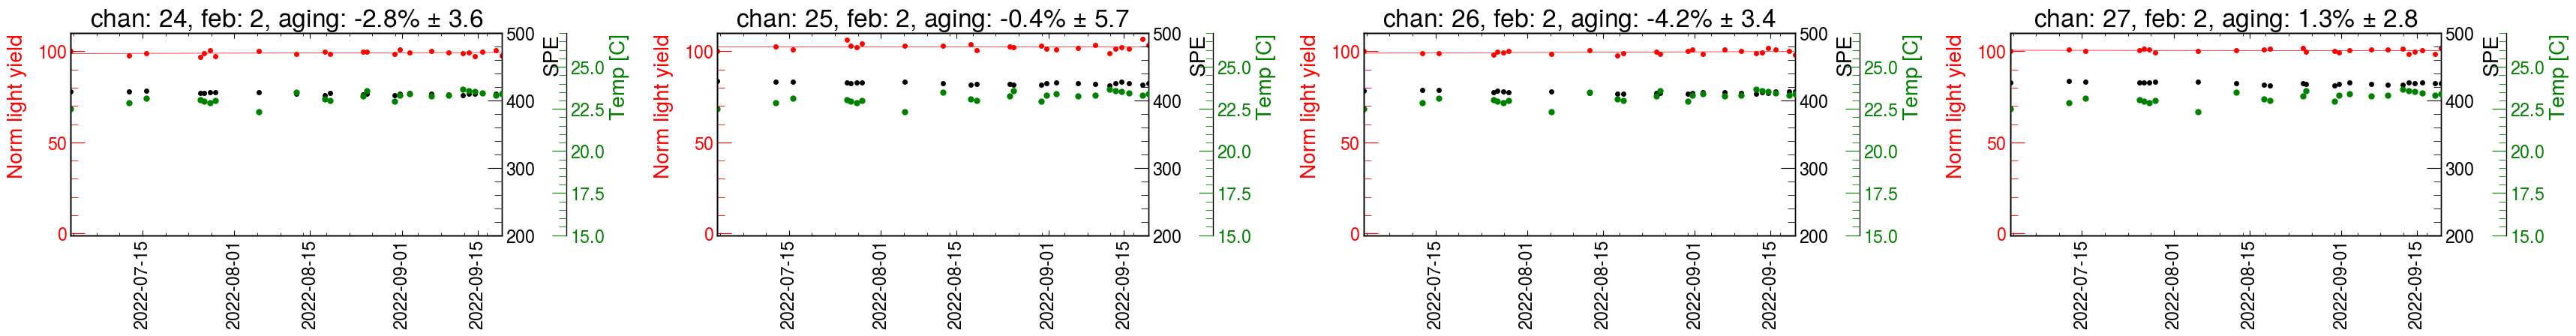

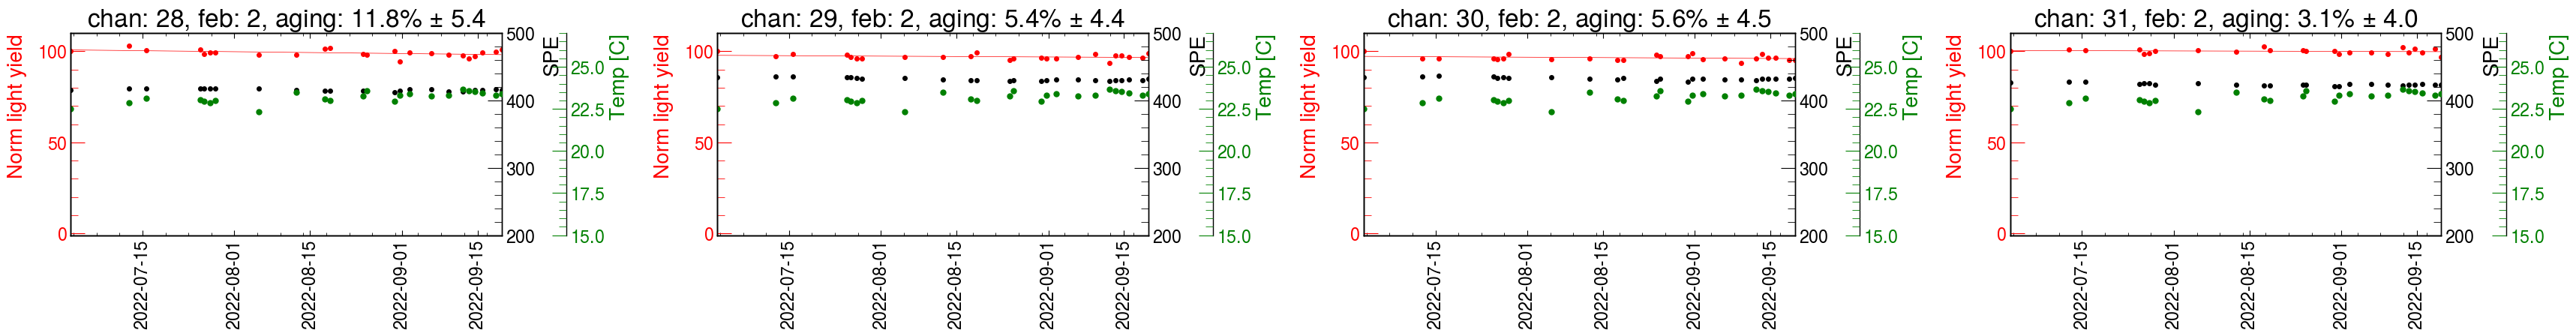

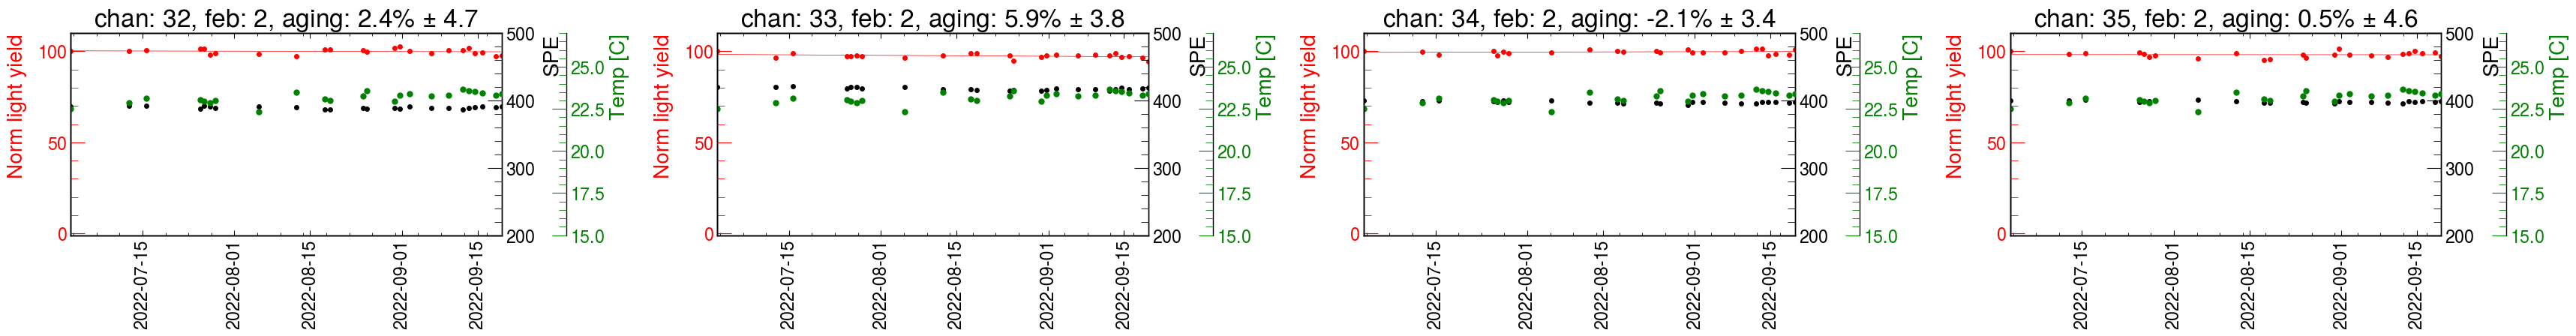

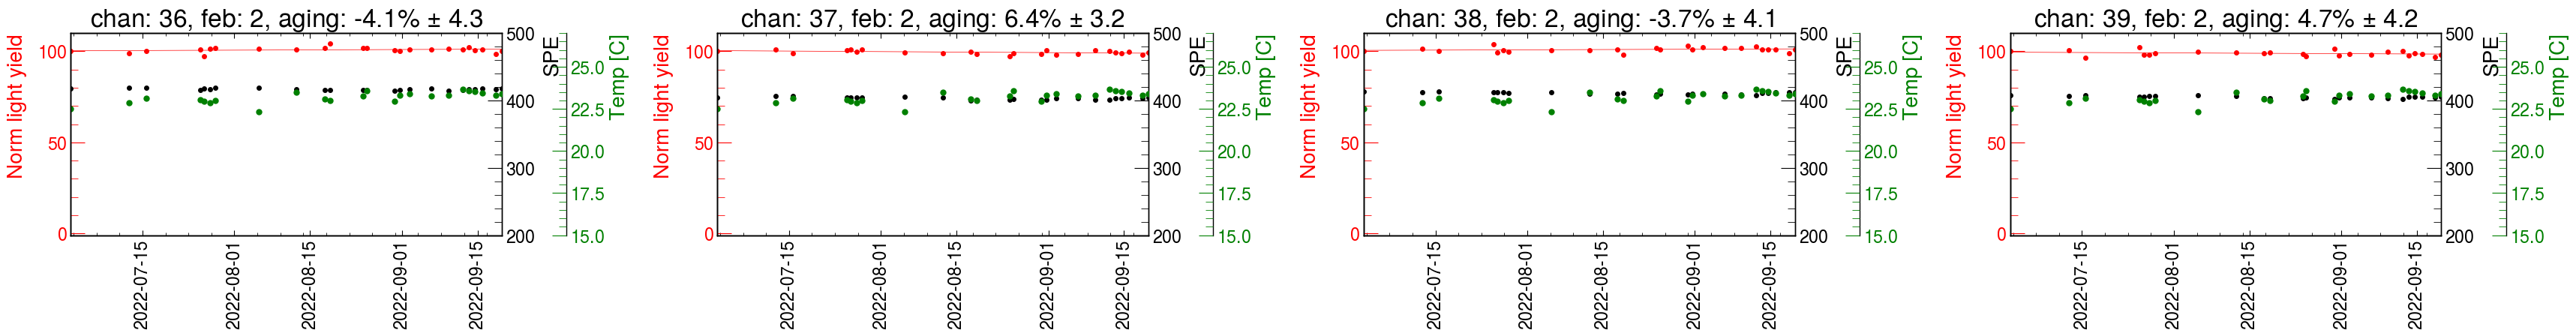

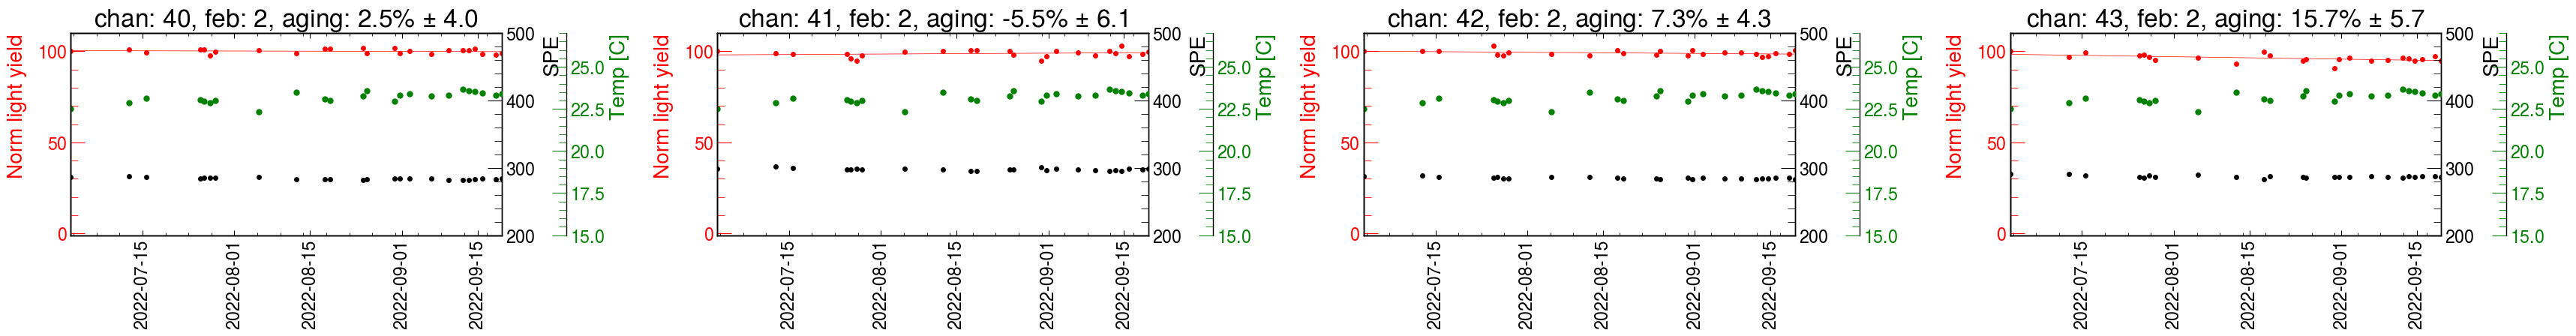

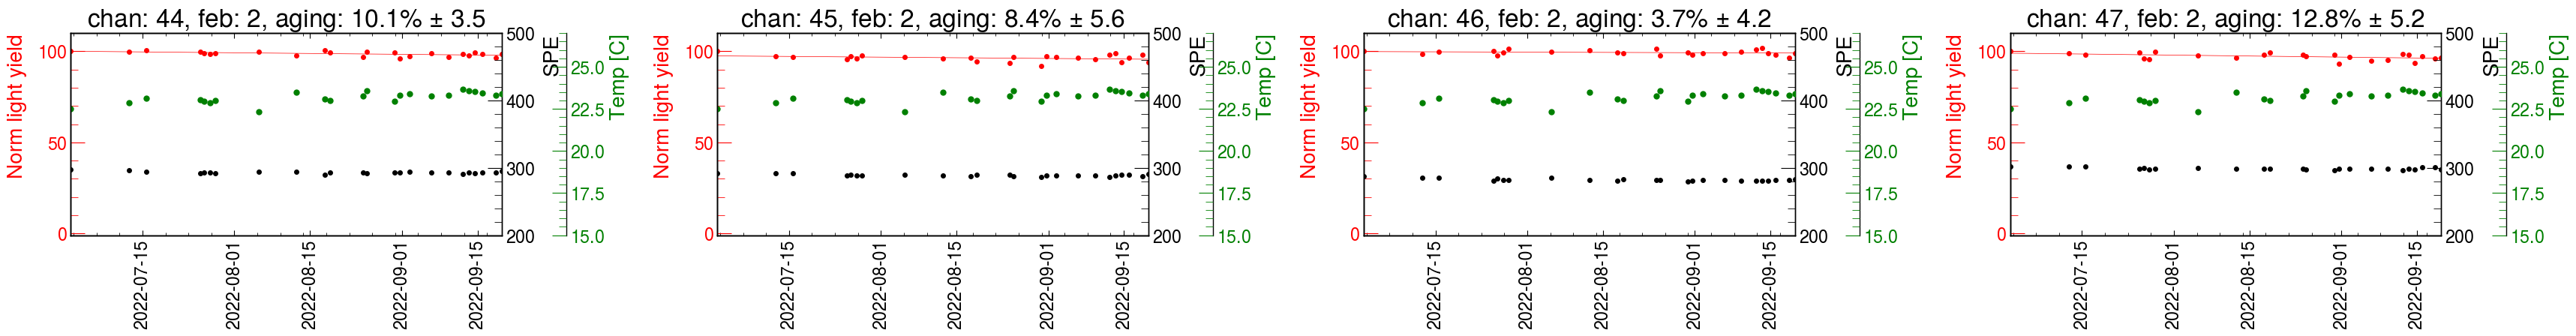

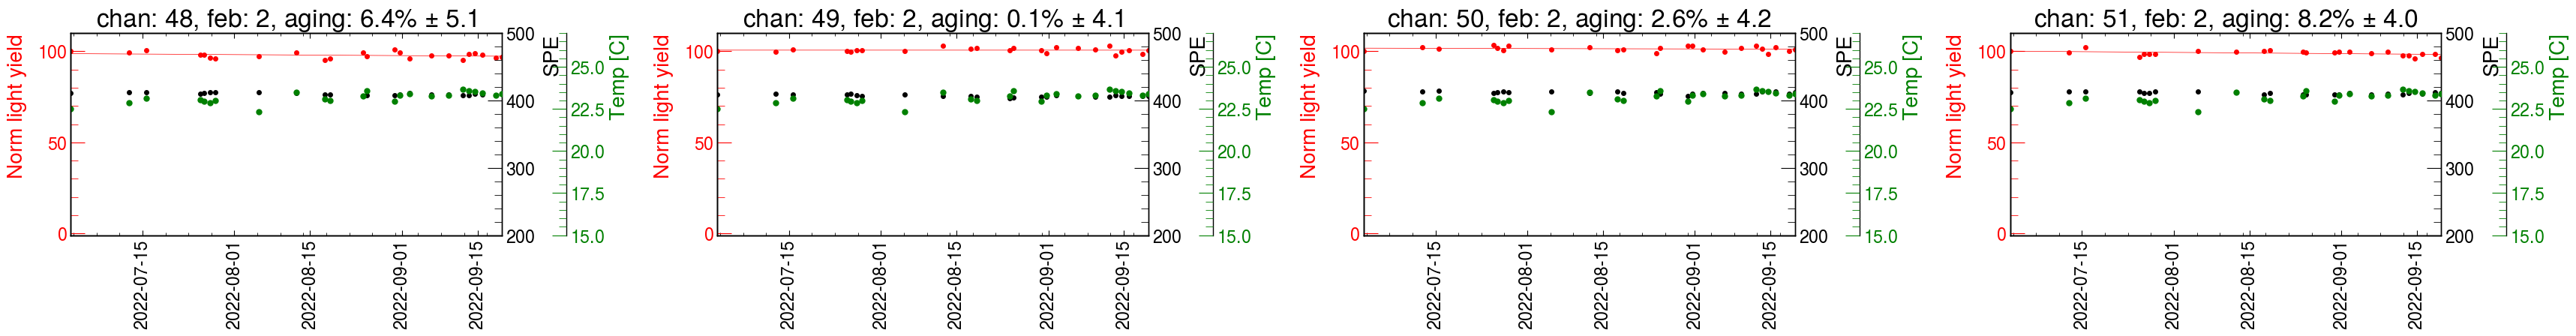

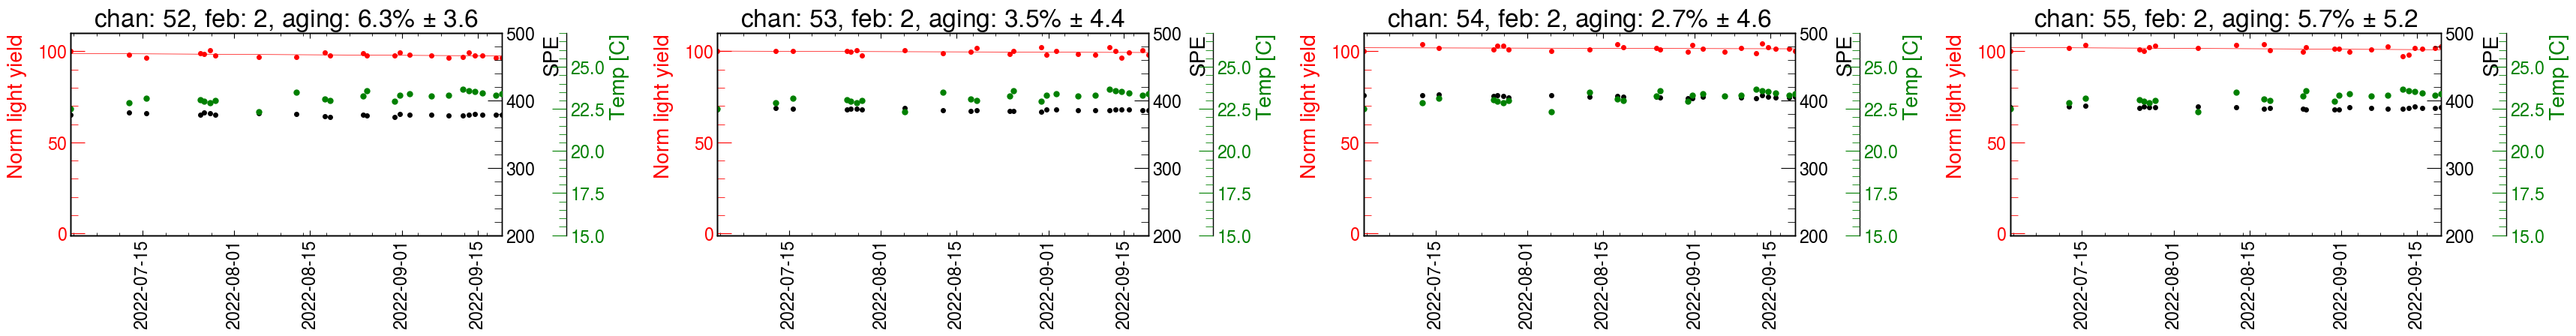

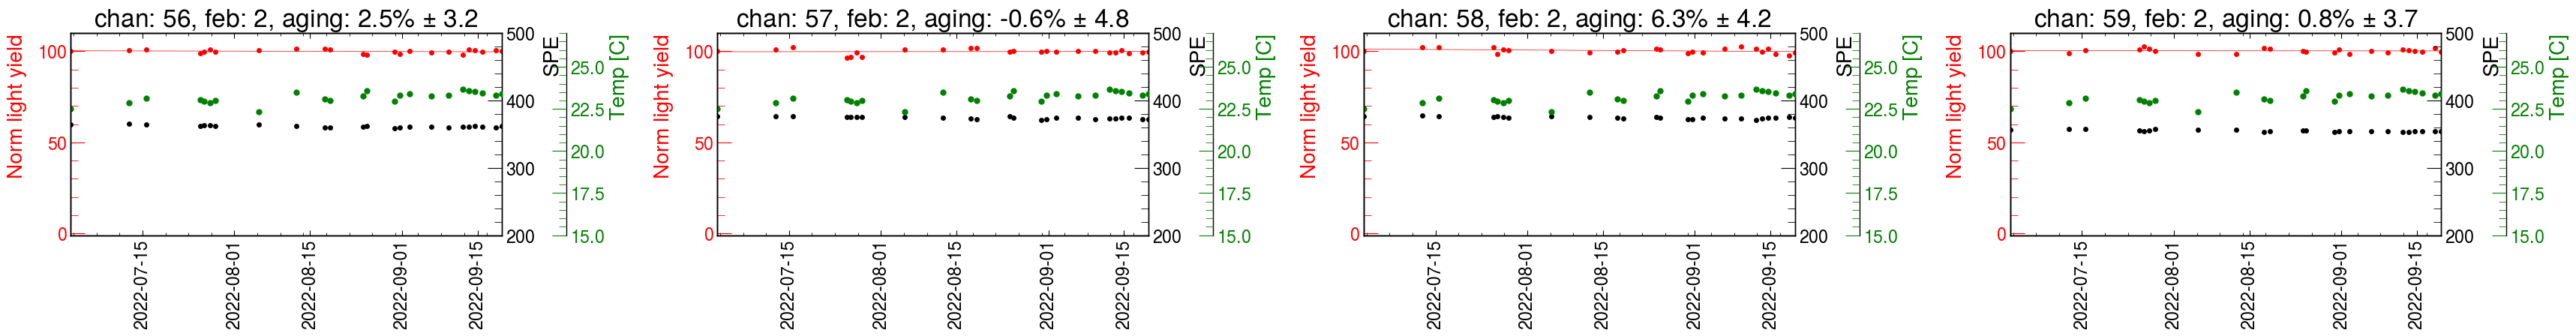

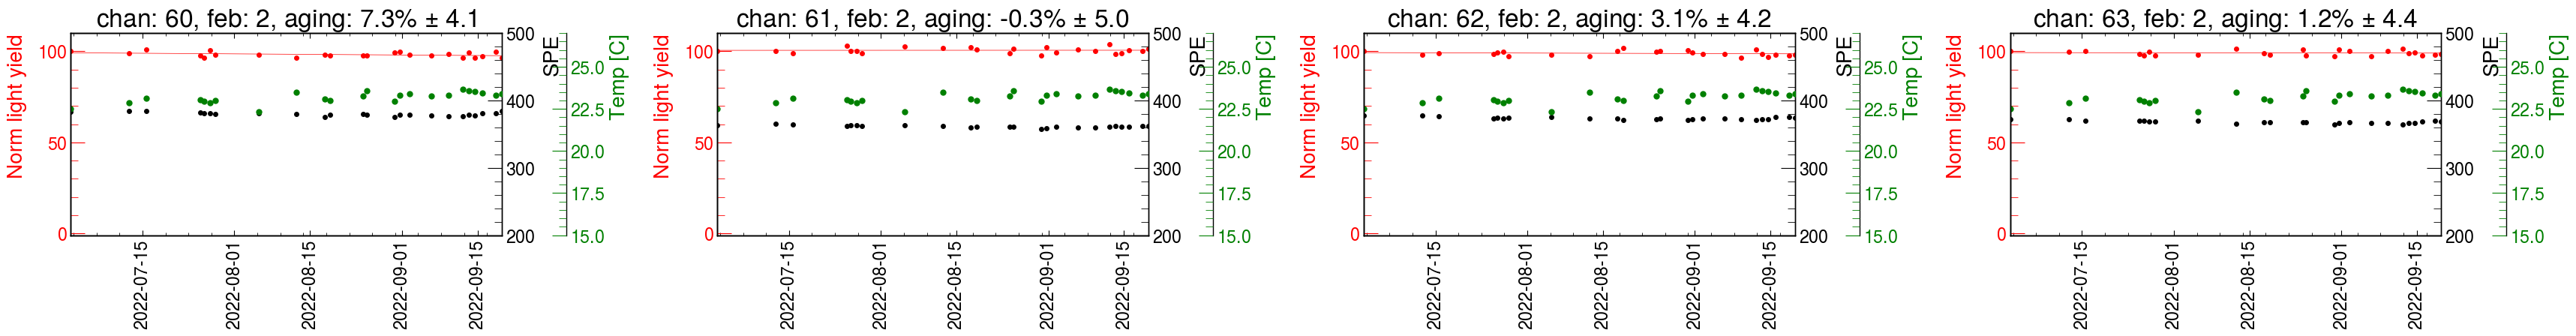

In [125]:
NFEB = 3
NHDMI = 16
SEC_YEAR=3.154e+7
aging_arr = -999*np.ones((3,64))
t0=str(ar['timestamp'].to_numpy()[0])

for feb in range(0, NFEB):
  for hdmi in range(0, NHDMI):
    fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(40, 3.5))
    plt.subplots_adjust(wspace=0.5)
    plt.xticks(rotation = 90);

    for chan in range(0, 4):
      ax2 = ax1[chan].twinx()
      ax3 = ax1[chan].twinx()
      ax3.spines['right'].set_position(("axes", 1.15))

      #Plot normalized PE over years
      chan_infeb = hdmi*4+chan 
      x=ar['timestamp'].to_numpy()  
      y=ar['PEsTemperatureCorrected'][:,feb,chan_infeb].to_numpy()  
      if y[0]>0:
          y=y/y[0]*100

      slope, intercept, r_value, p_value, std_err = stats.linregress(x/SEC_YEAR,y)
      ax1[chan].set_title('chan: %d, feb: %d, aging: %.1f%% $\pm$ %.1f'%(hdmi*4+chan,feb,-slope,std_err ))
      ax1[chan].set_ylim(-1,110)
      ax1[chan].set_ylabel('Norm light yield', color='r')
      ax1[chan].tick_params(axis='y', which='both', colors='r')
      ax1[chan].tick_params(axis='x', rotation = 90)

      ax1[chan].plot(x.astype('datetime64[s]'), y , 'r.')
      line_x = np.arange(x.min(), x.max(),36000) # 10 hour bins - used to draw fit line only
      line_y = slope*line_x/SEC_YEAR + intercept
      ax1[chan].plot(line_x.astype('datetime64[s]'), line_y, 'r-',linewidth=0.5, label='$%.2fx + %.2f$, $R^2=%.2f$' % (slope, intercept, r_value**2))

      y=ar['calibConstantsTemperatureCorrected'][:,feb,chan_infeb].to_numpy()         
      ax2.plot(x.astype('datetime64[s]'), y , 'k.')
      ax2.set_ylim(200,500)
      ax2.set_ylabel('SPE', color='k', labelpad=7);
        
      #Plot temp over time
      y=ar['meanTemperatures'][:,0,0].to_numpy()
      ax3.plot(x.astype('datetime64[s]'), y, 'go', markersize=5.0)
      ax3.set_ylabel('Temp [C]', color='g', labelpad=5)
      ax3.set_ylim(15,27)
      ax3.tick_params(axis='y', which='both', colors='g')
      aging_arr[feb][chan_infeb] =-slope

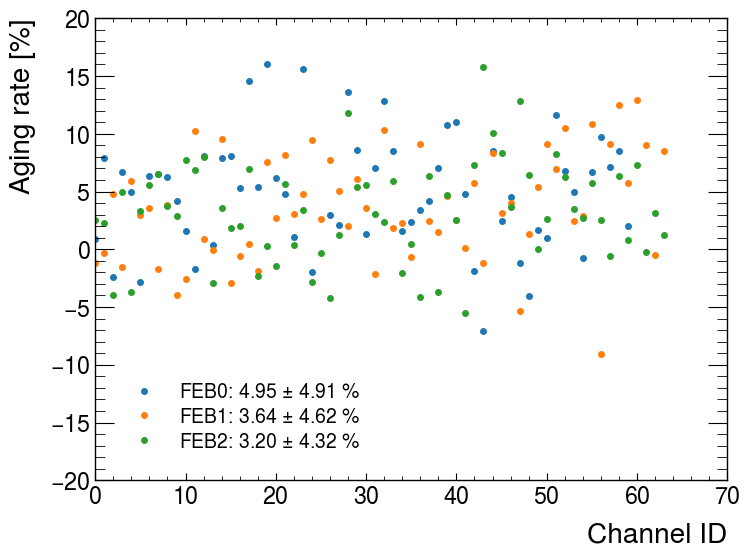

In [139]:
for feb in range(0, NFEB):
    feb_age_arr = aging_arr[feb,:]
    feb_age_arr_=feb_age_arr[feb_age_arr > -20] # Drop bad SPE points 
    mean = feb_age_arr_[~np.isnan(feb_age_arr_)].mean()
    std = feb_age_arr_[~np.isnan(feb_age_arr_)].std()    
    plt.plot(feb_age_arr, '.', label='FEB%d: %.2f $\pm$ %.2f %%'%(feb, mean, std  ))
    
    plt.legend()
    plt.xlabel('Channel ID')
    plt.ylim(-20,20)
    plt.ylabel('Aging rate [%]')

0

<Figure size 800x600 with 0 Axes>

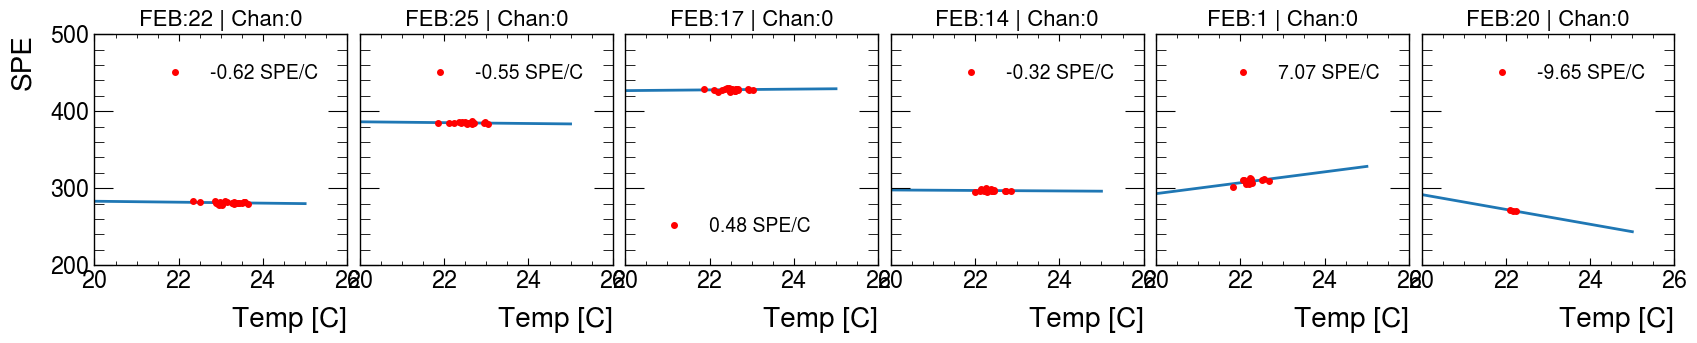

<Figure size 800x600 with 0 Axes>

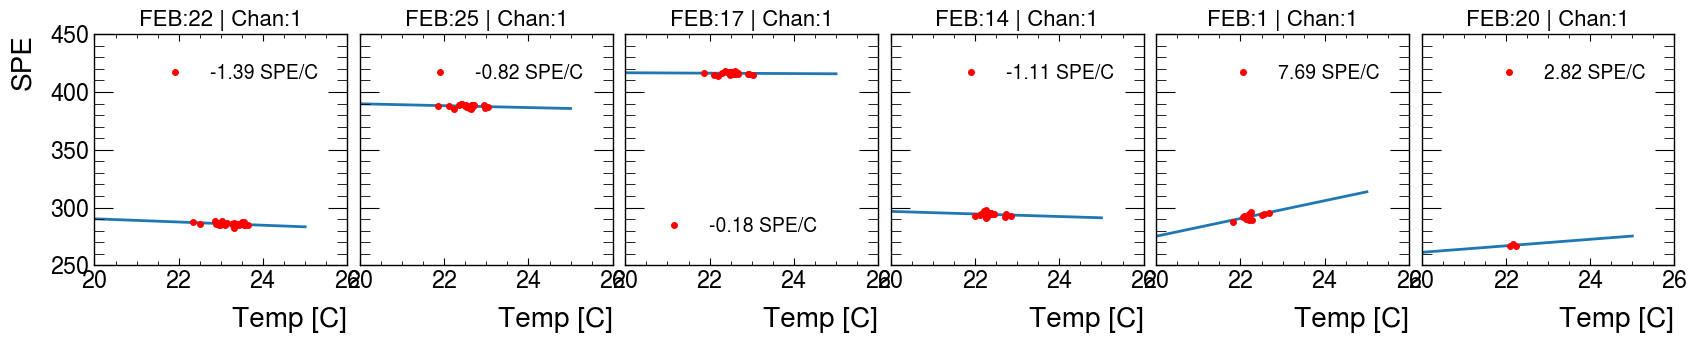

<Figure size 800x600 with 0 Axes>

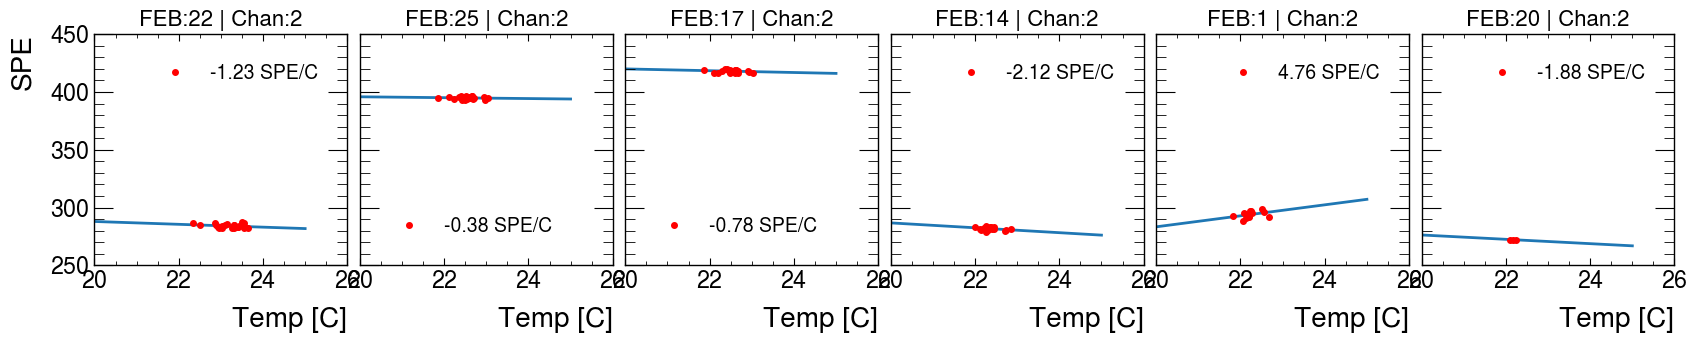

<Figure size 800x600 with 0 Axes>

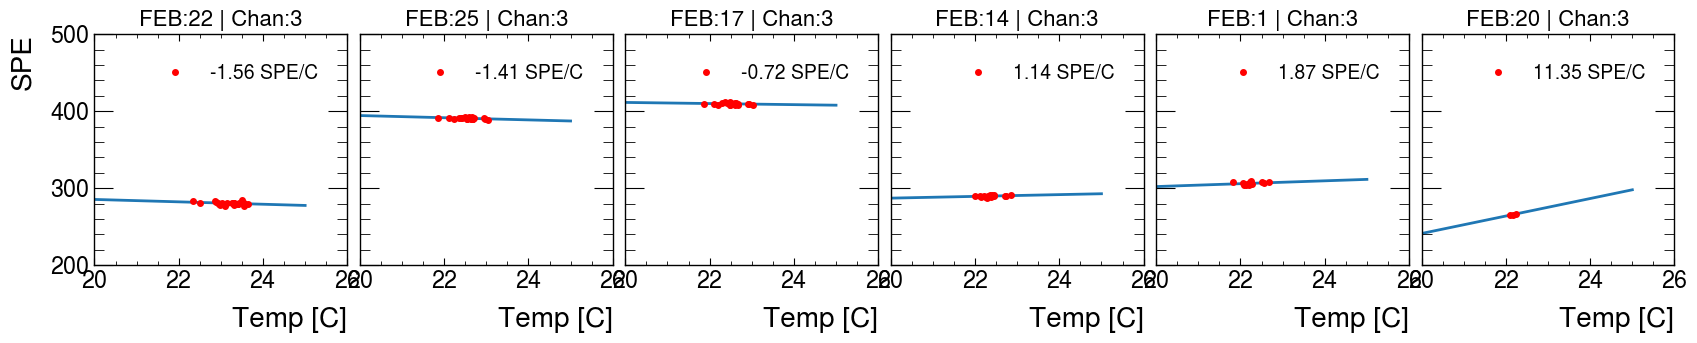

<Figure size 800x600 with 0 Axes>

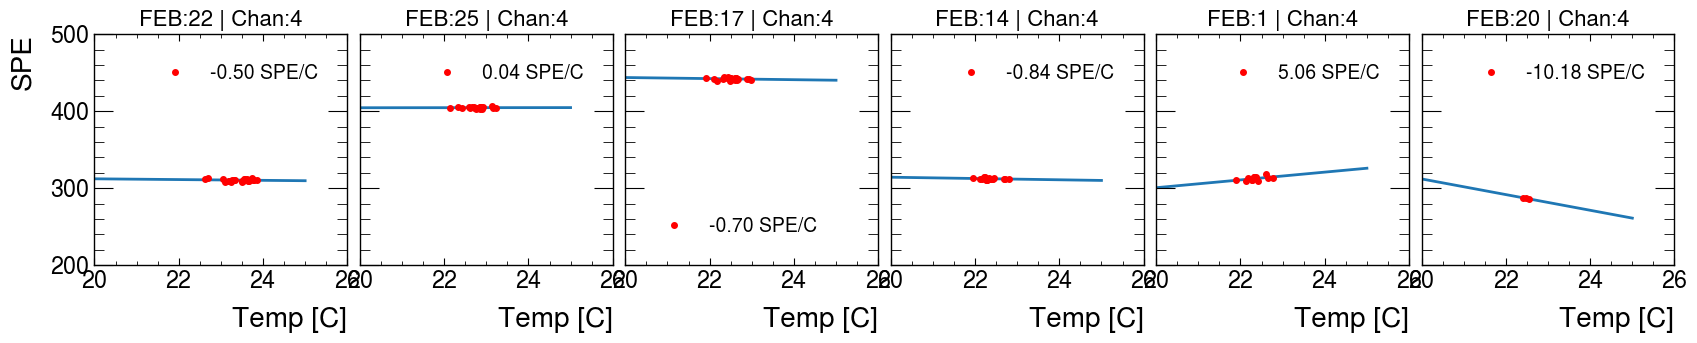

<Figure size 800x600 with 0 Axes>

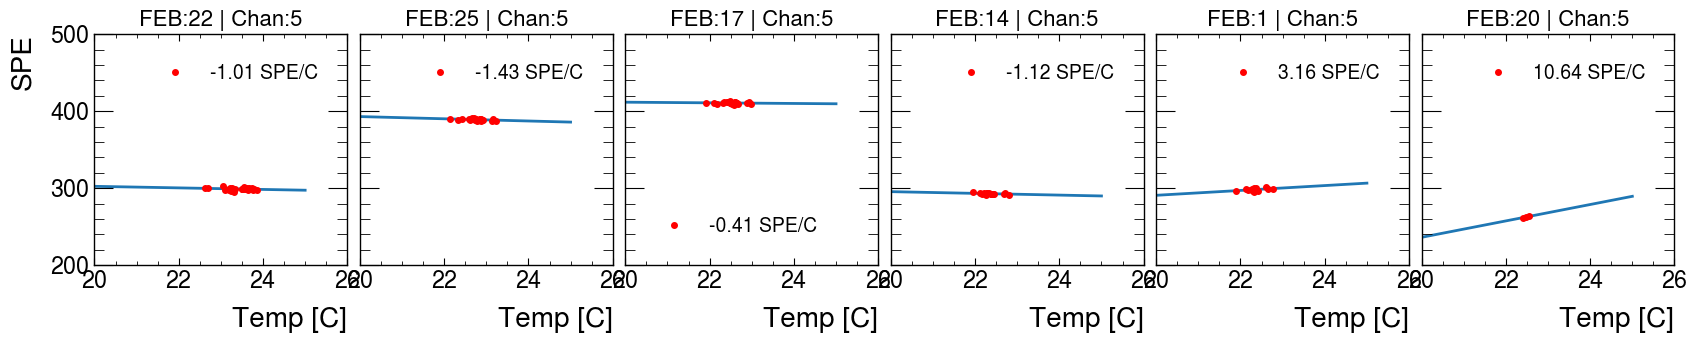

<Figure size 800x600 with 0 Axes>

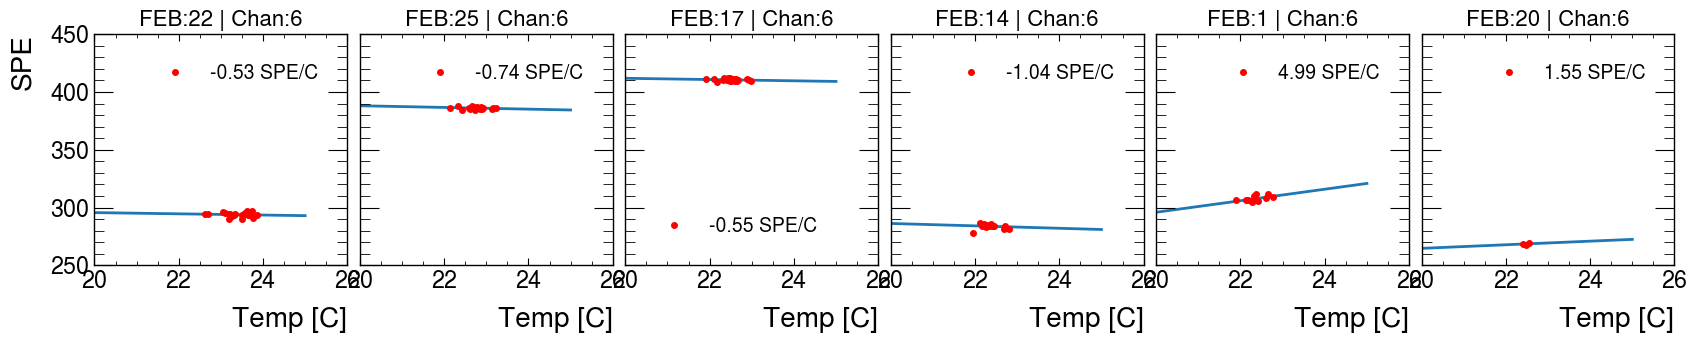

<Figure size 800x600 with 0 Axes>

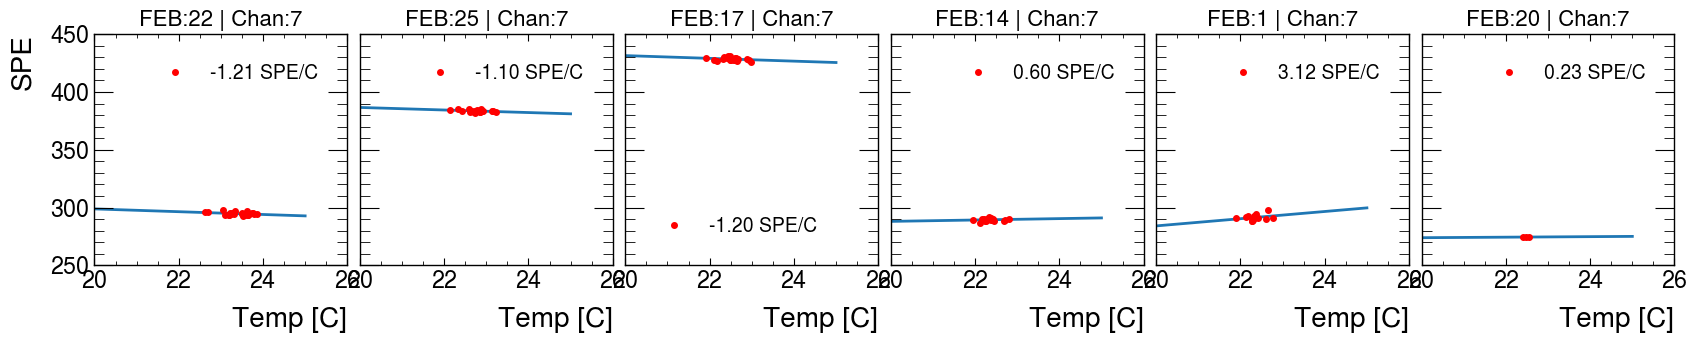

<Figure size 800x600 with 0 Axes>

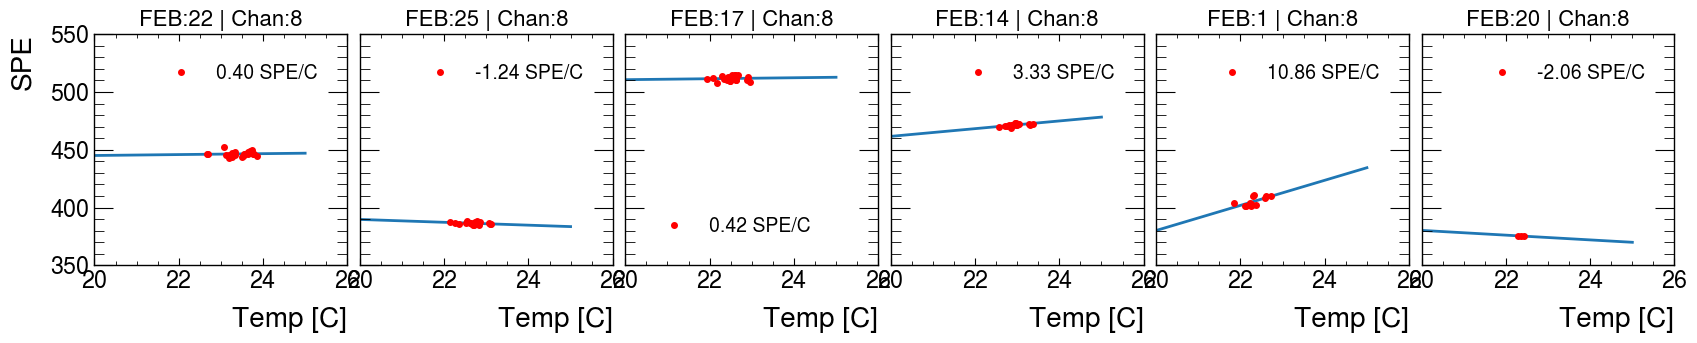

<Figure size 800x600 with 0 Axes>

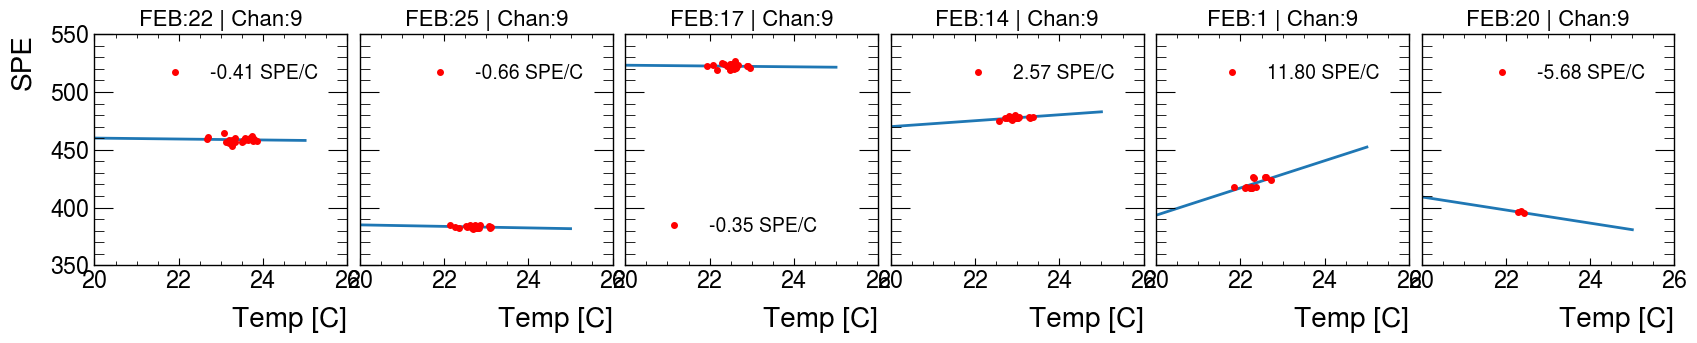

<Figure size 800x600 with 0 Axes>

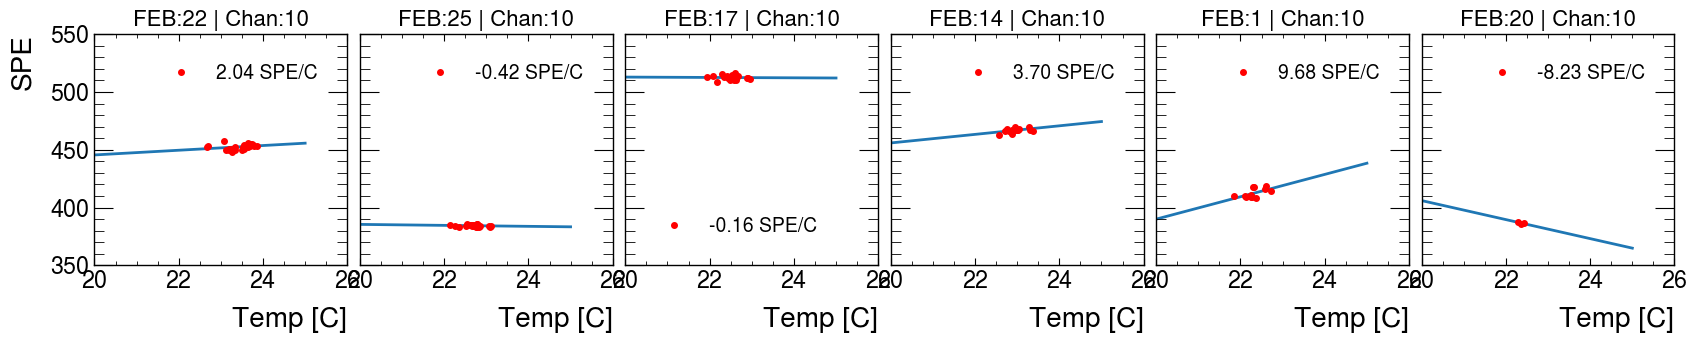

<Figure size 800x600 with 0 Axes>

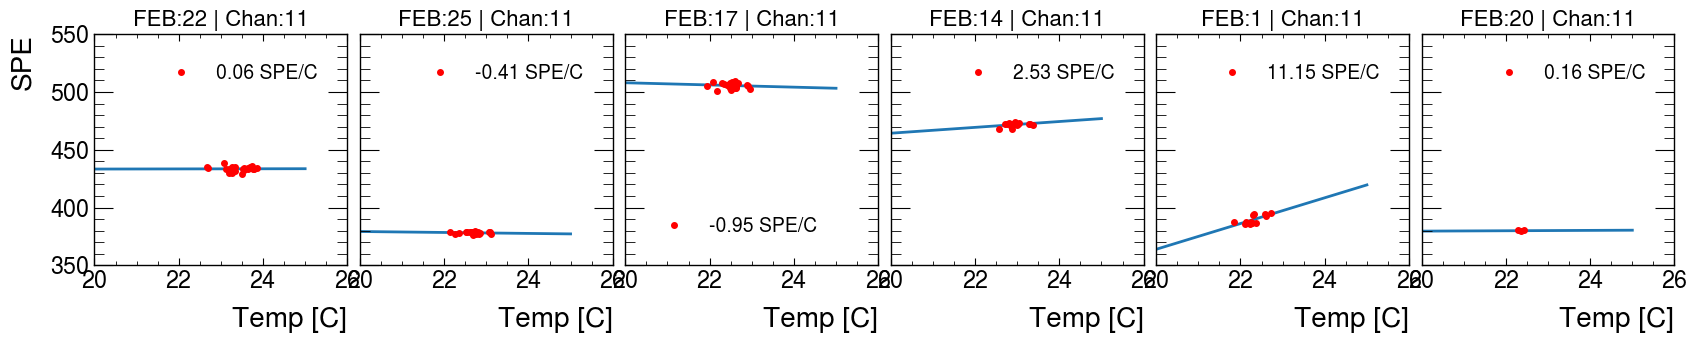

<Figure size 800x600 with 0 Axes>

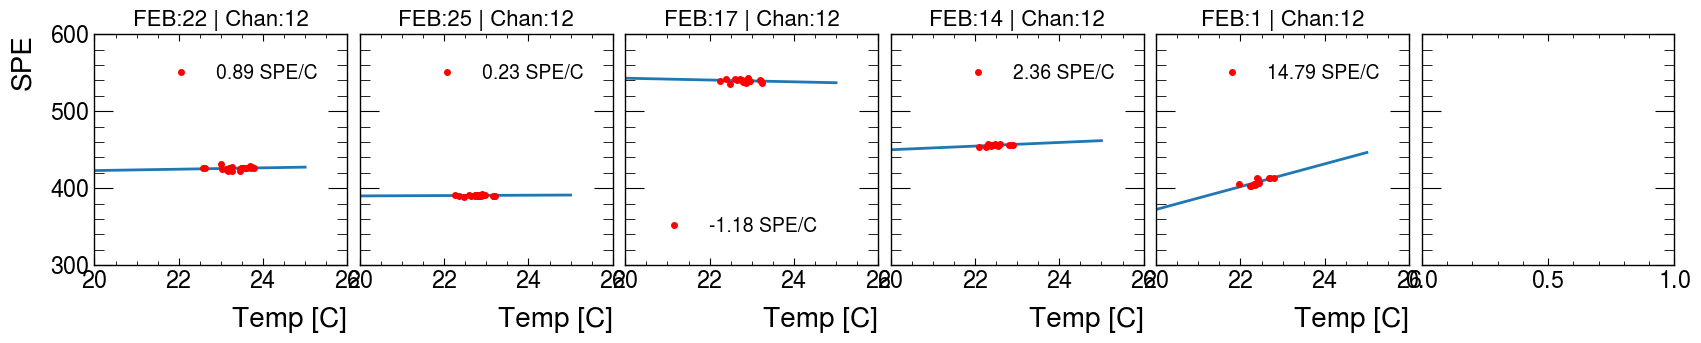

<Figure size 800x600 with 0 Axes>

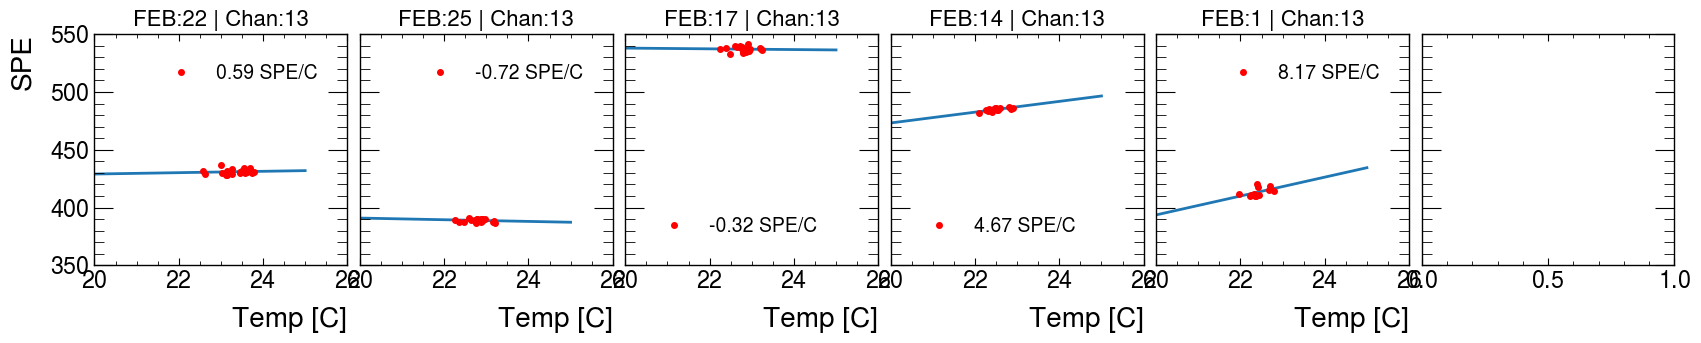

<Figure size 800x600 with 0 Axes>

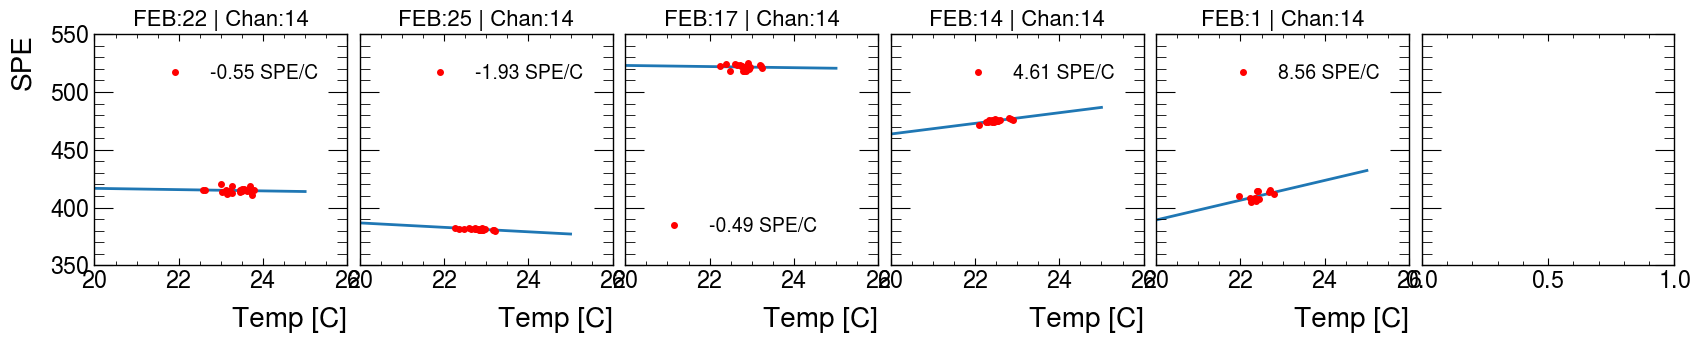

<Figure size 800x600 with 0 Axes>

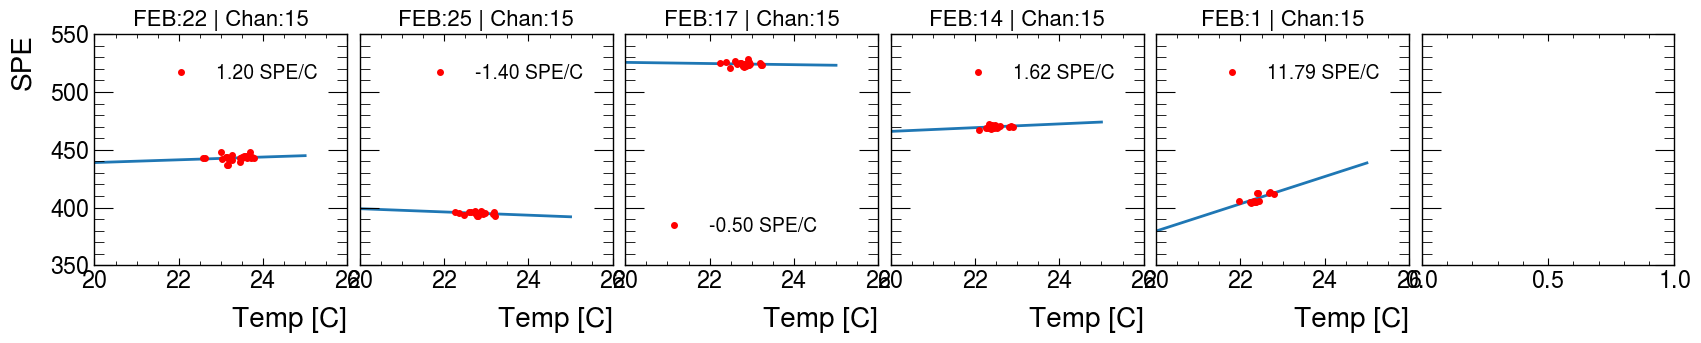

<Figure size 800x600 with 0 Axes>

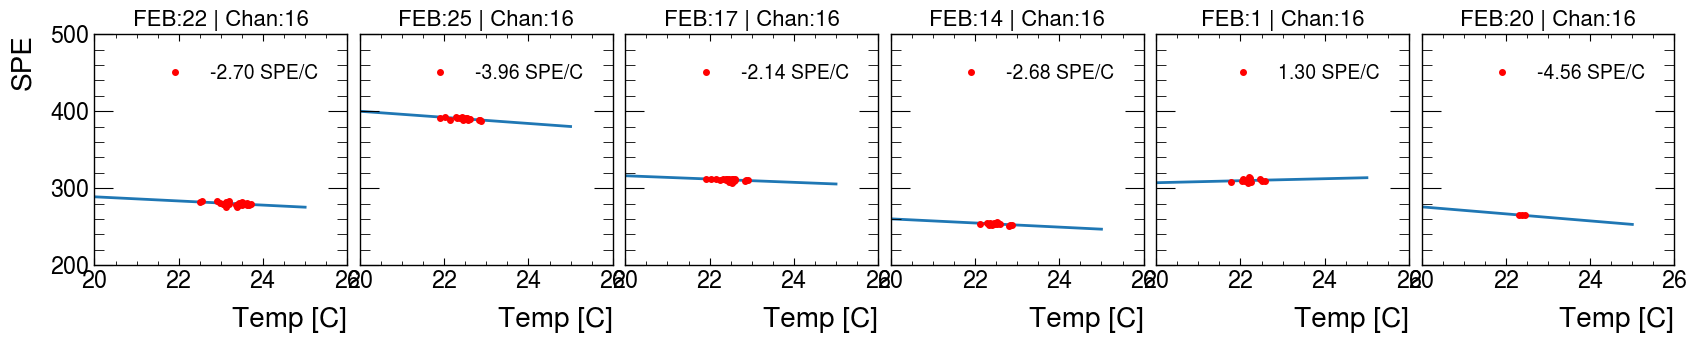

<Figure size 800x600 with 0 Axes>

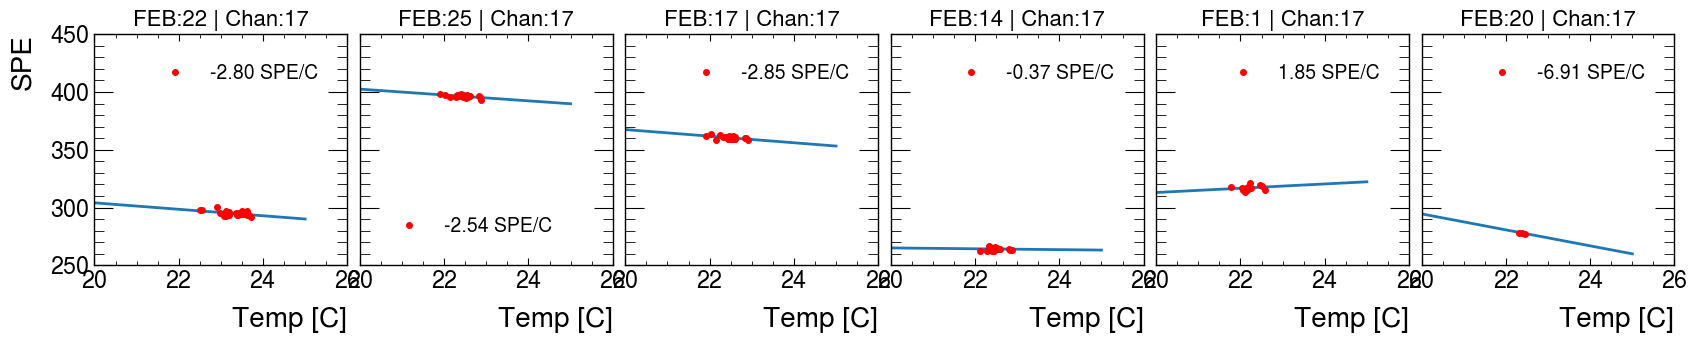

<Figure size 800x600 with 0 Axes>

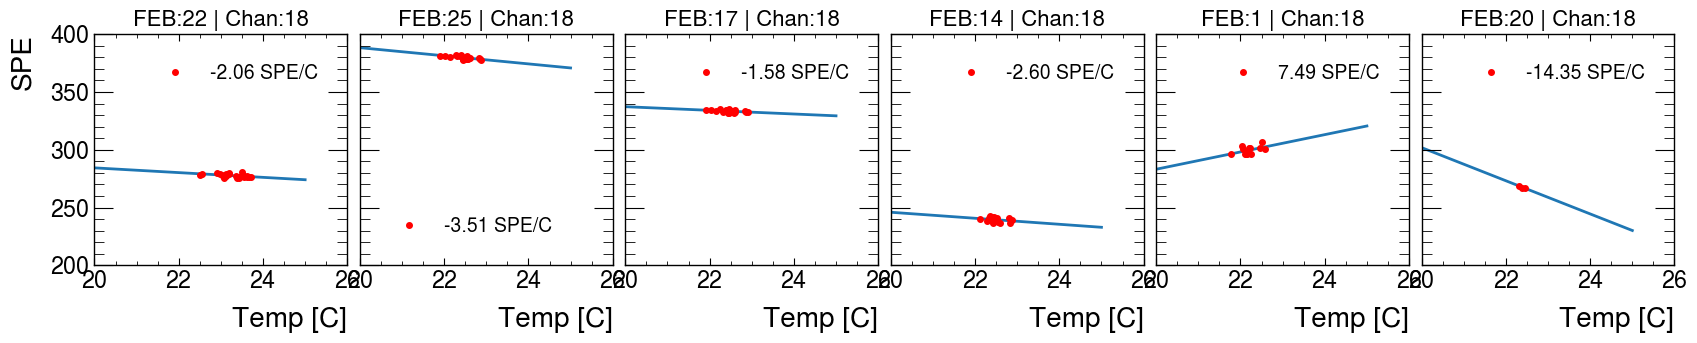

<Figure size 800x600 with 0 Axes>

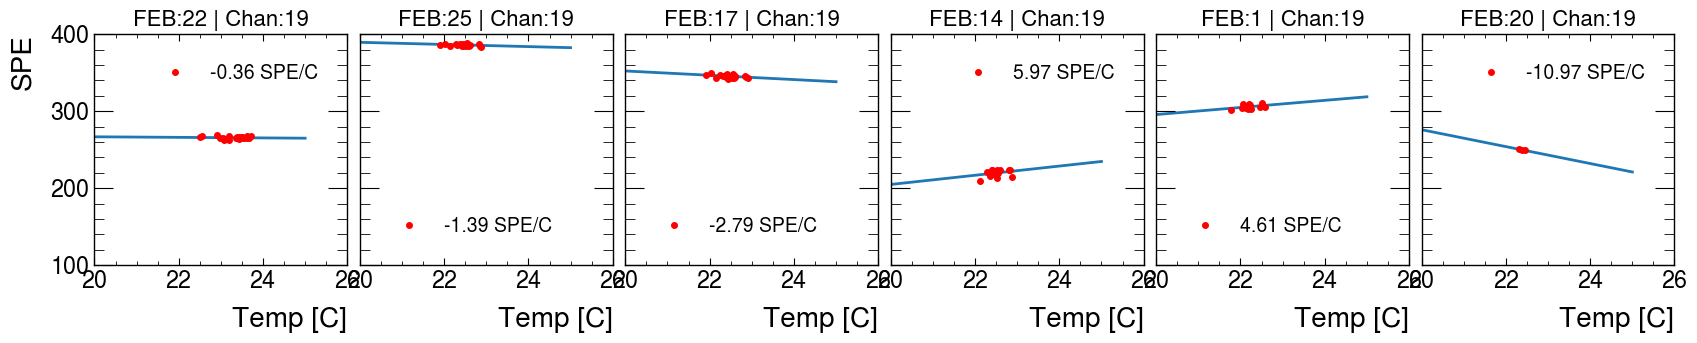

<Figure size 800x600 with 0 Axes>

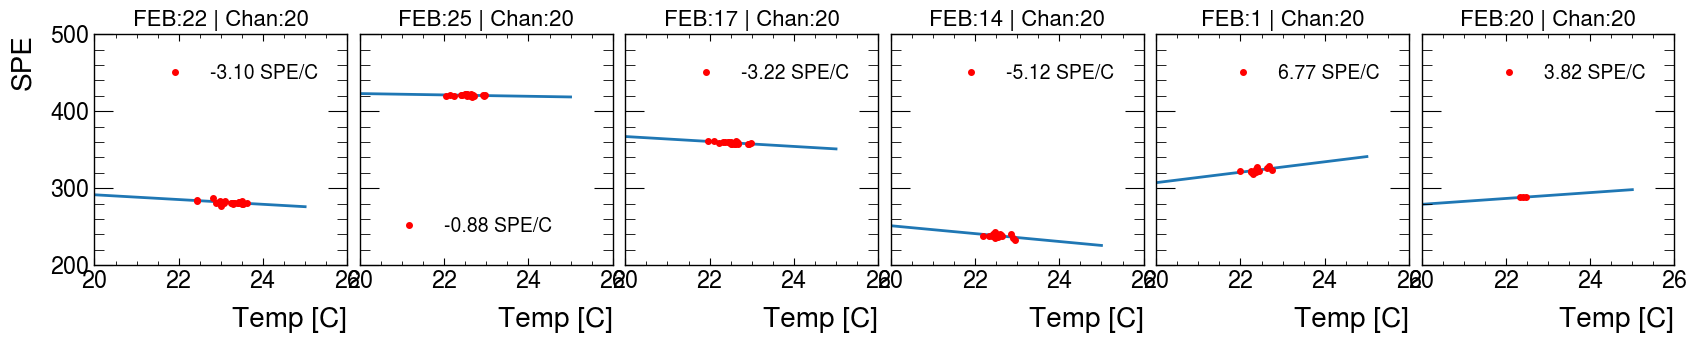

<Figure size 800x600 with 0 Axes>

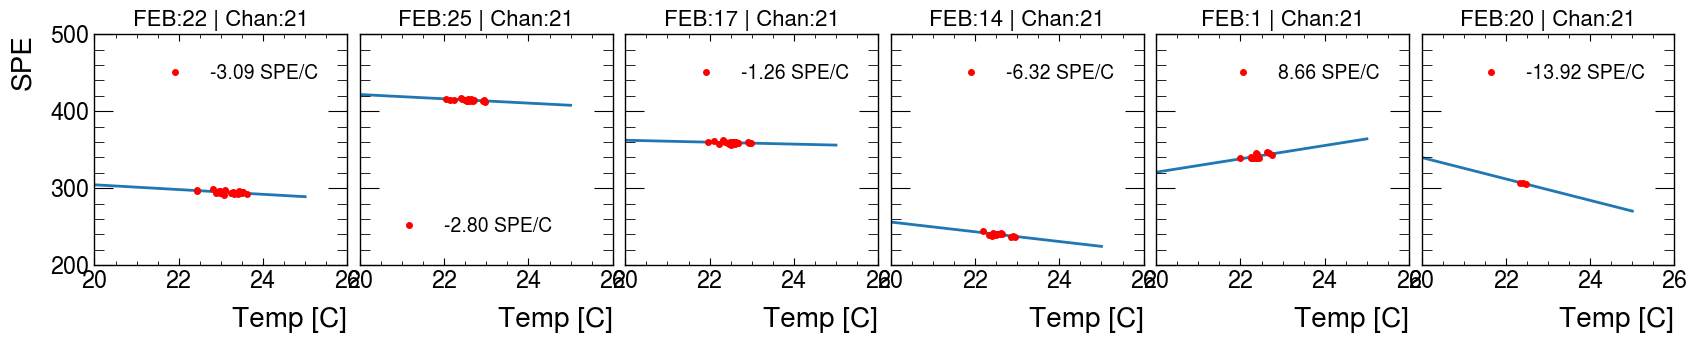

<Figure size 800x600 with 0 Axes>

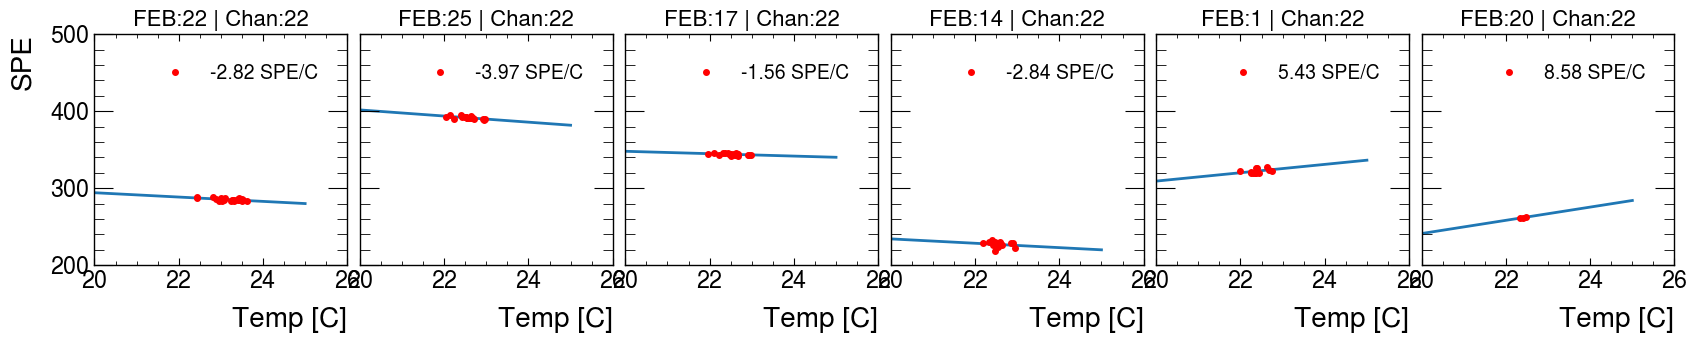

<Figure size 800x600 with 0 Axes>

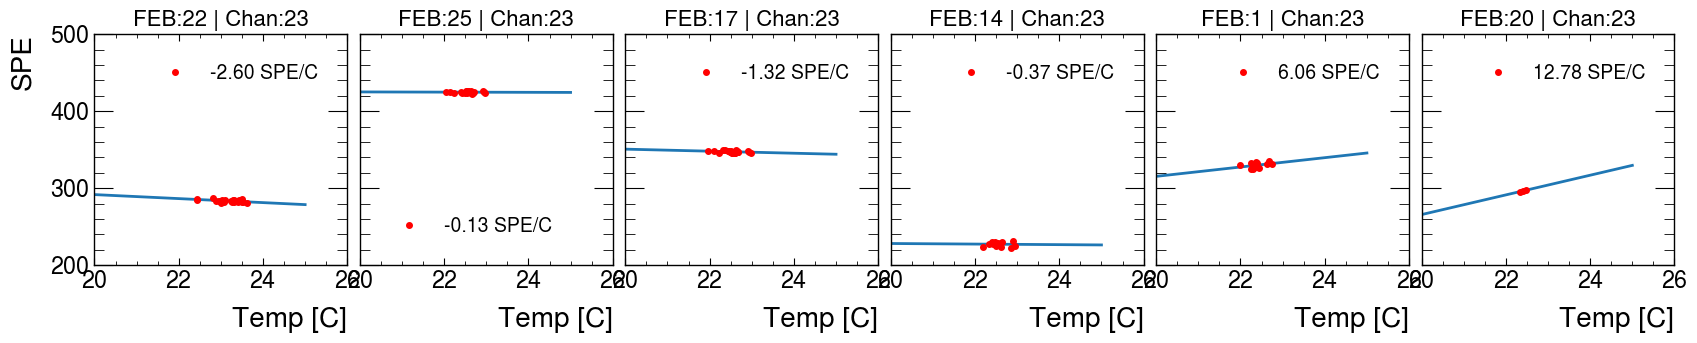

<Figure size 800x600 with 0 Axes>

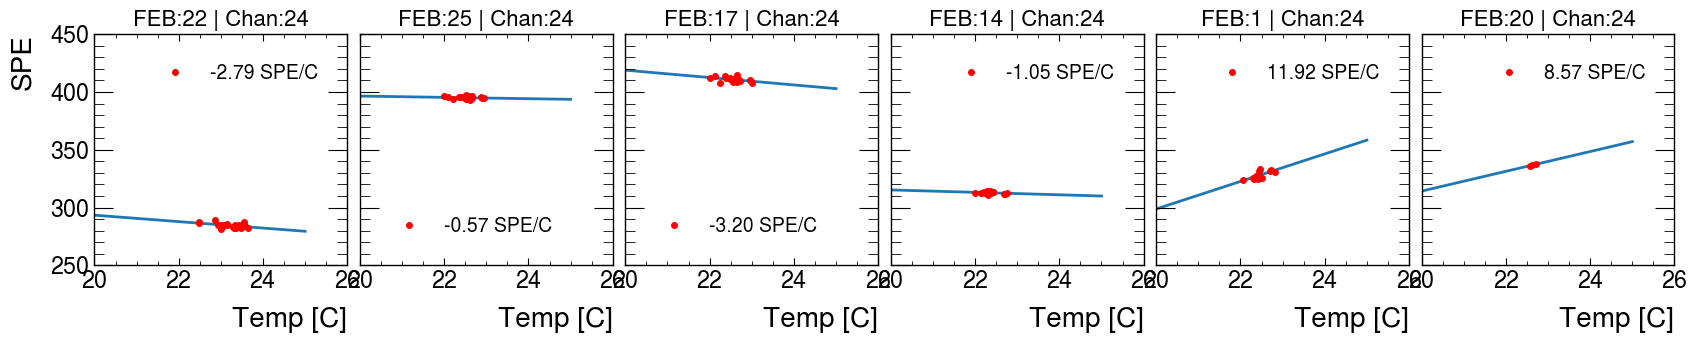

<Figure size 800x600 with 0 Axes>

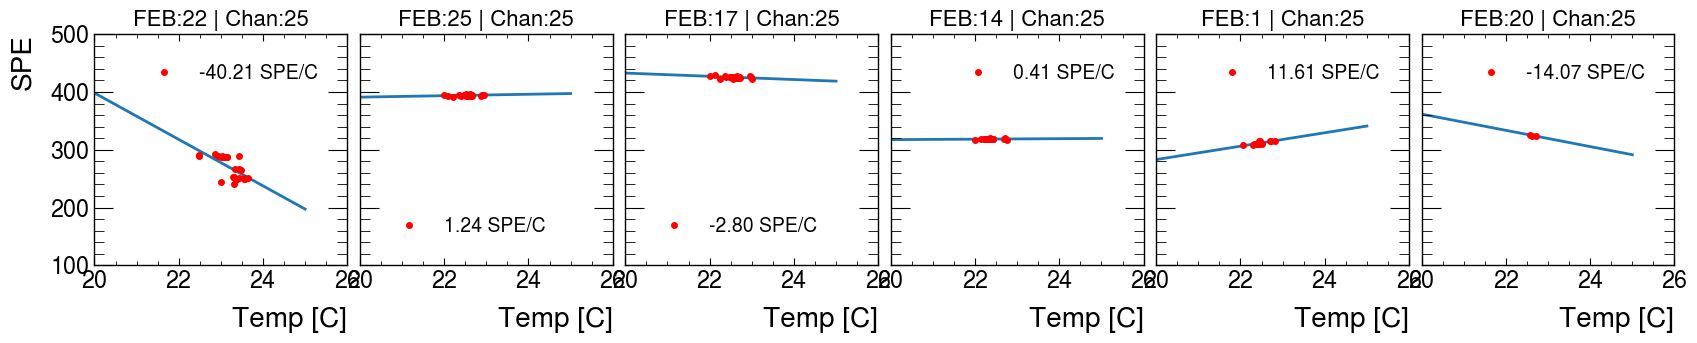

<Figure size 800x600 with 0 Axes>

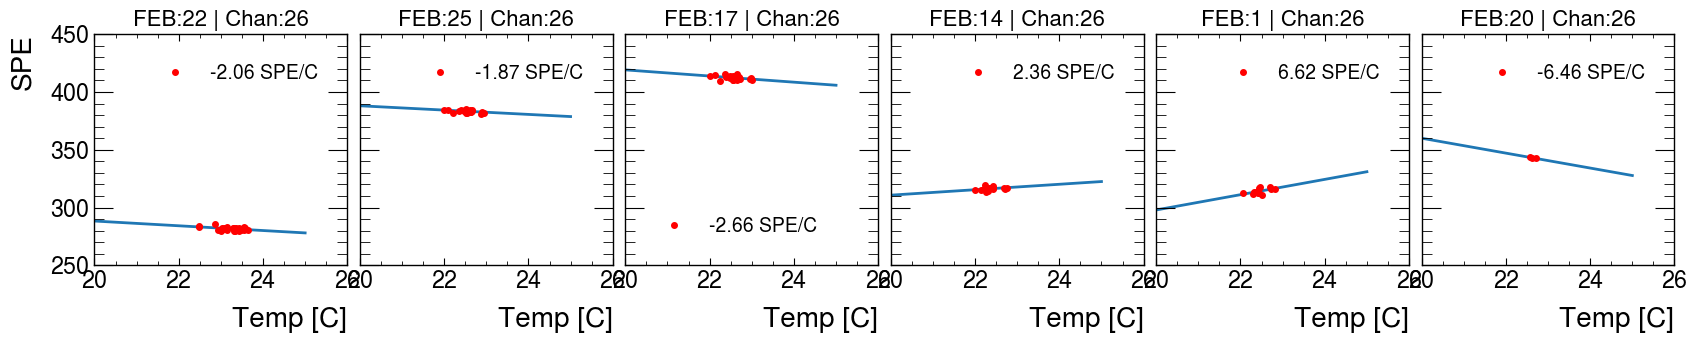

<Figure size 800x600 with 0 Axes>

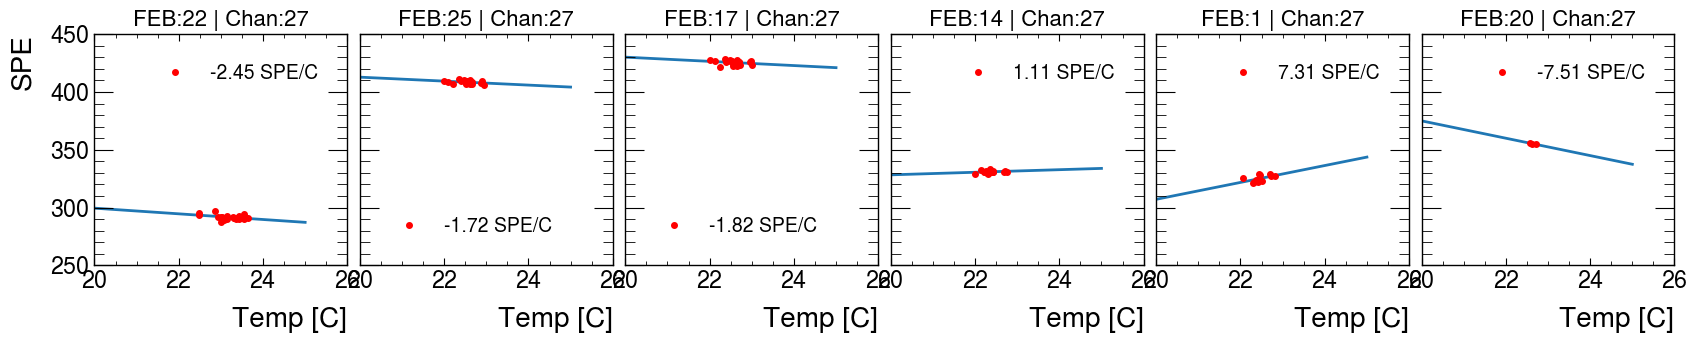

<Figure size 800x600 with 0 Axes>

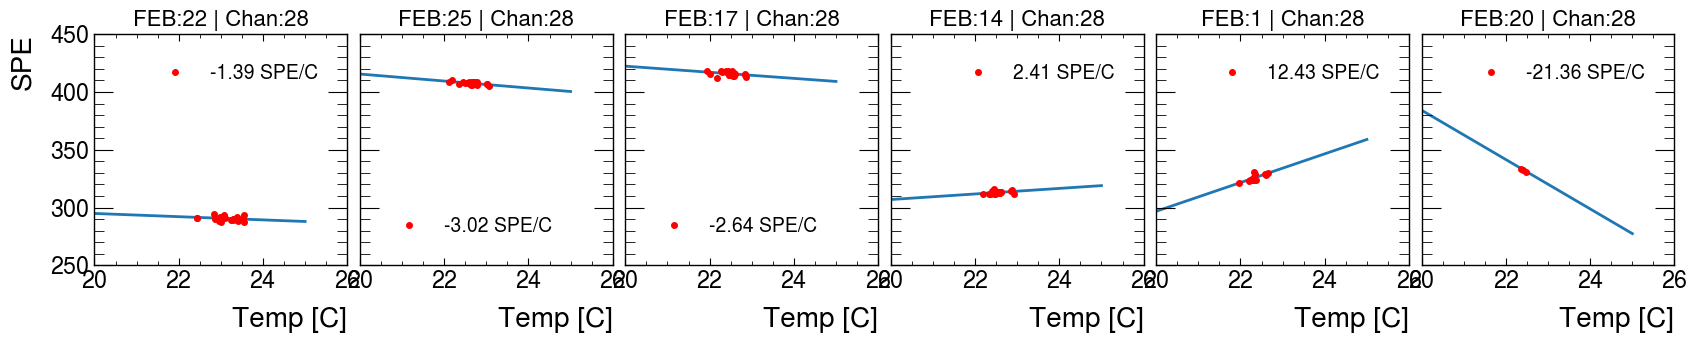

<Figure size 800x600 with 0 Axes>

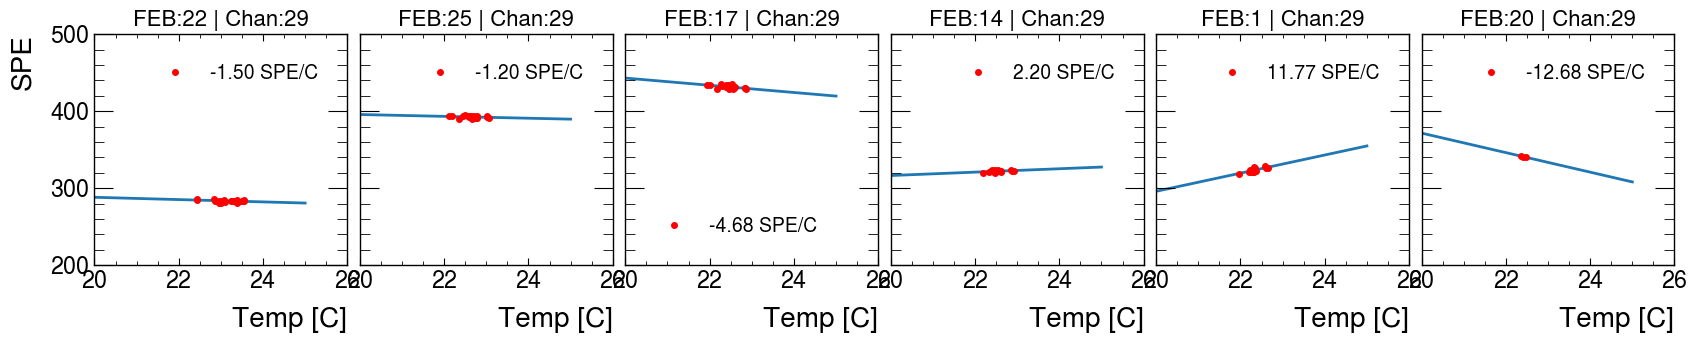

<Figure size 800x600 with 0 Axes>

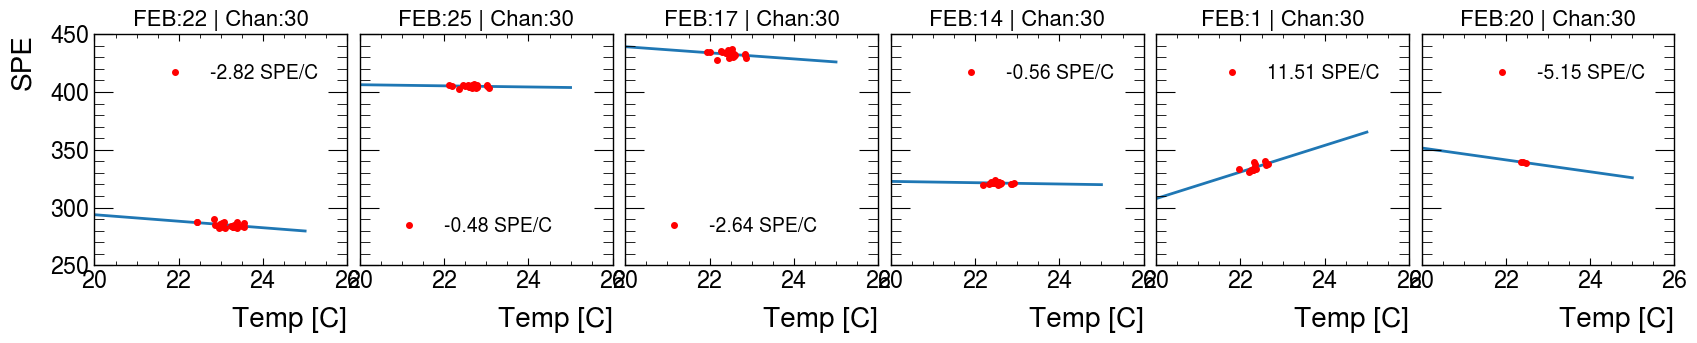

<Figure size 800x600 with 0 Axes>

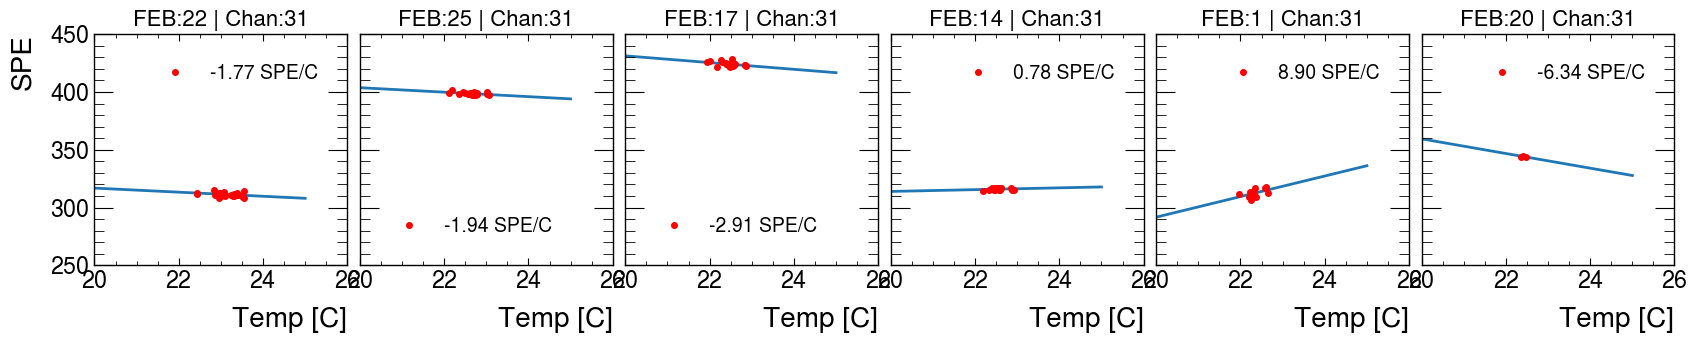

<Figure size 800x600 with 0 Axes>

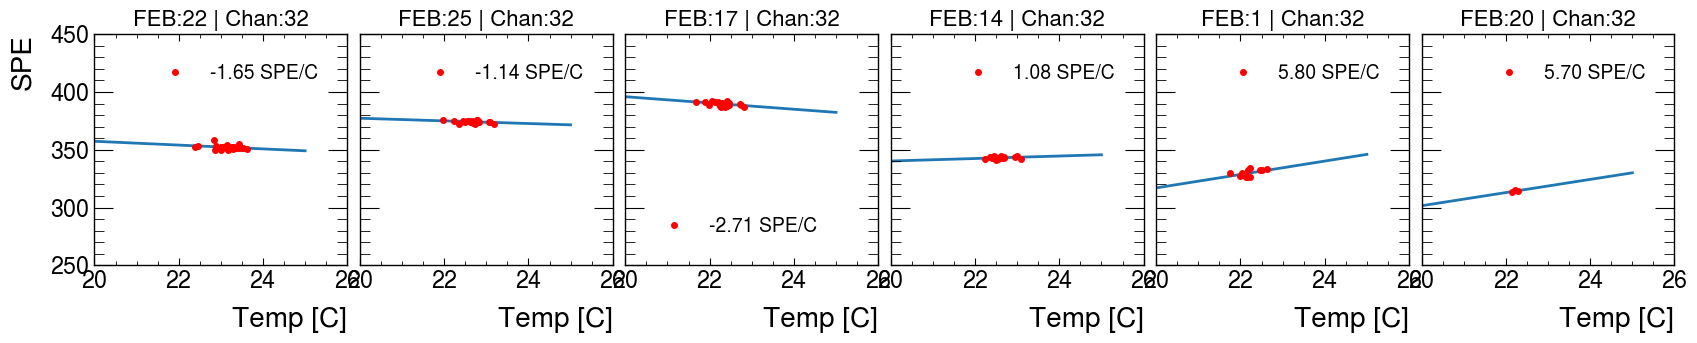

<Figure size 800x600 with 0 Axes>

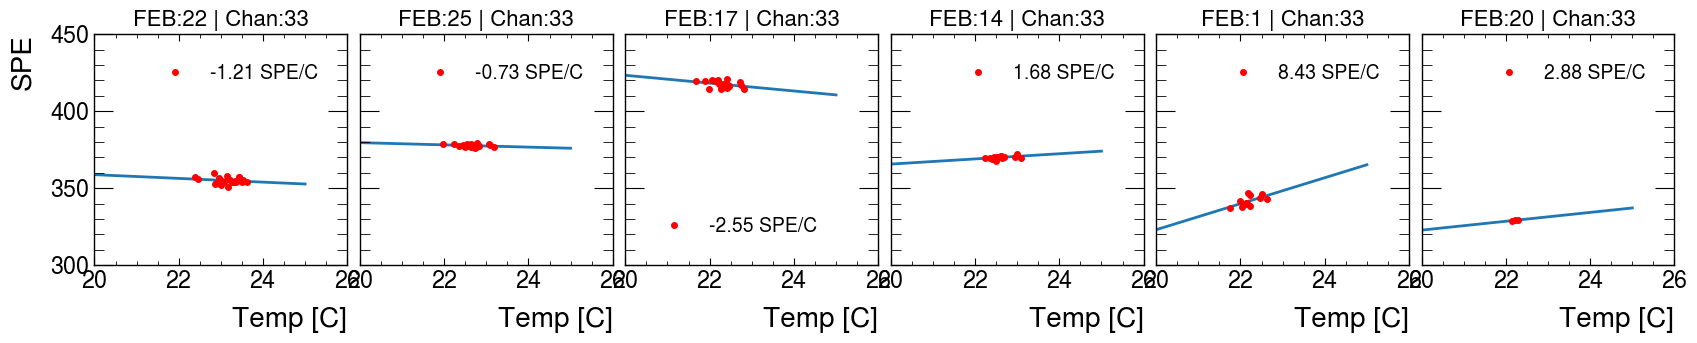

<Figure size 800x600 with 0 Axes>

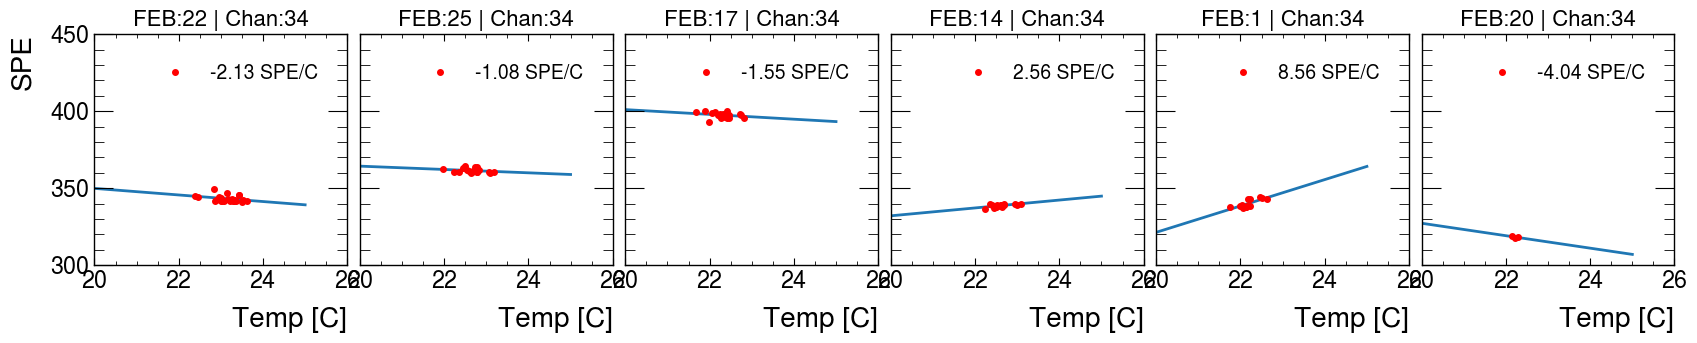

<Figure size 800x600 with 0 Axes>

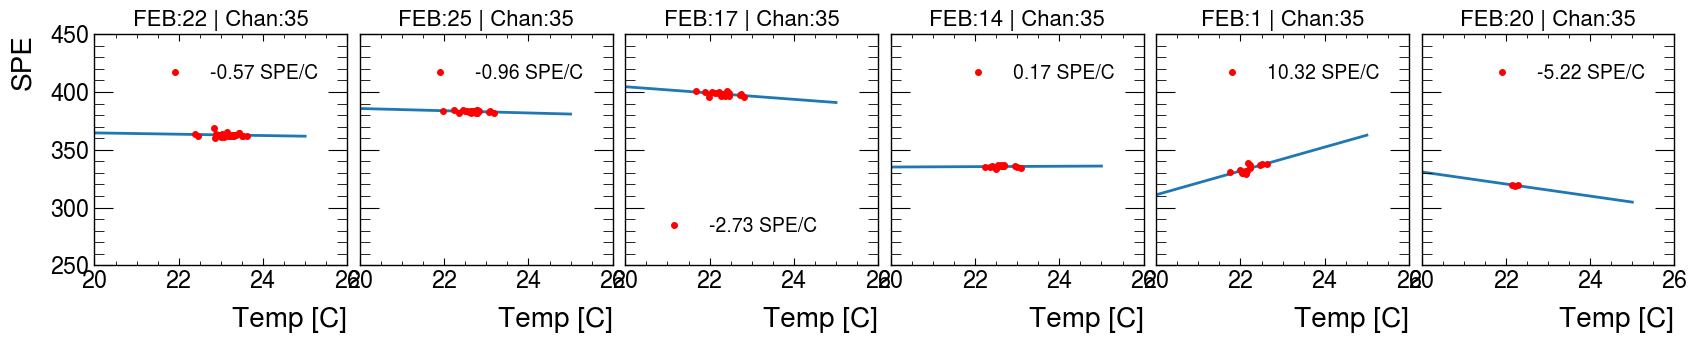

<Figure size 800x600 with 0 Axes>

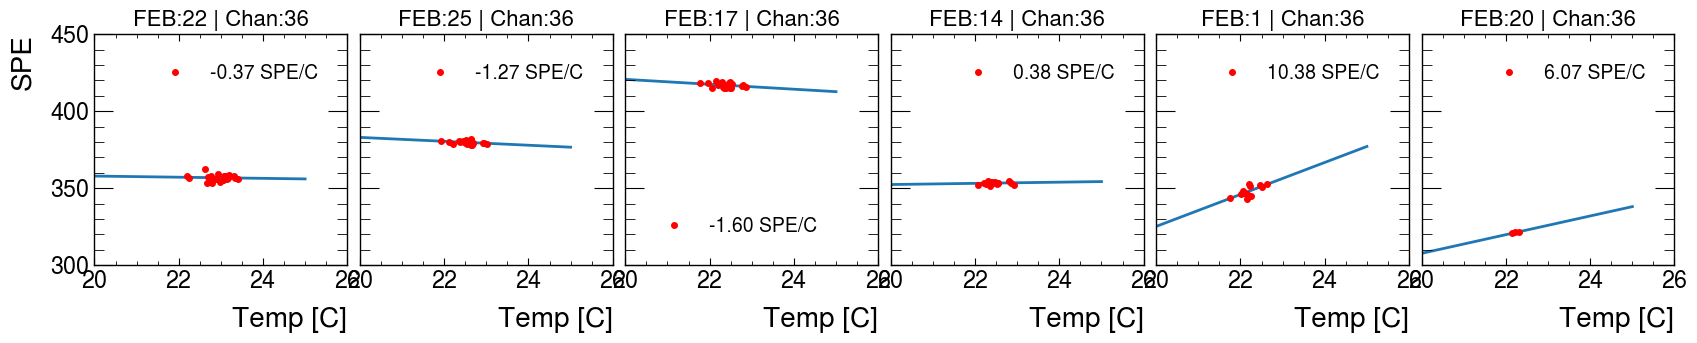

<Figure size 800x600 with 0 Axes>

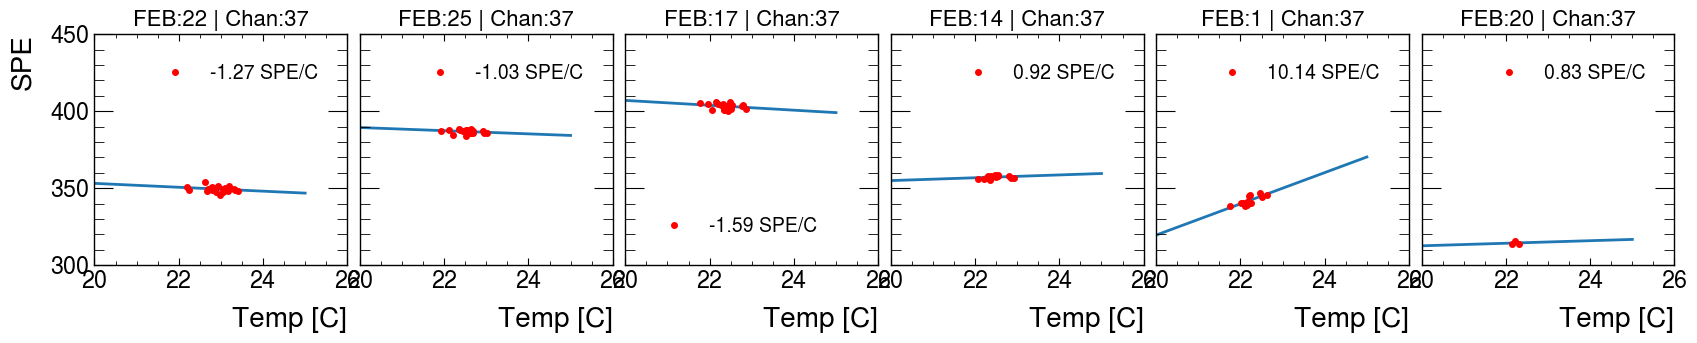

<Figure size 800x600 with 0 Axes>

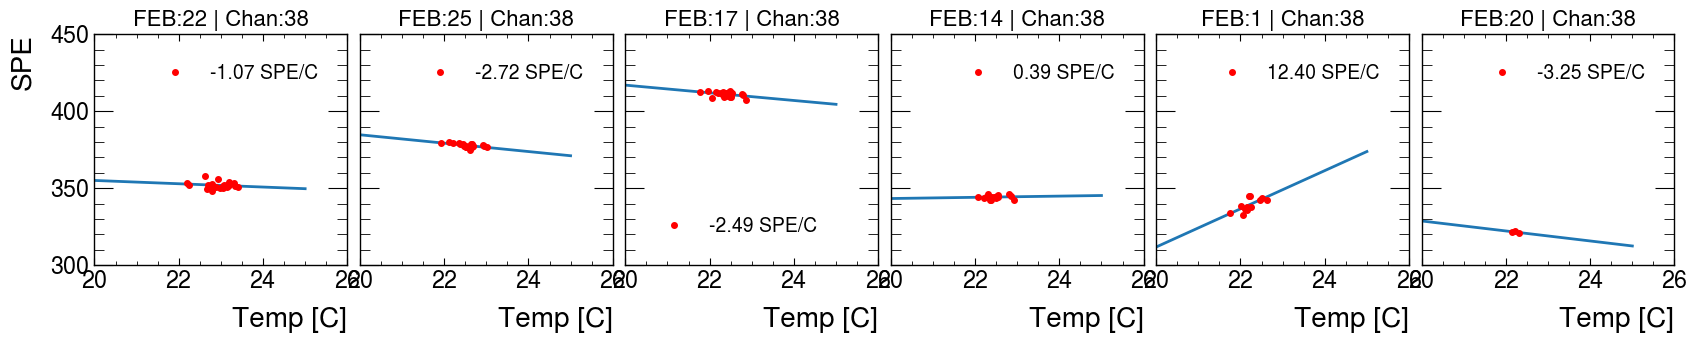

<Figure size 800x600 with 0 Axes>

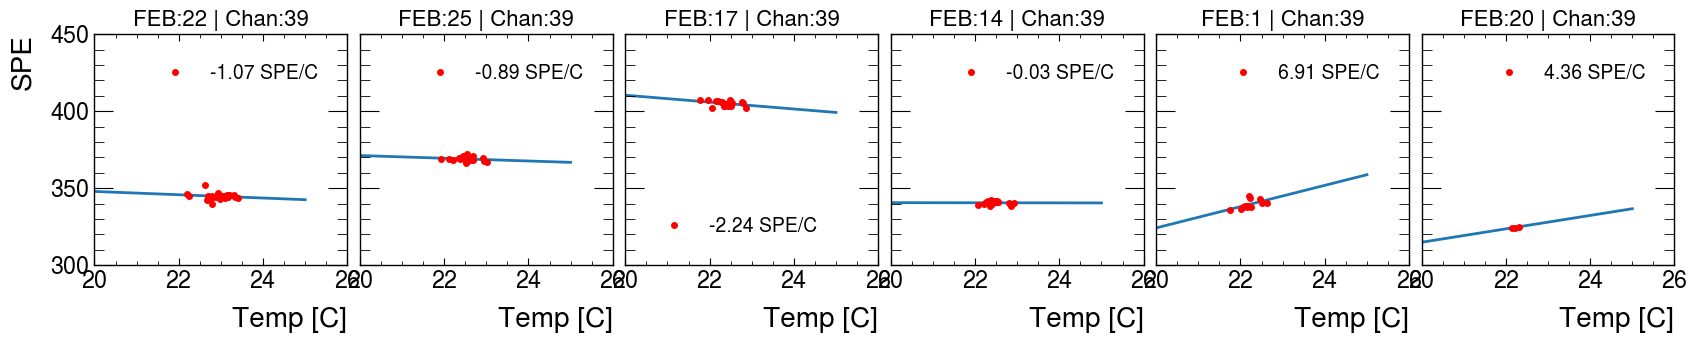

<Figure size 800x600 with 0 Axes>

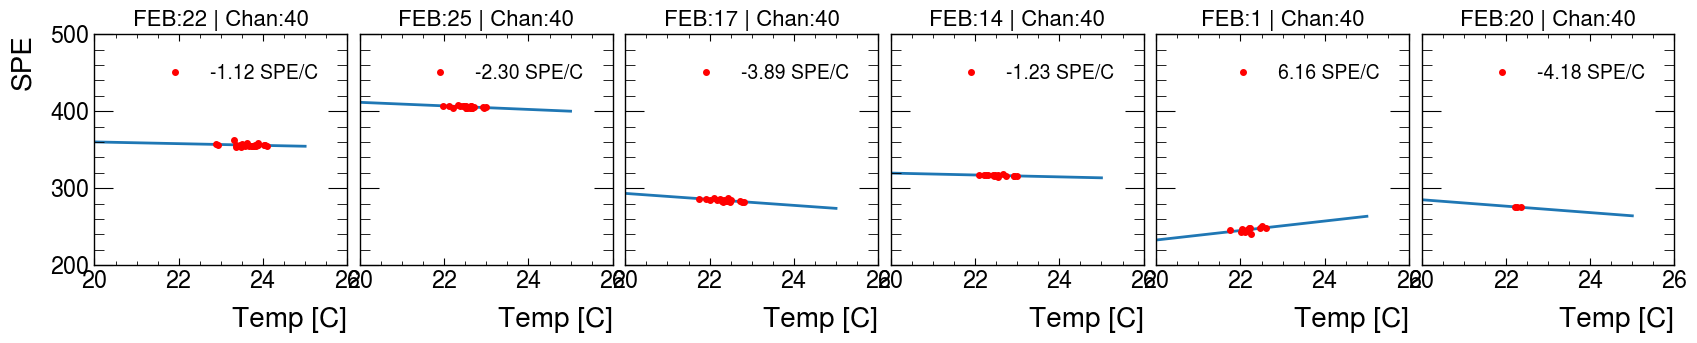

<Figure size 800x600 with 0 Axes>

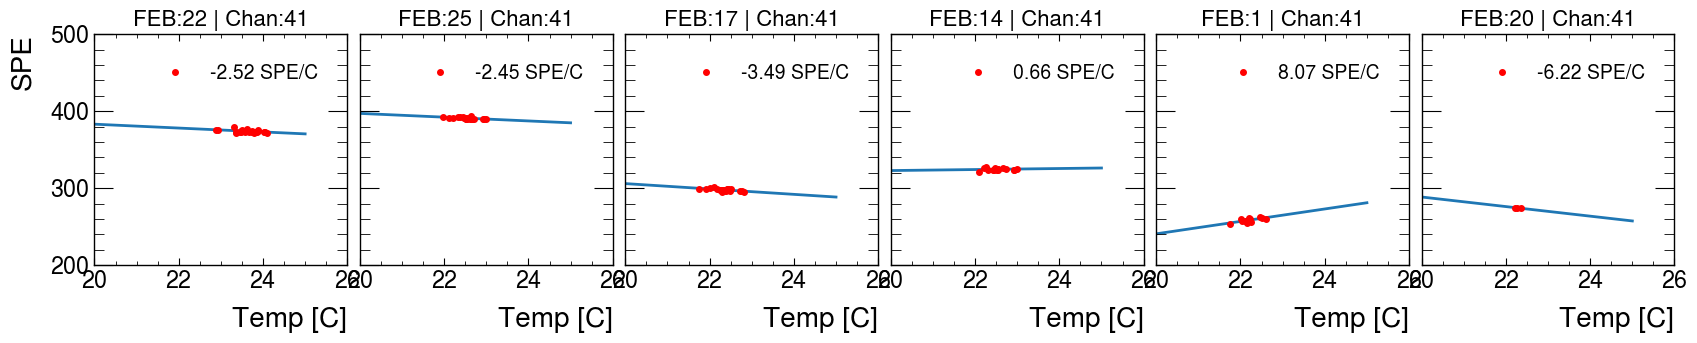

<Figure size 800x600 with 0 Axes>

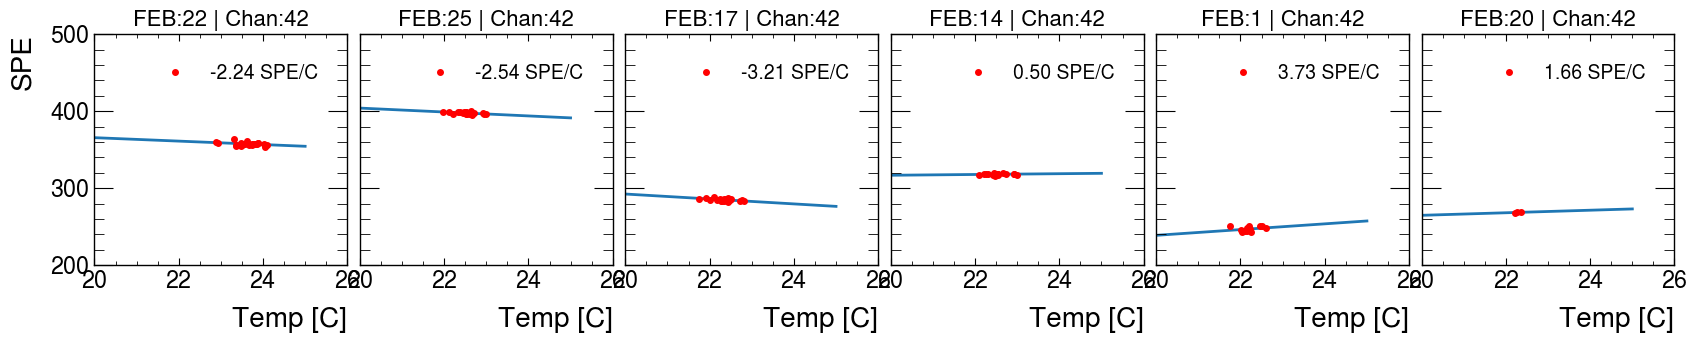

<Figure size 800x600 with 0 Axes>

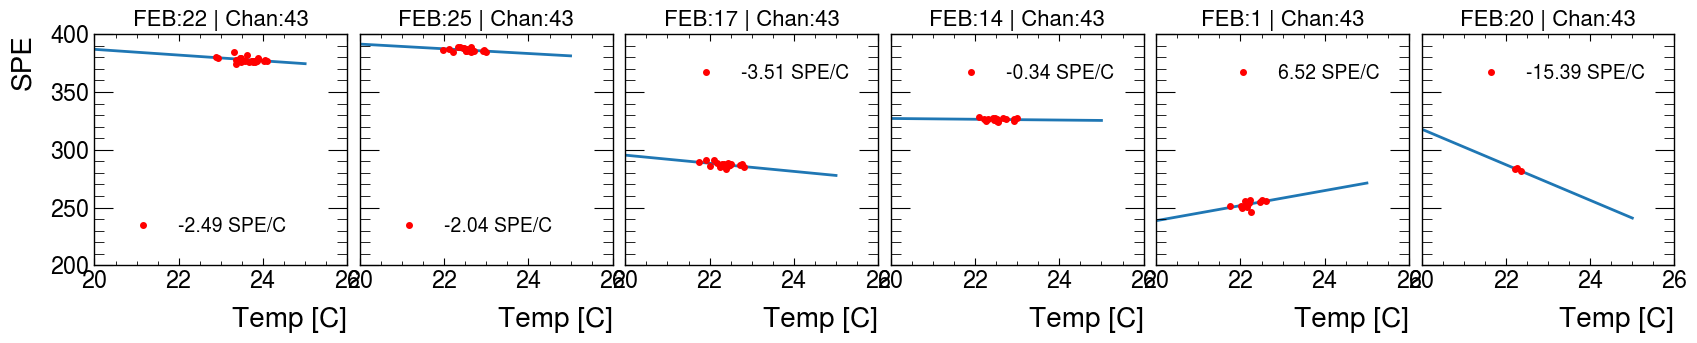

<Figure size 800x600 with 0 Axes>

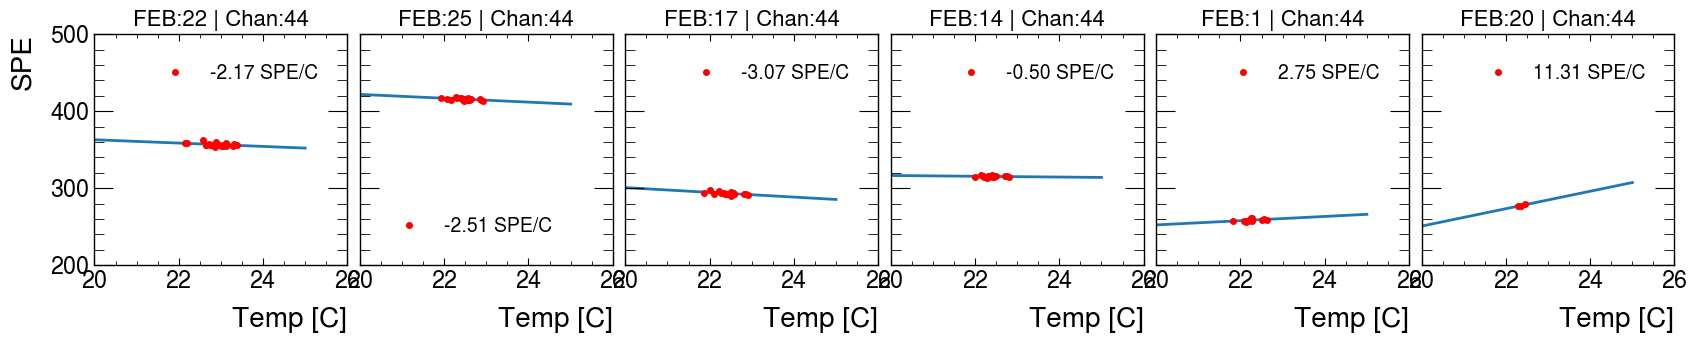

<Figure size 800x600 with 0 Axes>

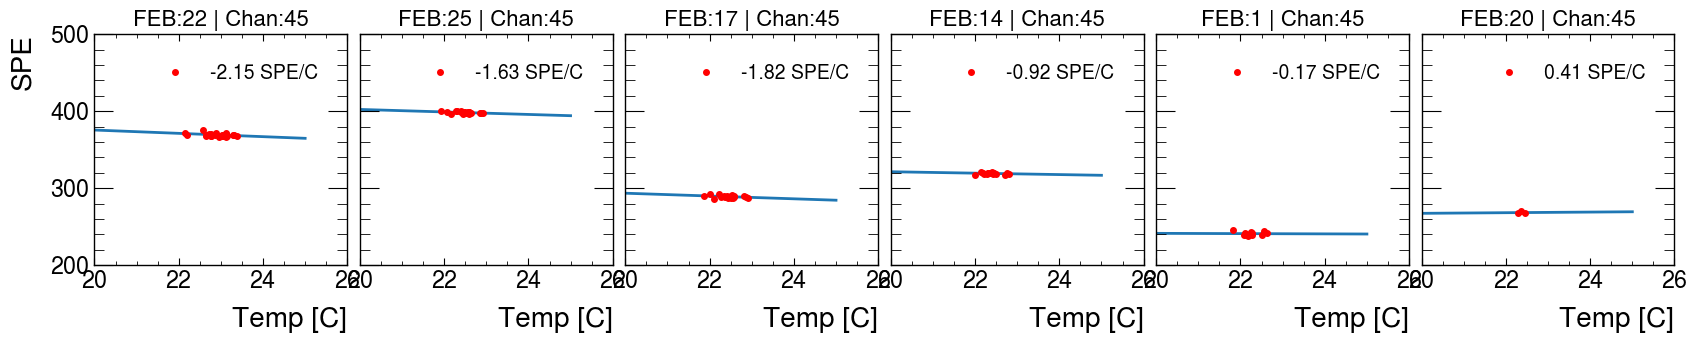

<Figure size 800x600 with 0 Axes>

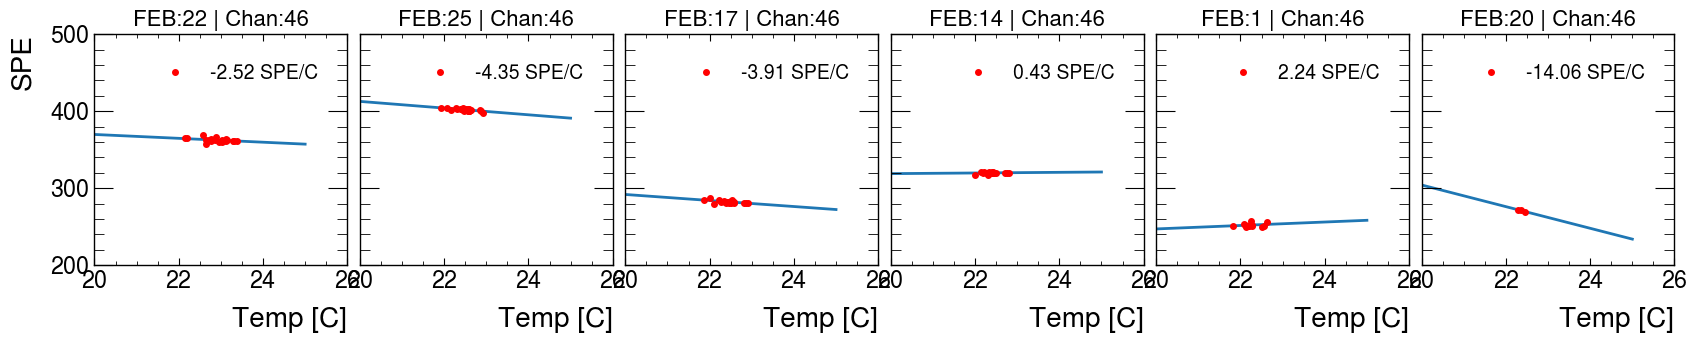

<Figure size 800x600 with 0 Axes>

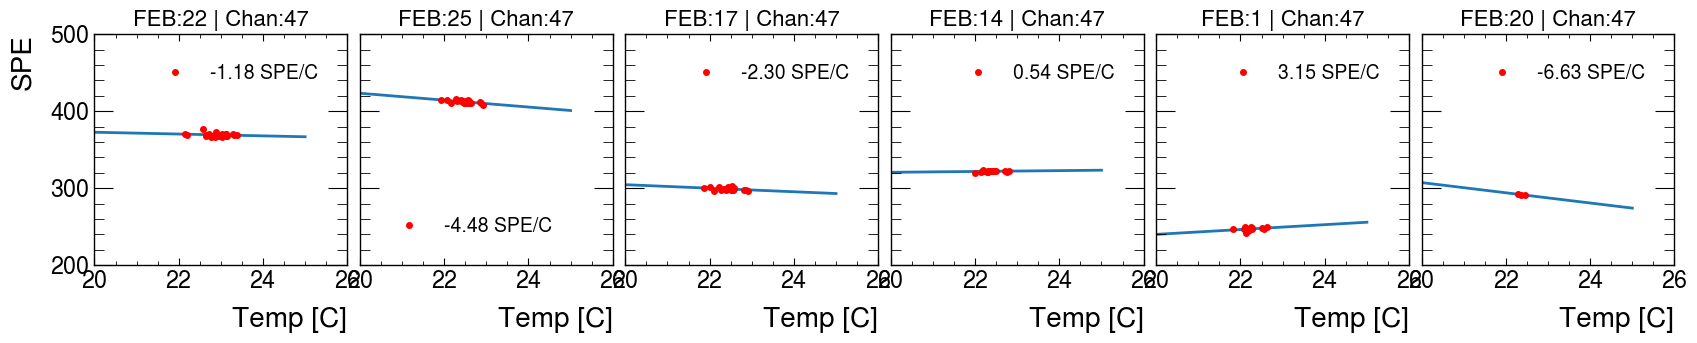

<Figure size 800x600 with 0 Axes>

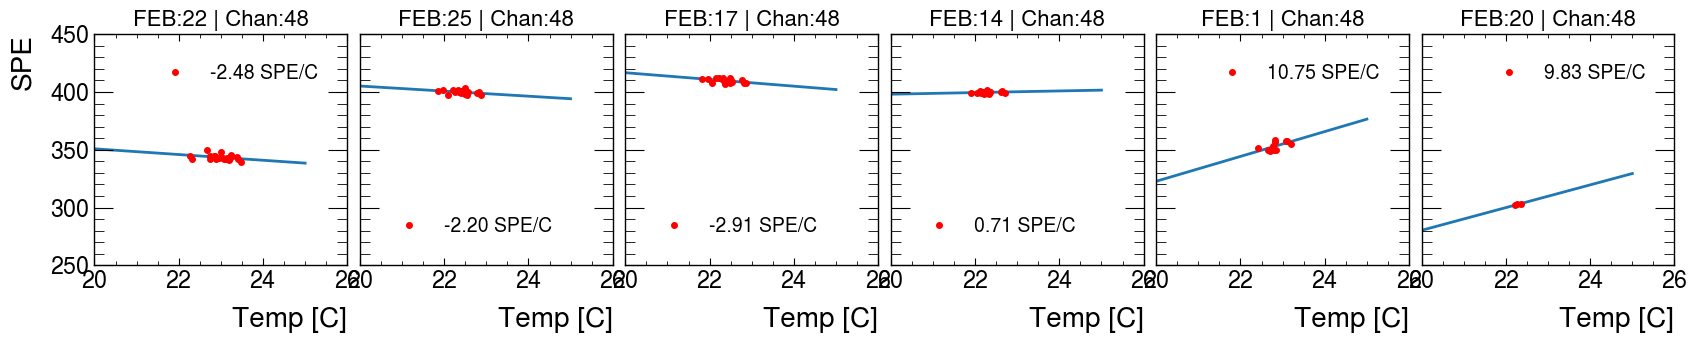

<Figure size 800x600 with 0 Axes>

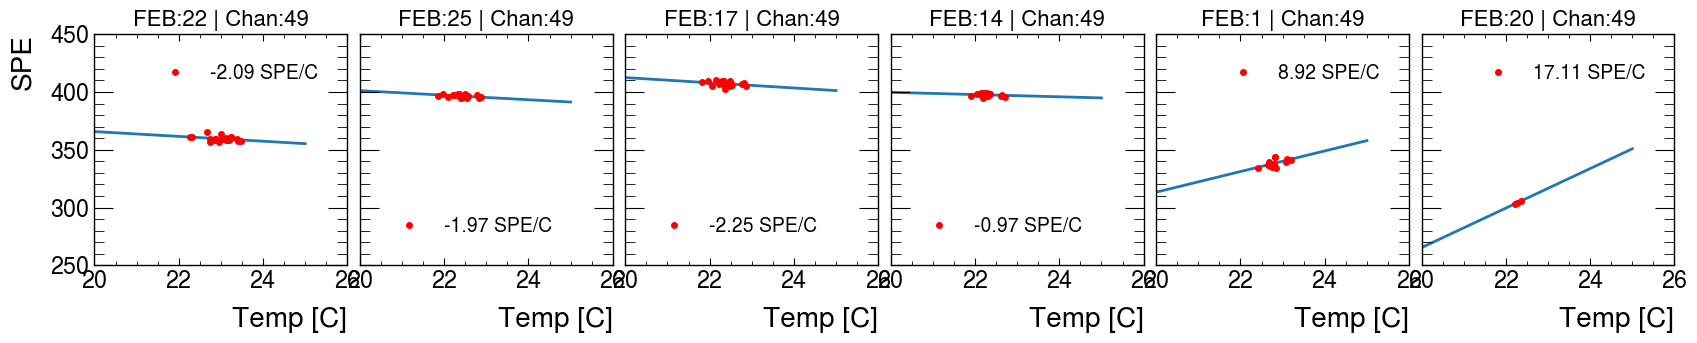

<Figure size 800x600 with 0 Axes>

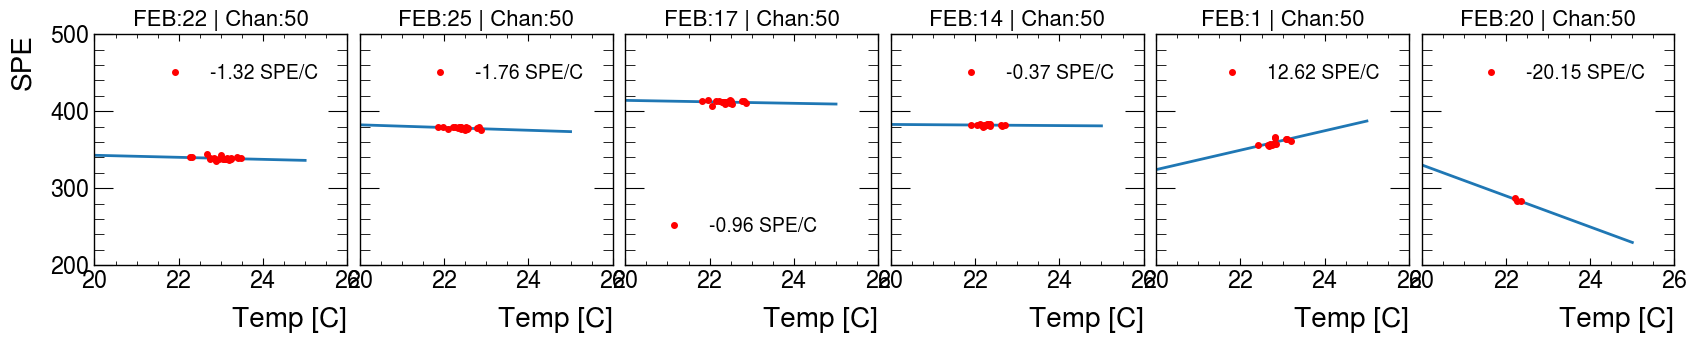

<Figure size 800x600 with 0 Axes>

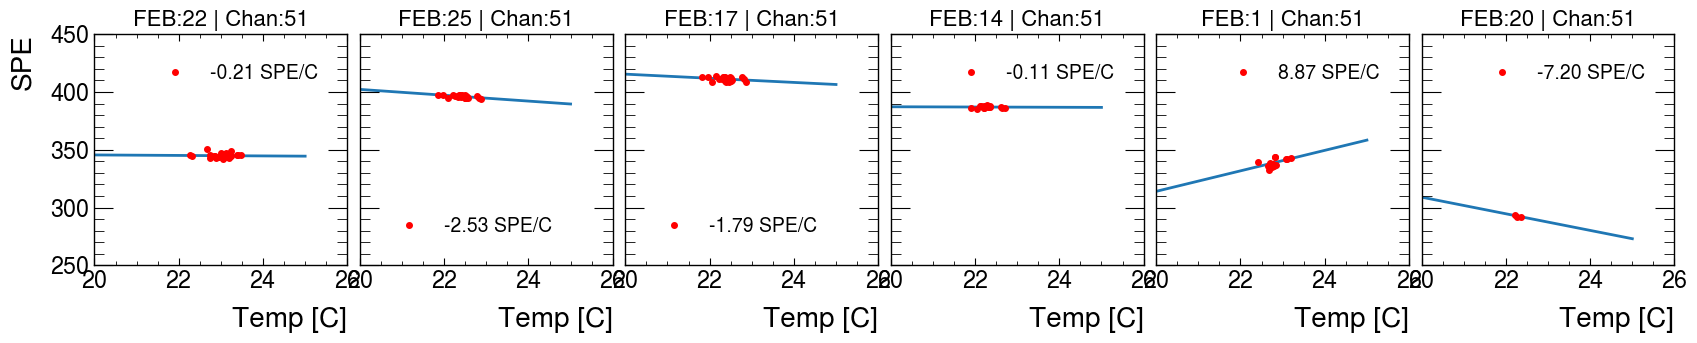

<Figure size 800x600 with 0 Axes>

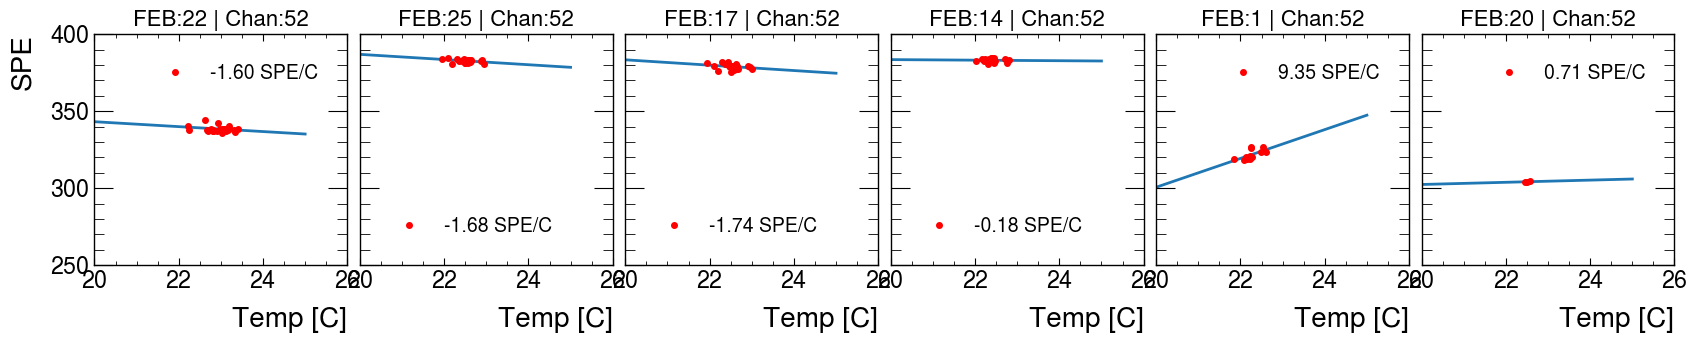

<Figure size 800x600 with 0 Axes>

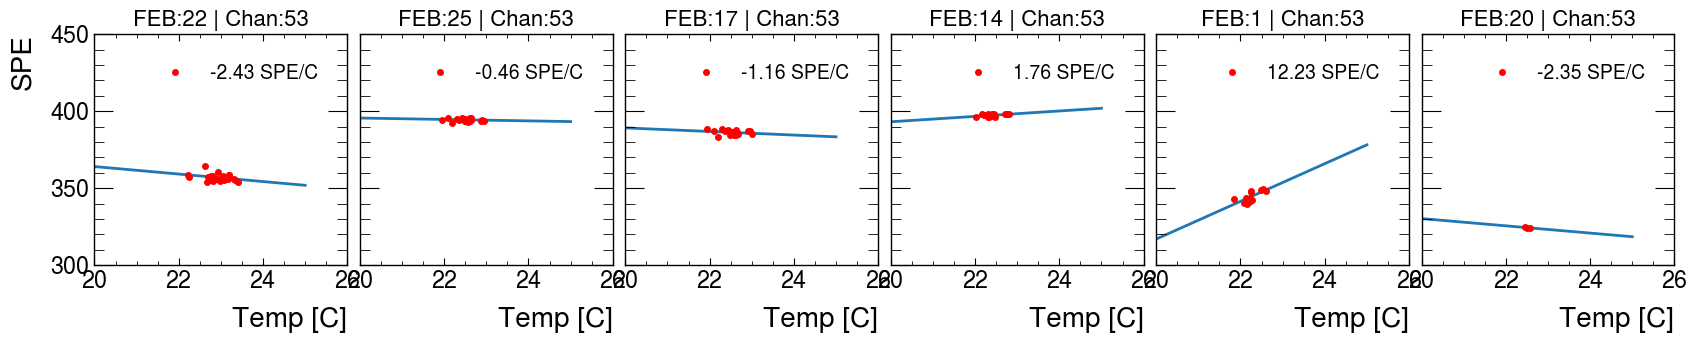

<Figure size 800x600 with 0 Axes>

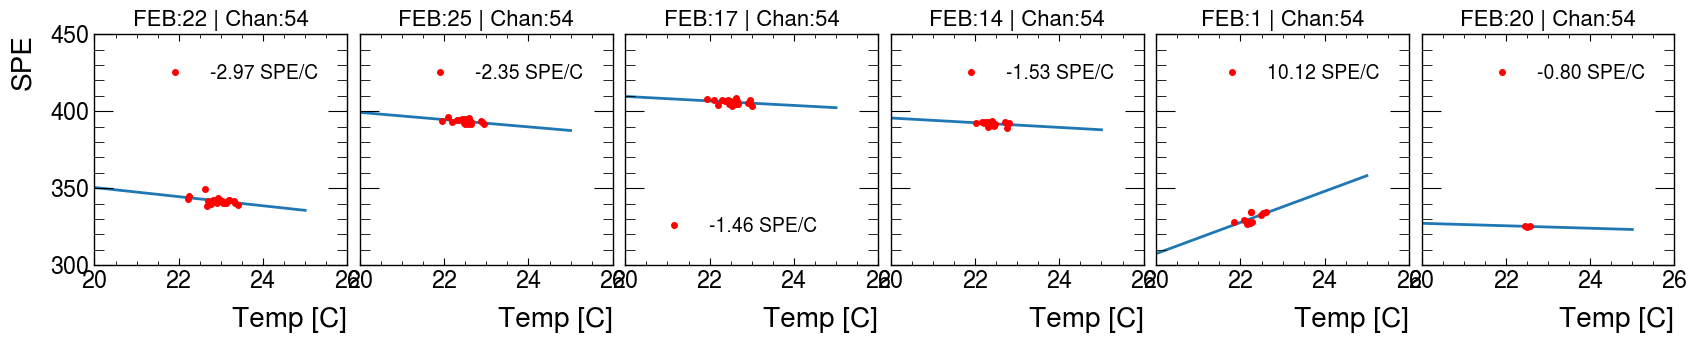

<Figure size 800x600 with 0 Axes>

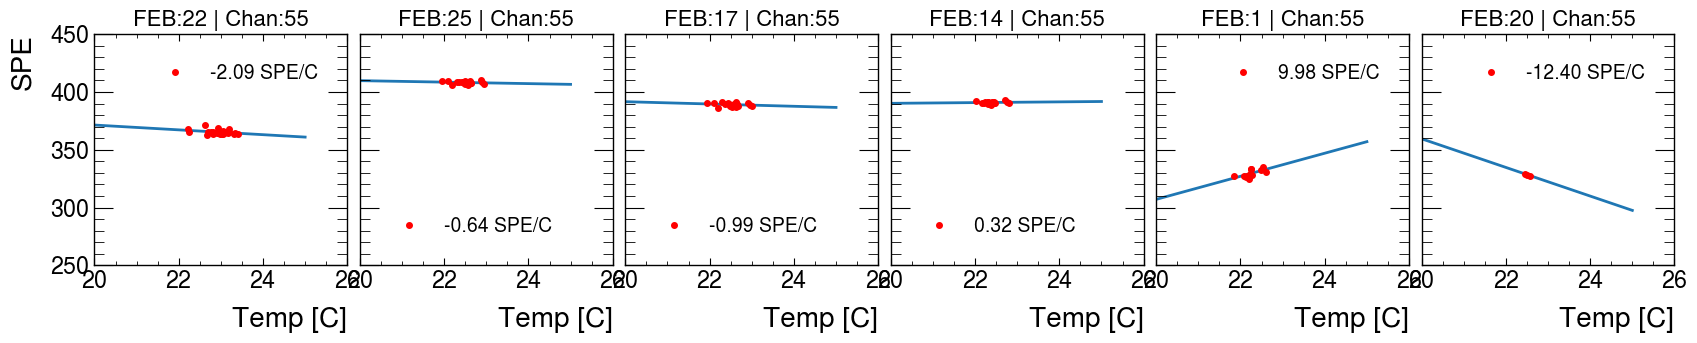

<Figure size 800x600 with 0 Axes>

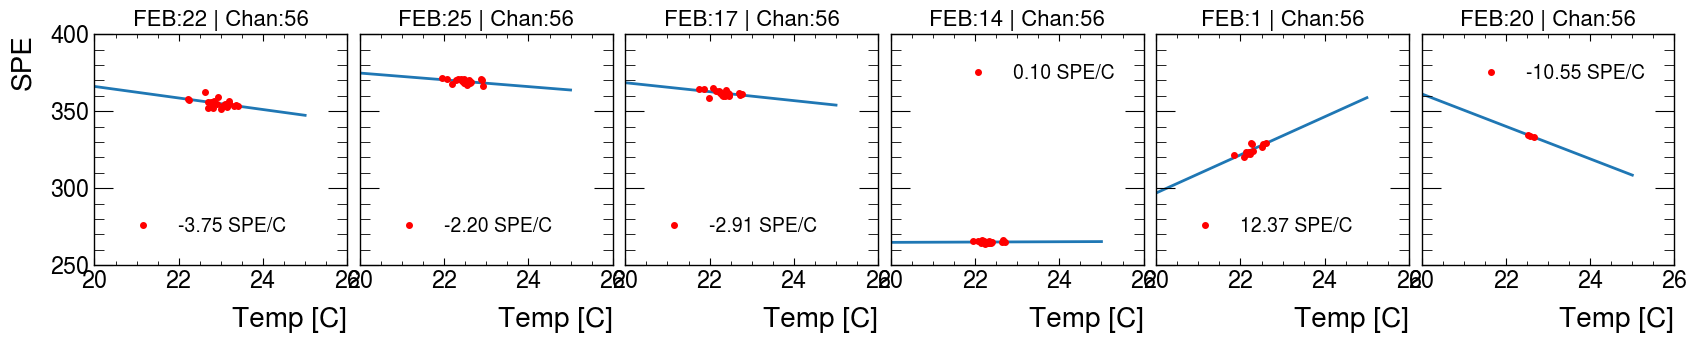

<Figure size 800x600 with 0 Axes>

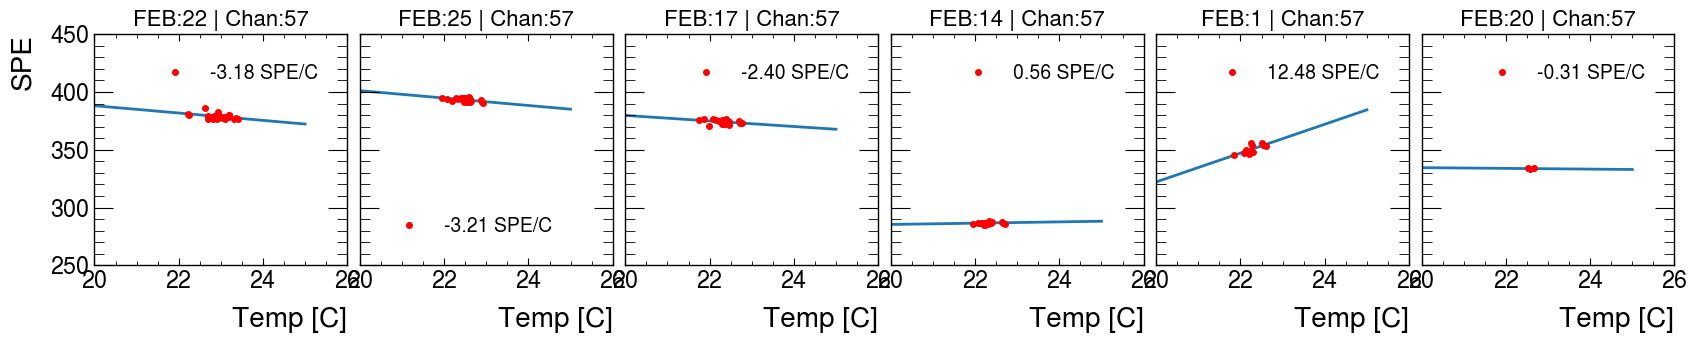

<Figure size 800x600 with 0 Axes>

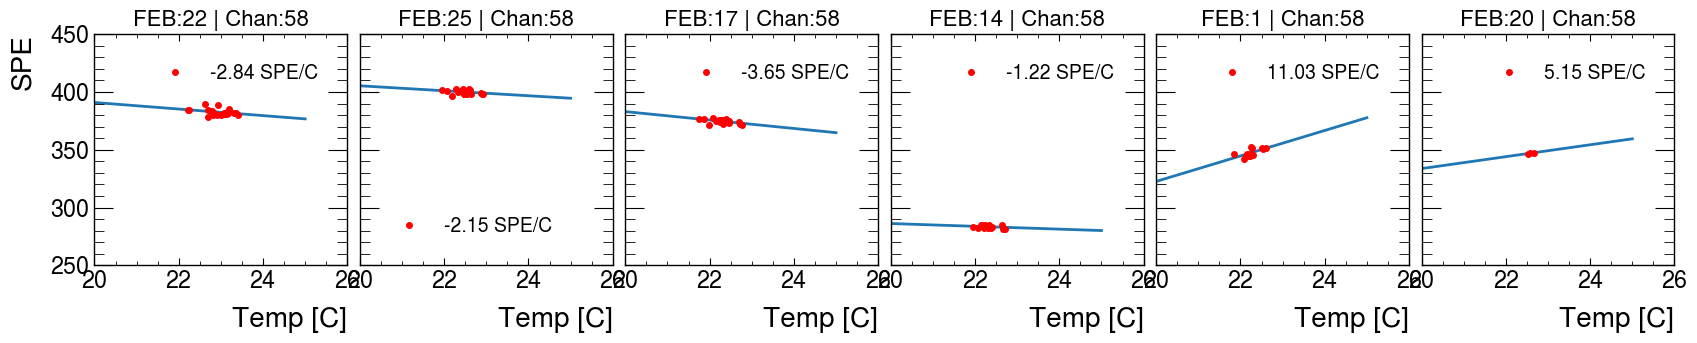

<Figure size 800x600 with 0 Axes>

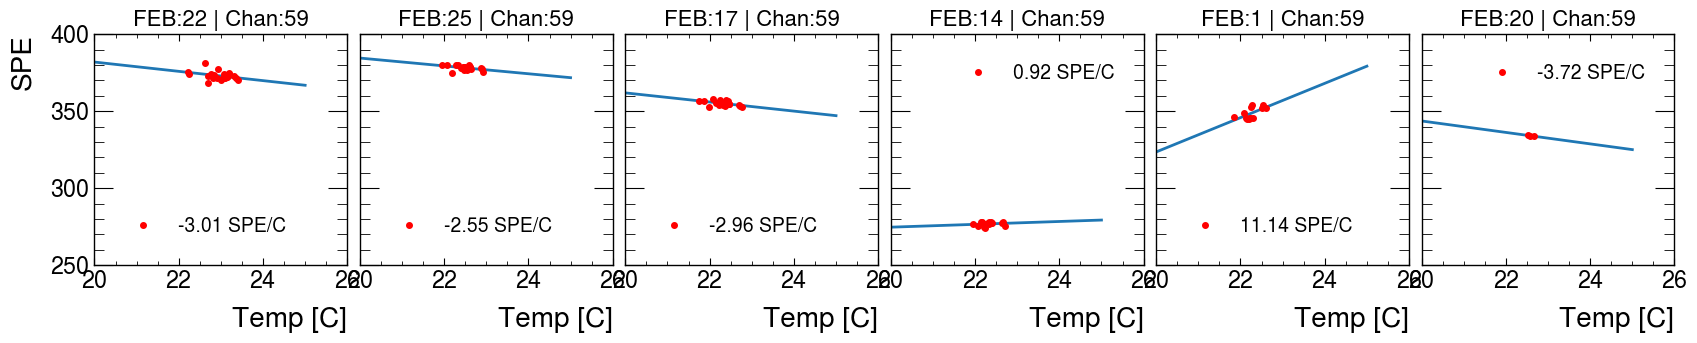

<Figure size 800x600 with 0 Axes>

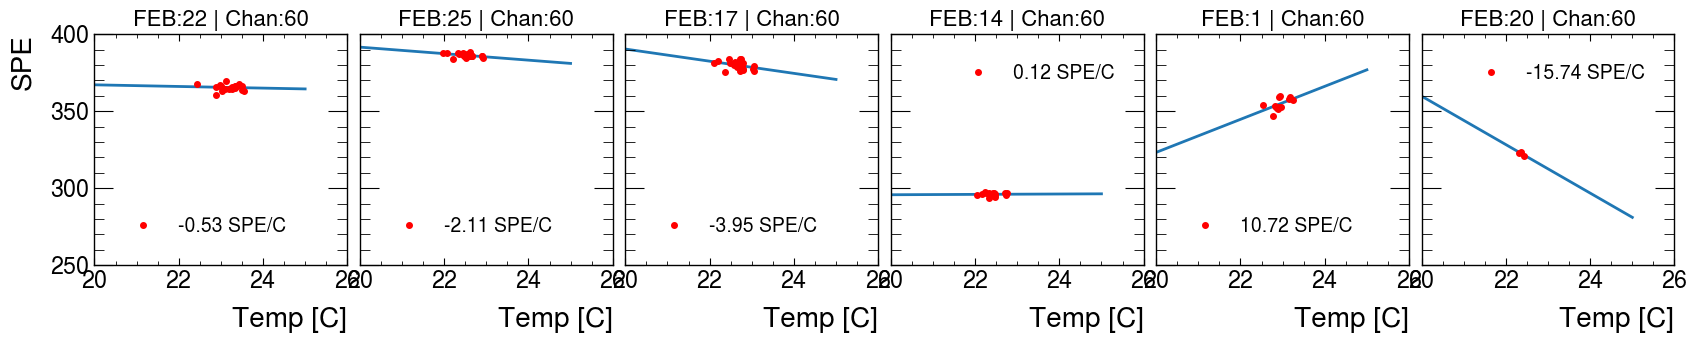

<Figure size 800x600 with 0 Axes>

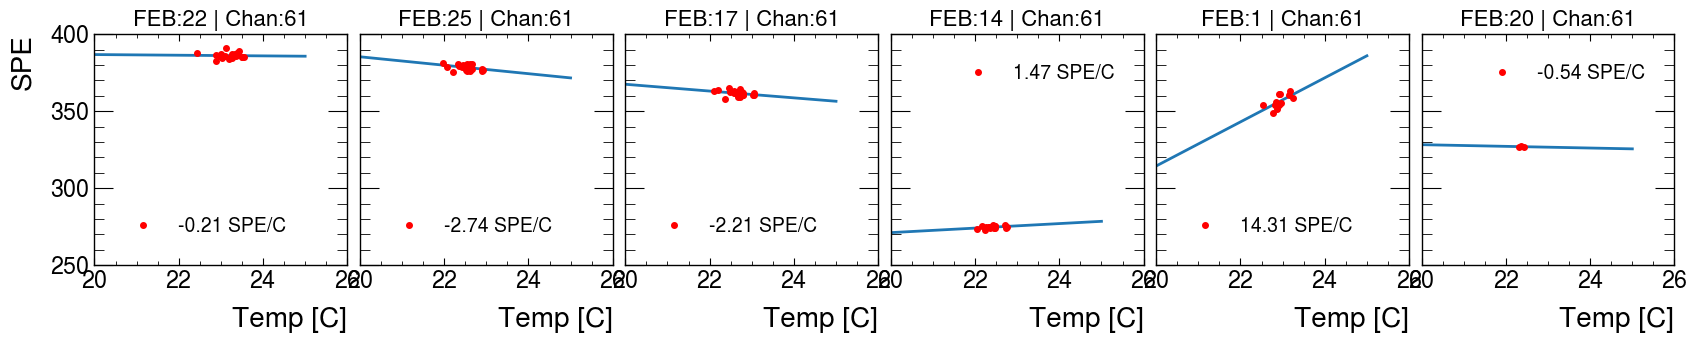

<Figure size 800x600 with 0 Axes>

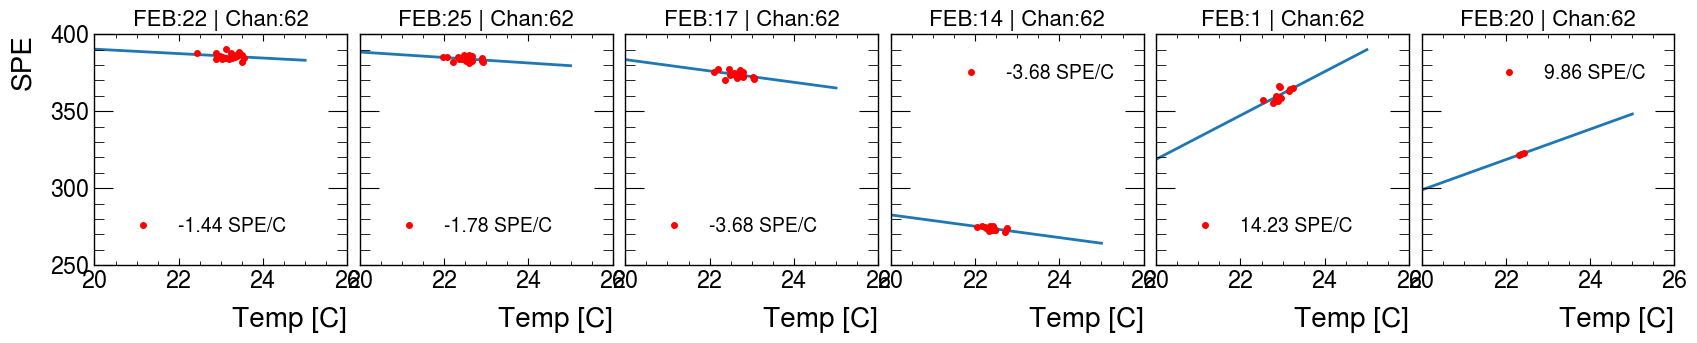

<Figure size 800x600 with 0 Axes>

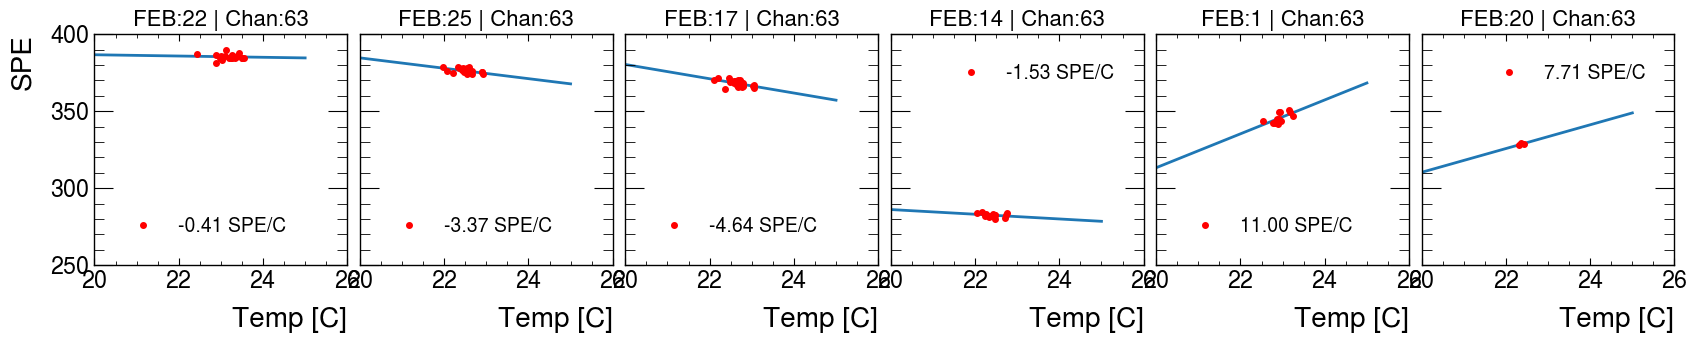

In [153]:
NFEB=6
spe_temp = -999*np.ones((NFEB,64))

for chan in range(0,64): # Loop thgough channels
  plt.figure()
  fig, ax1 = plt.subplots(nrows=1, ncols=6, figsize=(20, 3), sharey='row')
  plt.subplots_adjust(wspace=0.05)
  ax1[0].set_ylabel('SPE')

  for idx, feb in enumerate([22, 25, 17, 14, 1, 20]):
    cut = (ar['febID'] == feb)
    x=ar["meanTemperatures", cut]
    y=ar["calibConstantsTemperatureCorrected", cut]
    
    x=x[ak.num(x) > 0, 0].to_numpy()[:,chan] #Select runs that are only preent for this FEB
    y=y[ak.num(y) > 0, 0].to_numpy()[:,chan]
    x=x[y > 0] # Drop bad SPE points 
    y=y[y > 0] # Drop bad SPE points

    if len(x) == 0:
        continue
    
    linmodel = np.poly1d(np.polyfit(x, y, 1))
    xline = np.linspace(20, 25, 100)
    ax1[idx].plot(xline, linmodel(xline))
    ax1[idx].plot(x,y,'r.', label='%.2f SPE/C'%linmodel.coeffs[0])

    ax1[idx].set_xlabel('Temp [C]')
    
#    ax1[idx].set_xlim(40,65)
#    ax1[idx].set_ylim(53,55)
    ax1[idx].legend()
    ax1[idx].set_title('FEB:%d | Chan:%d'%(feb, chan), fontsize=16)
    spe_temp[idx][chan] = linmodel.coeffs[0]

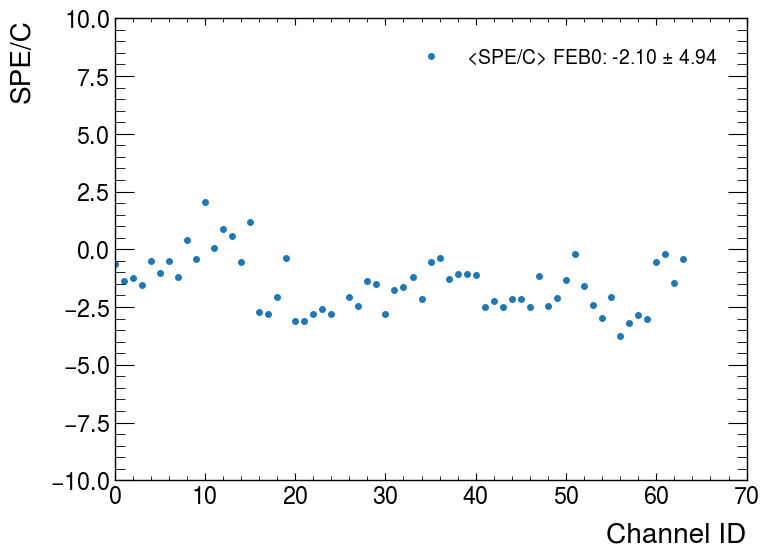

In [163]:
for feb in range(0, 1):
    arr_ = spe_temp[feb,:]
    plt.plot(arr_, '.', label='<SPE/C> FEB%d: %.2f $\pm$ %.2f'%(feb, arr_[~np.isnan(arr_)].mean(), arr_[~np.isnan(arr_)].std()   ))
    plt.legend()
    plt.xlabel('Channel ID')
    plt.ylabel('SPE/C')
#    plt.xlim(0,20)
    plt.ylim(-10,10)